In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "Datasets/VanilaDataset"
train_patterns = pd.read_csv(file_path + "/train_patterns_with_symbols.csv")
test_patterns = pd.read_csv(file_path + "/test_patterns_with_symbols.csv" )

In [3]:
train_patterns

Symbol                 Chart Pattern  BullishBearish       Start  \
0       GIS         Triangle, symmetrical               0  2024-12-18   
1       TXN     Double Top, Adam and Adam               0  2025-01-15   
2      BSET          Flag, high and tight               1  2020-06-25   
3      NOVT  Double Bottom, Adam and Adam               0  2024-02-21   
4      IPAR   Double Bottom, Eve and Adam               0  2024-05-01   
...     ...                           ...             ...         ...   
2373     CE     Head-and-shoulders bottom               1  2022-02-24   
2374    KMT        Head-and-shoulders top               0  2025-01-06   
2375   BERY     Double Top, Adam and Adam              -1  2020-02-06   
2376    MUR     Double Top, Adam and Adam               0  2023-04-03   
2377   OMCL  Double Bottom, Adam and Adam               1  2020-03-20   

             End                 Industry  Pattern_Length  
0     2025-01-02          Food Processing              15  
1     2025-01-23            Semiconductor               8  
2     2020-08-20    Furn/Home Furnishings              56  
3     2024-02-27     Precision Instrument               6  
4     2024-05-08     Toiletries/Cosmetics               7  
...          ...                      ...             ...  
2373  2022-03-15         Chemical (Basic)              19  
2374  2025-01-30        Metal Fabricating              24  
2375  2020-02-21  Packaging and Container              15  
2376  2023-04-11   Petroleum (Integrated)               8  
2377  2020-03-27   Healthcare Information               7  

[2378 rows x 7 columns]

In [4]:
test_patterns

Symbol                 Chart Pattern  BullishBearish       Start  \
0      NUS   Double Bottom, Eve and Adam               0  2023-01-19   
1      CLS  Double Bottom, Adam and Adam               0  2024-03-11   
2     ADTN         Triangle, symmetrical               0  2023-06-16   
3     ADTN     Head-and-shoulders bottom               1  2020-09-09   
4      NSP  Double Bottom, Adam and Adam               0  2023-05-16   
..     ...                           ...             ...         ...   
590   RGLD     Double Top, Adam and Adam               0  2024-10-21   
591    MRK   Double Bottom, Eve and Adam               0  2024-08-07   
592    IRM  Double Bottom, Adam and Adam               0  2025-01-28   
593    CBT     Double Top, Adam and Adam               0  2024-11-25   
594     BG  Double Bottom, Adam and Adam               1  2022-07-06   

            End                  Industry  Pattern_Length  
0    2023-01-31      Toiletries/Cosmetics              12  
1    2024-03-19               Electronics               8  
2    2023-07-10        Telecom. Equipment              24  
3    2020-10-02        Telecom. Equipment              23  
4    2023-05-31           Human Resources              15  
..          ...                       ...             ...  
590  2024-10-29  Metals and Mining (Div.)               8  
591  2024-08-14                      Drug               7  
592  2025-02-03       Industrial Services               6  
593  2024-12-04    Chemical (Diversified)               9  
594  2022-07-14           Food Processing               8  

[595 rows x 7 columns]

In [5]:
# geth the 1st row of the test_patterns 
row = test_patterns.iloc[0]
# convert to date time
row['Start'] = pd.to_datetime(row['Start'])
print (row['Start'])
print(row['Start'] - pd.to_timedelta(5, unit='D'))

2023-01-19 00:00:00
2023-01-14 00:00:00


C:\Users\gwiku\AppData\Local\Temp\ipykernel_8880\3529229644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Start'] = pd.to_datetime(row['Start'])


# Preparing the Test Data Segments


In [6]:
pattern_encoding = {'Double Top, Adam and Adam': 0, 'Triangle, symmetrical': 1, 'Double Bottom, Eve and Adam': 2, 'Head-and-shoulders top': 3, 'Double Bottom, Adam and Adam': 4, 'Head-and-shoulders bottom': 5, 'Flag, high and tight': 6, 'Cup with handle': 7}
pattern_encoding_reversed = {v: k for k, v in pattern_encoding.items()}
extra_days = 100

# create a new empty dataframe with Seg_ID, Seg_Start , Seg_End columsn + the same columns as the test_patterns
columns = ['Seg_ID', 'Seg_Start', 'Seg_End'] + list(test_patterns.columns)
# create an empty dataframe
test_pattern_segment_wise = pd.DataFrame(columns=columns)


# set the path to the folder containing the data
path = 'Datasets/OHLC data'

In [7]:
# add a row to test_pattern_segment_wise
def add_row_to_test_pattern_segment_wise(row,seg_id, start, end):
    global test_pattern_segment_wise
    row['Seg_ID'] = seg_id
    row['Seg_Start'] = start
    row['Seg_End'] = end
    test_pattern_segment_wise = test_pattern_segment_wise.append(row, ignore_index=True)

In [8]:
lable_df = pd.DataFrame(columns=['Pattern', 'Center', 'Width'])
# and give this 2 level indexes, level 0 called Instance and level 1 called Pattern_Id
lable_df.index = pd.MultiIndex.from_tuples([], names=['Instance', 'Pattern_Id'])

def add_to_lables( pattern, center, width ,instance, pattern_idx):
    global lable_df
    new_row = { 
                'Pattern': pattern,  # Example pattern
                'Center': center ,  # Example start date
                'Width': width # Example end date
            }
    # Define the MultiIndex for the new row
    new_index = pd.MultiIndex.from_tuples([(instance, pattern_idx)], names=['Instance', 'Pattern_Id'])

    # Create a DataFrame for the new row and append it to the original DataFrame
    new_df = pd.DataFrame([new_row], index=new_index, columns=lable_df.columns)
    lable_df = pd.concat([lable_df, new_df])

## Creating test data segments


Im trying to get test data segments with some surrounding data with a maximem possible number of teting data in a single segment while avoiding training data


In [9]:
import os
from tqdm import tqdm
segment_id = 0

# loop through the files in the folder
for filename in tqdm(os.listdir(path), desc="Processing files"):
        if filename.endswith('.csv'):
        # print(filename)
            OHCL_symbol_df = pd.read_csv(path + '/' + filename)
            # print(df.head())
            
            # convert the date columns to datetime
            OHCL_symbol_df['Date'] = pd.to_datetime(OHCL_symbol_df['Date'])
            
            max_available_date = OHCL_symbol_df['Date'].max()
            min_available_date = OHCL_symbol_df['Date'].min()
            
            name = os.path.splitext(filename)[0]
            
            # get the rows of pattern_labled_df where Symbol == name
            train_data_this_symbol = (train_patterns[train_patterns['Symbol'] == name]).copy()
            test_data_this_symbol = (test_patterns[test_patterns['Symbol'] == name]).copy()
            
            # reset the index of the dataframes
            train_data_this_symbol.reset_index(drop=True, inplace=True)
            test_data_this_symbol.reset_index(drop=True, inplace=True)
            
            # in test data create a new column ID and give it the same value as the index
            test_data_this_symbol['ID'] = test_data_this_symbol.index
            
            # print(test_data_this_symbol)
            
            
            # convert the date columns to datetime
            train_data_this_symbol['Start'] = pd.to_datetime(train_data_this_symbol['Start'])
            train_data_this_symbol['End'] = pd.to_datetime(train_data_this_symbol['End'])
            test_data_this_symbol['Start'] = pd.to_datetime(test_data_this_symbol['Start'])
            test_data_this_symbol['End'] = pd.to_datetime(test_data_this_symbol['End'])
            
            
            # 01. pick one test item
            # 02. get the left cut off date as the max of start date - 50 or the cthe end date of a train data point that has a end date between test start date and test start - 50
            # 03. get the right cut off date as the min of end date + 50 or the cthe start date of a train data point that has a start date between test end date and test end + 50
            # 04. get the tets data points that can fit in between the left and right cut off dates
            # 05. iterate the set of test items that is to the left of the selected one , as the new start date is the start date of the i th items start date and the end date is that + 100 + the length of the selcted item
            # 06. get the number of test items that fit between the segment in each iteration , and select the option that has the max number of test items
            # 07. get the wiggle room by the min start date of the test items that fit in the segment and the max end date of the test items that fit in the segment and try to randomise the start and end dates of the segment
            
            # get a list of randomly ordered test item indexes
            index_touple = list(range(len(test_data_this_symbol)))
            np.random.shuffle(index_touple)
            
            # 01. pick one test item
            
            for test_idx in index_touple:
                # get the test item
                test_item = test_data_this_symbol[test_data_this_symbol['ID'] == test_idx]
                index_touple.remove(test_idx)
                selected_test_item_length = test_item['End'] - test_item['Start']
                
                # 02. get the left  and right min and max possible segment dates 
                min_possible_seg_start = (test_item['Start'] - pd.to_timedelta(extra_days, unit='D')).iloc[0]
                max_possible_seg_end = (test_item['End'] + pd.to_timedelta(extra_days, unit='D')).iloc[0]
                
                # 03. get the left and right cut off dates avoiding the train data points that are within the possible segment
                # get the train data points that are within the possible segment
                train_data_that_fit = train_data_this_symbol[(train_data_this_symbol['Start'] <= max_possible_seg_end) | (train_data_this_symbol['End'] >= min_possible_seg_start)]
                
                # get the  maximum of the End dates of train_data_that_fit
                left_cut_off = min_possible_seg_start
                right_cut_off = max_possible_seg_end
                # left_cut_off = min(max(min_possible_seg_start, train_data_that_fit['End'].max()),test_item['Start'].iloc[0])
                if (((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    left_cut_off = test_item['Start'].iloc[0]
                elif (((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] < test_item['Start'].iloc[0])).any()) :
                    Left_cut_off = train_data_that_fit[((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] < test_item['Start'].iloc[0]))]['End'].max()
                else :
                    left_cut_off = min_possible_seg_start
                
                left_cut_off = max(left_cut_off, min_possible_seg_start)
                
                # get the  minimum of the Start dates of train_data_that_fit
                # right_cut_off = max(min(max_possible_seg_end, train_data_that_fit['Start'].min()),test_item['End'].iloc[0])
                if (((train_data_that_fit['Start'] < test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    right_cut_off = test_item['End'].iloc[0]
                elif (((train_data_that_fit['Start'] > test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    right_cut_off = train_data_that_fit[((train_data_that_fit['Start'] > test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0]))]['Start'].min()
                else :
                    right_cut_off = max_possible_seg_end
                
                right_cut_off = min(right_cut_off, max_possible_seg_end)
                
                # 04. get the test data points that are within the cut off dates
                test_data_that_fit = test_data_this_symbol[(test_data_this_symbol['Start'] >= left_cut_off) & (test_data_this_symbol['End'] <= right_cut_off)] 
                
                # if (len(test_data_that_fit) > 1) :
                #     print("test_data_that_fit")
                     
                items_that_fit = pd.DataFrame()
                if(len(test_data_that_fit) > 1):     
                
                    # 05. iterate the test_data_that_fit and get the number of test items that fit in the segment
                    number_of_test_items_that_fit = {}
                    test_items_left_to_the_selected = test_data_that_fit[test_data_that_fit['Start'] <= test_item['Start'].iloc[0]]
                    for idx, row in test_items_left_to_the_selected.iterrows():
                        # get the number of test items that fit in the segment
                        number_of_test_items_that_fit[row["ID"]] = len(test_data_that_fit[(test_data_that_fit['Start'] >= row['Start']) & (test_data_that_fit['End'] <= row['Start'] + pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))])
                
                    test_items_right_to_the_selected = test_data_that_fit[test_data_that_fit['Start'] > test_item['Start'].iloc[0]]
                    for idx, row in test_items_right_to_the_selected.iterrows():
                        # get the number of test items that fit in the segment
                        number_of_test_items_that_fit[row["ID"]] = len(test_data_that_fit[(test_data_that_fit['End'] <= max(row['End'],test_item['End'].iloc[0])) & (test_data_that_fit['Start'] >= max(row['End'],test_item['End'].iloc[0]) - pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))])
                        
                    # 06. get the segment that has the max number of test items that fit
                    # get the key of the max value in the dictionary
                    max_key = max(number_of_test_items_that_fit, key=number_of_test_items_that_fit.get)
                    max_ancor_test_row = test_data_that_fit[test_data_that_fit['ID'] == max_key]
                    
                    if(max_ancor_test_row['Start'].iloc[0]<= test_item['Start'].iloc[0]):
                        items_that_fit = test_data_that_fit[(test_data_that_fit['Start'] >= max_ancor_test_row['Start'].iloc[0]) & (test_data_that_fit['End'] <= max_ancor_test_row['Start'].iloc[0] + pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))]
                    elif(max_ancor_test_row['Start'].iloc[0] > test_item['Start'].iloc[0]):
                        items_that_fit = test_data_that_fit[(test_data_that_fit['End'] <= max(max_ancor_test_row['End'].iloc[0],test_item['End'].iloc[0])) & (test_data_that_fit['Start'] >= max(max_ancor_test_row['End'].iloc[0],test_item['End'].iloc[0]) - pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))]
                    
                    # drop the item with the id of test_item from the items_that_fit
                    items_that_fit = items_that_fit[items_that_fit['ID'] != test_item['ID'].iloc[0]]
                    # print(items_that_fit)
                    
                # 07. get the wiggle room by the min start date of the test items that fit in the segment and the max end date of the test items that fit in the segment and try to randomise the start and end dates of the segment
                if ('items_that_fit' in locals() and not items_that_fit.empty) :
                    max_seg_start_date = min(items_that_fit['Start'].min(),test_item['Start'].iloc[0])
                    min_seg_end_date = max(items_that_fit['End'].max(),test_item['End'].iloc[0])
                else :
                    max_seg_start_date = test_item['Start'].iloc[0]
                    min_seg_end_date = test_item['End'].iloc[0]
                    
                # remove the items that selected from index_touple if it is in index_touple
                for idx, row in items_that_fit.iterrows():
                    if row['ID'] in index_touple:
                        index_touple.remove(row['ID'])
                
                
                # get the wiggle room
                wiggle_room = (pd.to_timedelta(extra_days, unit='D')+ selected_test_item_length.iloc[0]) - (min_seg_end_date - max_seg_start_date)
                
                if (wiggle_room.days < 0) :
                    print("Error")
                
                if ( wiggle_room.days!= 0) :
                    random_days = np.random.randint(0, wiggle_room.days)
                else:
                    random_days = 0
                seg_start_date = max_seg_start_date - pd.to_timedelta(random_days, unit='D')
                seg_end_date = min_seg_end_date + pd.to_timedelta(wiggle_room.days - random_days, unit='D')
                
                seg_start_date = max(seg_start_date, left_cut_off)
                seg_end_date = min(seg_end_date, right_cut_off)
                
                test_pattern_segments = pd.concat([items_that_fit, test_item], ignore_index=True)  
                test_pattern_segments['Seg_ID'] = segment_id
                test_pattern_segments['Seg_Start'] = seg_start_date
                test_pattern_segments['Seg_End'] = seg_end_date
                test_pattern_segment_wise = pd.concat([test_pattern_segment_wise, test_pattern_segments], ignore_index=True)
                segment_id += 1

test_pattern_segment_wise.to_csv("Datasets/test_patterns_large_segment_wise.csv", index=False)
                            

Processing files:   0%|          | 0/632 [00:00<?, ?it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_8880\18054629.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_pattern_segment_wise = pd.concat([test_pattern_segment_wise, test_pattern_segments], ignore_index=True)
Processing files: 100%|██████████| 632/632 [00:06<00:00, 101.78it/s]


### Visualization of sample set of segments


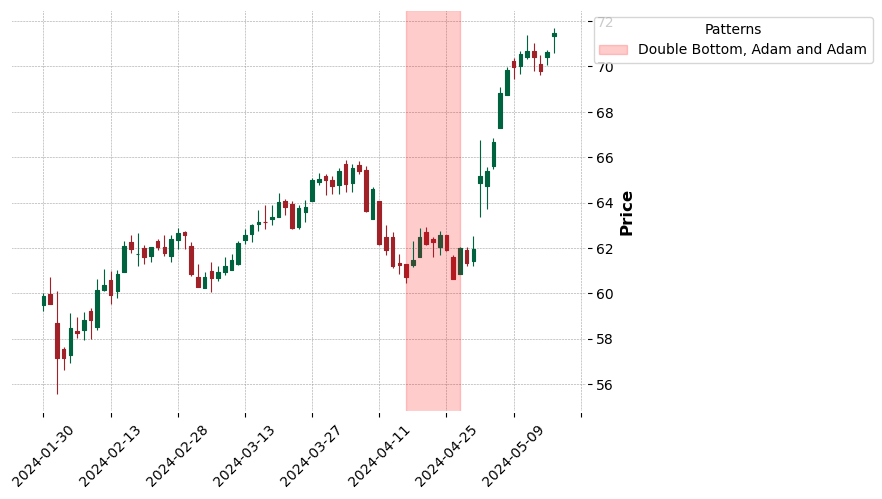

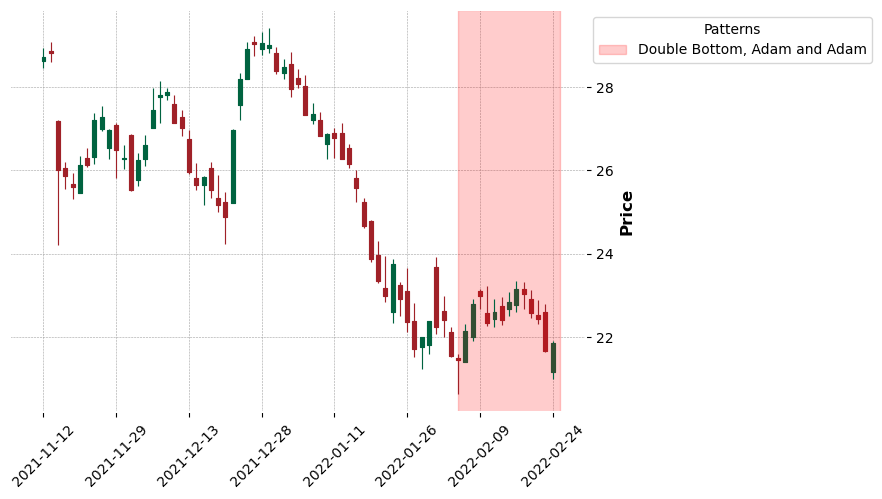

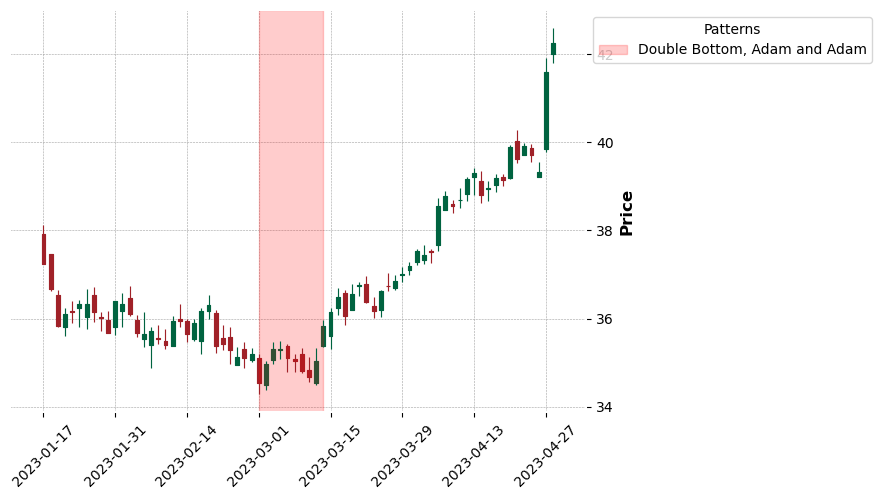

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates

colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'black', 'pink']

# Group by Seg_ID to plot the patterns together
# grouped = test_pattern_segment_wise.head(5).groupby('Seg_ID')
grouped = test_pattern_segment_wise.sample(n=5).groupby('Seg_ID')


# Iterate through each segment group
for seg_id, group in grouped:
    
    # get ohlc data for the symbol
    symbol = group['Symbol'].iloc[0]
    ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')

    # convert the date columns to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]

    # get the ohlc data that is within the segment
    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]   

    if ohcl_data.empty:
        continue
    # Create a candlestick plot using mplfinance
    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()

    ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

    # Re-plot with proper date formatting
    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', 
                        datetime_format='%Y-%m-%d', returnfig=True)


    ax = axes[0]  # Access the first (and only) axis object
    # Loop through the patterns and highlight them on the chart
    color_index = 0
    for index, row in group.iterrows():

        
        pattern_start = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
        pattern_end = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object

        pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
        pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object



        num_of_OHLC_data_points_from_seg_start_to_pattern_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])

        pattern_start = num_of_OHLC_data_points_from_seg_start_to_pattern_start

        num_of_OHLC_data_points_from_pattern_start_to_pattern_end = len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

        pattern_end = pattern_start + num_of_OHLC_data_points_from_pattern_start_to_pattern_end

        pattern_lable = row['Chart Pattern']
        
        # Add a vertical span (highlight the pattern) to the chart
        ax.axvspan(pattern_start, pattern_end,color=colors[color_index], alpha=0.2, label=pattern_lable)
        color_index += 1

    # Customize the chart with grid, labels, and legend
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")

    # Show the chart
    plt.show()


### Draw a segment


In [102]:
    
colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "purple", "orange", "brown", "pink", "lime", "teal"]

def plot_patterns_for_segment(segment_id, test_pattern_segment_wise ,ohcl_data_given=None,padding_days=0,same_color = False, color_pattern_wise = False ,color_cluster_wise = False, legend = True , seg_alpha = 0.2, probability = None , save = False,name = ""):
    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    group = grouped.get_group(segment_id)
    ohcl_data = pd.DataFrame()
    
    if (ohcl_data_given is None):
        # get ohlc data for the symbol
        symbol = group['Symbol'].iloc[0]
        ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')
    else:
        ohcl_data = ohcl_data_given

    # convert the date columns to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]
    
    # Define the padding range (before and after the segment)
    seg_start = seg_start - pd.to_timedelta(padding_days, unit='D')
    seg_end = seg_end + pd.to_timedelta(padding_days, unit='D')

    # get the ohlc data that is within the segment
    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]   

    if (ohcl_data.empty == True):
        print("OHLC Data set is empty ")
    else:
        
        # Create a candlestick plot using mplfinance
        ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()


        # # Create the base plot (this returns a figure and axes)
        # fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', title=f'OHLC Chart with Patterns',
        #                         ylabel='Price', figsize=(12, 6), returnfig=True)  # Set figsize here

        ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

        # Re-plot with proper date formatting
        fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', 
                            datetime_format='%Y-%m-%d', returnfig=True)


        ax = axes[0]  # Access the first (and only) axis object
        # Loop through the patterns and highlight them on the chart
        color_index = 0
        for index, row in group.iterrows():

            
            pattern_start = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
            pattern_end = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object
            
            print('Pattern Name : ', row['Chart Pattern'], 'Pattern Start : ', pattern_start, 'Pattern End : ', pattern_end)

            pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
            pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object



            num_of_OHLC_data_points_from_seg_start_to_pattern_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])

            pattern_start = num_of_OHLC_data_points_from_seg_start_to_pattern_start

            num_of_OHLC_data_points_from_pattern_start_to_pattern_end = len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

            pattern_end = pattern_start + num_of_OHLC_data_points_from_pattern_start_to_pattern_end

            pattern_lable = row['Chart Pattern']
            
            if color_pattern_wise:
                color_index = pattern_encoding[pattern_lable]
            if color_cluster_wise:
                color_index = row['Cluster']
            if same_color:
                color_index = 2
            if save and probability is not None :
                seg_alpha = probability/5
            
            # Add a vertical span (highlight the pattern) to the chart
            ax.axvspan(pattern_start, pattern_end,color=colors[color_index], alpha=seg_alpha, label=pattern_lable)
            
            if not color_pattern_wise:
                color_index += 1

        # Customize the chart with grid, labels, and legend
        ax.grid(True)
        if probability is not None:
            ax.set_title(f'Probability of being a {pattern_lable} : {probability}')
        if legend:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")

        # Show the chart
        plt.show()
        
        if save:
            fig.savefig(f"Samples/{segment_id}_{name}.png")

In [12]:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# get the seg id with the most number of patterns
max_seg_id = 0
max_patterns = 0
for seg_id, group in grouped:
    if len(group) >= max_patterns:
        max_patterns = len(group)
        max_seg_id = seg_id
        print(f"Segment ID: {seg_id} with {len(group)} patterns")

print(f"Segment ID with the most number of patterns: {max_seg_id} with {max_patterns} patterns")

Segment ID: 0 with 1 patterns
Segment ID: 1 with 1 patterns
Segment ID: 2 with 1 patterns
Segment ID: 3 with 1 patterns
Segment ID: 4 with 1 patterns
Segment ID: 5 with 1 patterns
Segment ID: 6 with 1 patterns
Segment ID: 7 with 1 patterns
Segment ID: 8 with 1 patterns
Segment ID: 9 with 1 patterns
Segment ID: 10 with 1 patterns
Segment ID: 11 with 1 patterns
Segment ID: 12 with 1 patterns
Segment ID: 13 with 2 patterns
Segment ID: 25 with 2 patterns
Segment ID: 58 with 2 patterns
Segment ID: 61 with 2 patterns
Segment ID: 64 with 2 patterns
Segment ID: 84 with 2 patterns
Segment ID: 85 with 2 patterns
Segment ID: 96 with 2 patterns
Segment ID: 161 with 2 patterns
Segment ID: 178 with 2 patterns
Segment ID: 179 with 2 patterns
Segment ID: 197 with 2 patterns
Segment ID: 224 with 2 patterns
Segment ID: 234 with 2 patterns
Segment ID: 243 with 2 patterns
Segment ID: 248 with 2 patterns
Segment ID: 260 with 2 patterns
Segment ID: 267 with 2 patterns
Segment ID: 270 with 2 patterns
Segment

## Sliding window Predicting


In [13]:
def normalize_ohlc_segment(dataset):
    # calculate the min values from Low column and max values from High column for each instance
    min_low = dataset['Low'].min()
    max_high = dataset['High'].min()
    
    # OHLC columns to normalize
    ohlc_columns = ['Open', 'High', 'Low', 'Close']
    
    dataset_normalized = dataset.copy()
    
    # Apply the normalization formula to all columns in one go
    dataset_normalized[ohlc_columns] = (dataset_normalized[ohlc_columns] - min_low) / (max_high - min_low)
    
    # if there is a Volume column normalize it
    if 'Volume' in dataset.columns:
        # calculate the min values from Volume column and max values from Volume column for each instance
        min_volume = dataset['Volume'].min()
        max_volume = dataset['Volume'].min()
        
        # Normalize the Volume column
        dataset_normalized['Volume'] = (dataset_normalized['Volume'] - min_volume) / (max_volume - min_volume)
    
    
    return dataset_normalized   

In [14]:
def get_ohlc_data_segment(test_pattern_segment_wise, test_seg_id, path,group):
    seg_id = group['Seg_ID'].iloc[0]

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]

    # Get OHLC data for the symbol
    symbol = group['Symbol'].iloc[0]
    ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')

    # Convert the date column to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    # Filter out the original data within the segment (without padding)
    ohlc_data_segment = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]

    # normalize the data segment
    ohlc_data_segment = normalize_ohlc_segment(ohlc_data_segment)

    ohlc_data_segment.drop('Volume', axis=1, inplace=True)
    
    return ohlc_data_segment



In [15]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import math


def process_window(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion):
    start_index = i - math.ceil(window_size * padding_proportion)
    end_index = start_index + window_size
    if start_index < 0:
        start_index = 0
    if end_index > len(ohlc_data_segment):
        end_index = len(ohlc_data_segment)

    ohlc_segment = ohlc_data_segment[start_index:end_index]
    if len(ohlc_segment) == 0:
        return None  # Skip empty segments

    win_start_date = ohlc_segment['Date'].iloc[0]
    win_end_date = ohlc_segment['Date'].iloc[-1]
    ohlc_array_for_rocket = ohlc_segment[['Open', 'High', 'Low', 'Close']].to_numpy().reshape(1, len(ohlc_segment), 4)
    ohlc_array_for_rocket = np.transpose(ohlc_array_for_rocket, (0, 2, 1))

    pattern_probabilities = rocket_model.predict_proba(ohlc_array_for_rocket)
    max_probability = np.max(pattern_probabilities)
    # print(f"Predicted Pattern: {pattern_encoding_reversed[np.argmax(pattern_probabilities)]} with probability: {max_probability} in num {i} window")
    # if max_probability > probability_threshold:
    pattern_index = np.argmax(pattern_probabilities)
    new_row = {
        'Seg_ID': seg_id, 'Start': win_start_date, 'End': win_end_date, 
        'Symbol': symbol, 'Chart Pattern': pattern_encoding_reversed[pattern_index], 
        'Seg_Start': seg_start, 'Seg_End': seg_end ,'Probability': max_probability
    }
    # plot_patterns_for_segment(test_seg_id, pd.DataFrame([new_row]), ohlc_data_segment)
    return new_row
    # return None



def parallel_process_sliding_window(ohlc_data_segment, rocket_model, probability_threshold, stride, pattern_encoding_reversed, group, test_seg_id, window_size, padding_proportion):
    seg_id = group['Seg_ID'].iloc[0]
    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]
    symbol = group['Symbol'].iloc[0]

    num_cores = -1  # Use all available cores

    # Use Parallel as a context manager to ensure cleanup
    with Parallel(n_jobs=num_cores, verbose=10) as parallel:
        results = parallel(
            delayed(process_window)(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion)
            for i in range(0, len(ohlc_data_segment), stride)
        )

    # Filter out None values and create DataFrame
    win_results_df = pd.DataFrame([res for res in results if res is not None])

    return win_results_df


In [97]:
def plot_sliding_steps(win_results_df, ohlc_data_segment, probability_threshold, test_seg_id,save = False):
    # loop through each row of the win_results_df and add plot  
    for index, row in win_results_df.iterrows():
        print(f"Predicted Pattern: {row['Chart Pattern']} with probability: {row['Probability']} in num {index} window")
        if row['Probability'] > probability_threshold:
            plot_patterns_for_segment(test_seg_id, pd.DataFrame([row]), ohlc_data_segment, color_pattern_wise=True,probability = row['Probability'], save = save,name = f"{index}")
            


In [17]:
# # iterate through the padded_ohlc_data rows by 50 rows a time
# import math

# window_size = 30
# padding_proportion = 0.85
# stride = 1
# probability_threshold = 0.75

# # create a data frame with Seg_ID,Start,End,Symbol,Chart Pattern columns to store the results of each window
# win_results_df = pd.DataFrame(columns=['Seg_ID', 'Start', 'End', 'Symbol', 'Chart Pattern','Seg_Start','Seg_End'])

# for i in range(0, len(ohlc_data_segment), stride):
#     start_index  = i - math.ceil(window_size * padding_proportion)
#     end_index = start_index + window_size
#     # print(f"Before : Start Index: {start_index}, End Index: {end_index}")
#     if start_index < 0:
#         start_index = 0
#     if end_index > len(ohlc_data_segment):
#         end_index = len(ohlc_data_segment)

#     # print(f"After : Start Index: {start_index}, End Index: {end_index}")        
#     ohlc_segment = ohlc_data_segment[start_index:end_index]
#     win_start_date = ohlc_segment['Date'].iloc[0]
#     win_end_date = ohlc_segment['Date'].iloc[-1]
#     ohlc_array_for_rocket = ohlc_segment[['Open', 'High', 'Low', 'Close']].to_numpy().reshape(1, len(ohlc_segment), 4)
#     ohlc_array_for_rocket = np.transpose(ohlc_array_for_rocket, (0, 2, 1))
#     pattern_probabilities = rocket_model.predict_proba(ohlc_array_for_rocket)
#     #  get the max probability 
#     max_probability = np.max(pattern_probabilities)
#     win_pred_list = []
    
#     # print the pattern, randge and the max probability then erase it in the next iteration
#     print(f"Predicted Pattern: {pattern_encoding_reversed[np.argmax(pattern_probabilities)]} with probability: {max_probability} in num {i} window")
#     if max_probability > probability_threshold:
#         # get the index of the max probability
#         pattern_index = np.argmax(pattern_probabilities)
#         # print(f"Predicted Pattern: {pattern_encoding_reversed[pattern_index]} with probability: {max_probability} in {i/5}th window")
#         # create a new row for the win_results_df
#         new_row = {'Seg_ID': seg_id, 'Start': win_start_date, 'End': win_end_date, 'Symbol': symbol, 'Chart Pattern': pattern_encoding_reversed[pattern_index], 'Seg_Start': seg_start, 'Seg_End': seg_end}
#         # convert the row to a datafram
#         new_row_df = pd.DataFrame([new_row])
#         plot_patterns_for_segment(test_seg_id, new_row_df , ohlc_data_segment)
#         win_pred_list.append(new_row)
    
#     win_results_df = pd.concat([win_results_df, pd.DataFrame(win_pred_list)], ignore_index=True)
        
    

## Cluster windows of each pattern


In [18]:
def prepare_dataset_for_cluster(ohlc_data_segment, win_results_df):

    predicted_patterns = win_results_df.copy()
    origin_date = ohlc_data_segment['Date'].min()
    for index, row in predicted_patterns.iterrows():
        pattern_start = row['Start']
        pattern_end = row['End']
        
        #  get the number of OHLC data points from the origin date to the pattern start date
        start_point_index = len(ohlc_data_segment[ohlc_data_segment['Date'] < pattern_start])
        pattern_len = len(ohlc_data_segment[(ohlc_data_segment['Date'] >= pattern_start) & (ohlc_data_segment['Date'] <= pattern_end)])
        
        pattern_mid_index = start_point_index + (pattern_len / 2)
        
        # add the center index to a new column Center in the predicted_patterns current row
        predicted_patterns.at[index, 'Center'] = pattern_mid_index
        predicted_patterns.at[index, 'Pattern_Start_pos'] = start_point_index
        predicted_patterns.at[index, 'Pattern_End_pos'] = start_point_index + pattern_len

    return predicted_patterns
    

### DB Scan & Intersection


In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

def cluster_windows(predicted_patterns , probability_threshold, window_size):
    df = predicted_patterns.copy()

    # only get the rows that has a probability greater than the probability threshold
    df = df[df['Probability'] > probability_threshold]

    # Initialize a list to store merged clusters from all groups
    cluster_labled_windows = []
    interseced_clusters = []

    # Group by 'Chart Pattern' and apply clustering to each group
    for pattern, group in df.groupby('Chart Pattern'):
        # print (pattern)
        # print(group)
        # Clustering
        centers = group['Center'].values.reshape(-1, 1)
        eps  =window_size/2 + 4
        db = DBSCAN(eps=eps, min_samples=2).fit(centers)
        group['Cluster'] = db.labels_
        
        cluster_labled_windows.append(group)
        
        # Filter out noise (-1) and group by Cluster
        for cluster_id, cluster_group in group[group['Cluster'] != -1].groupby('Cluster'):

            
            expanded_dates = []
            for _, row in cluster_group.iterrows():
                # Print the start and end dates for debugging
                dates = pd.date_range(row["Start"], row["End"])
                expanded_dates.extend(dates)

            # print("Total expanded dates:", len(expanded_dates))


            # Step 2: Count occurrences of each date
            date_counts = pd.Series(expanded_dates).value_counts().sort_index()

            # Step 3: Identify cluster start and end (where at least 2 windows overlap)
            cluster_start = date_counts[date_counts >= 2].index.min()
            cluster_end = date_counts[date_counts >= 2].index.max()
            
            interseced_clusters.append({
                'Seg_ID' : cluster_group['Seg_ID'].iloc[0],
                'Symbol' : cluster_group['Symbol'].iloc[0],
                'Chart Pattern': pattern,
                'Cluster': cluster_id,
                'Start': cluster_start,
                'End': cluster_end,
                'Seg_Start': cluster_group['Seg_Start'].iloc[0],
                'Seg_End': cluster_group['Seg_End'].iloc[0]
            })

    if len(cluster_labled_windows) == 0 or len(interseced_clusters) == 0:
        return None,None
    # # Combine all merged clusters into a final DataFrame
    cluster_labled_windows_df = pd.concat(cluster_labled_windows)
    interseced_clusters_df = pd.DataFrame(interseced_clusters)

    # sort by the index 
    cluster_labled_windows_df = cluster_labled_windows_df.sort_index()
    # print(cluster_labled_windows_df)
    # Display the result
    # print(merged_df)
    return cluster_labled_windows_df,interseced_clusters_df



### Functional Pattern Filter and Point recognition


In [20]:
from scipy.signal import find_peaks

def calc_head_and_sholder_top(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    # Find valleys (local minima) by inverting the low prices
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    
    # create a list of dates for peaks and valleys
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    

    if len(peak_indices) < 3 or len(valley_indices) < 2:
        print("Not enough peaks and valleys to form a Head & Shoulders pattern.")
        return
    
    try:
        H_index = np.argmax(high_prices[peak_indices])
        H = peak_indices[H_index]
        LS_index = np.argmax(high_prices[peak_indices[0:H_index]])
        LS = peak_indices[LS_index]
        RS_index = np.argmax(high_prices[peak_indices[H_index+1:]]) + H_index + 1
        RS = peak_indices[RS_index]

        vally_left = valley_indices[(valley_indices > LS) & (valley_indices < H)]
        vally_right = valley_indices[(valley_indices > H) & (valley_indices < RS)]
        NL1 = vally_left[np.argmin(low_prices[vally_left])]
        NL2 = vally_right[np.argmin(low_prices[vally_right])]
        
        # Ensure the middle peak is the highest
        if high_prices[H] <= max(high_prices[LS], high_prices[RS]):
            print("Not a valid Head & Shoulders pattern.")
            return
        
        LS_date = ohlc_data_pattern_segment['Date'].iloc[LS]
        H_date = ohlc_data_pattern_segment['Date'].iloc[H]
        RS_date = ohlc_data_pattern_segment['Date'].iloc[RS]
        NL1_date = ohlc_data_pattern_segment['Date'].iloc[NL1]
        NL2_date = ohlc_data_pattern_segment['Date'].iloc[NL2]
        
        # add the dates to the row
        row['HS_Left_Shoulder'] = LS_date
        row['HS_Head'] = H_date
        row['HS_Right_Shoulder'] = RS_date
        row['HS_Neckline_1'] = NL1_date
        row['HS_Neckline_2'] = NL2_date
        row['Peak_Dates'] = peak_dates
        row['Valley_Dates'] = valley_dates
        row['Calc_Start'] = LS_date
        row['Calc_End'] = RS_date
        
        return row
    except:
        print("Error in finding the peaks or valleys in the Head and Shoulders pattern")
        return

def calc_head_and_shoulder_bottom(row, ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1  

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 3 or len(peak_indices) < 2:
        print("Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.")
        return

    try:
        H_index = np.argmin(low_prices[valley_indices])  # Find lowest valley (Head)
        H = valley_indices[H_index]
        LS_index = np.argmin(low_prices[valley_indices[0:H_index]])
        LS = valley_indices[LS_index]
        RS_index = np.argmin(low_prices[valley_indices[H_index+1:]]) + H_index + 1
        RS = valley_indices[RS_index]

        peak_left = peak_indices[(peak_indices > LS) & (peak_indices < H)]
        peak_right = peak_indices[(peak_indices > H) & (peak_indices < RS)]
        NL1 = peak_left[np.argmax(high_prices[peak_left])]
        NL2 = peak_right[np.argmax(high_prices[peak_right])]

        # Ensure the middle valley is the lowest
        if low_prices[H] >= min(low_prices[LS], low_prices[RS]):
            print("Not a valid Head & Shoulders Bottom pattern.")
            return
        
        LS_date = ohlc_data_pattern_segment['Date'].iloc[LS]
        H_date = ohlc_data_pattern_segment['Date'].iloc[H]
        RS_date = ohlc_data_pattern_segment['Date'].iloc[RS]
        NL1_date = ohlc_data_pattern_segment['Date'].iloc[NL1]
        NL2_date = ohlc_data_pattern_segment['Date'].iloc[NL2]

        # Add the detected pattern data to the row
        row['HS_Left_Shoulder'] = LS_date
        row['HS_Head'] = H_date
        row['HS_Right_Shoulder'] = RS_date
        row['HS_Neckline_1'] = NL1_date
        row['HS_Neckline_2'] = NL2_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = LS_date
        row['Calc_End'] = RS_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern")
        return

def calc_double_top_aa(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    # Find valleys (local minima) by inverting the low prices
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    
    # create a list of dates for peaks and valleys
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    

    if len(peak_indices) < 2 or len(valley_indices) < 1:
        print("Not enough peaks and valleys to form a Double Top pattern.")
        return
    
    try:
        H1_index = np.argmax(high_prices[peak_indices])
        H1 = peak_indices[H1_index]
        H2_index = np.argmax(high_prices[peak_indices[H1_index+1:]]) + H1_index + 1
        H2 = peak_indices[H2_index]
        # get v index that is between H1 and H2
        valley_indices_between_H1_H2 = valley_indices[(valley_indices > H1) & (valley_indices < H2)]
        V = valley_indices_between_H1_H2[np.argmax(low_prices[ valley_indices_between_H1_H2])]
        
        # # Ensure the middle peak is the highest
        # if high_prices[H1] <= high_prices[H2]:
        #     print("Not a valid Double Top pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        V_date = ohlc_data_pattern_segment['Date'].iloc[V]
        
        # add the dates to the row
        row['DT_Peak_1'] = H1_date
        row['DT_Peak_2'] = H2_date
        row['DT_Valley'] = V_date
        row['Peak_Dates'] = peak_dates
        row['Valley_Dates'] = valley_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date
        
        return row
    except:
        print("Error in finding the peaks or valleys in the Double Top pattern")
        return
    
def calc_double_bottom_aa(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.05 

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 2 or len(peak_indices) < 1:
        print("Not enough valleys and peaks to form a Double Bottom pattern.")
        return

    try:
        H1_index = np.argmin(low_prices[valley_indices])
        H1 = valley_indices[H1_index]
        H2_index = np.argmin(low_prices[valley_indices[H1_index+1:]]) + H1_index + 1
        H2 = valley_indices[H2_index]
        # get v index that is between H1 and H2
        peak_indices_between_H1_H2 = peak_indices[(peak_indices > H1) & (peak_indices < H2)]
        P = peak_indices_between_H1_H2[np.argmax(high_prices[ peak_indices_between_H1_H2])]
        
        # # Ensure the middle valley is the lowest
        # if low_prices[H1] >= low_prices[H2]:
        #     print("Not a valid Double Bottom pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        P_date = ohlc_data_pattern_segment['Date'].iloc[P]
        
        # Add the detected pattern data to the row
        row['DB_Valley_1'] = H1_date
        row['DB_Valley_2'] = H2_date
        row['DB_Peak'] = P_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Double Bottom pattern")
        return
    
def calc_double_bottom_ea(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    round_vallies,_ = find_peaks(-low_prices, prominence=0.01,width=3,threshold=0.01)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 2 or len(peak_indices) < 1:
        print("Not enough valleys and peaks to form a Double Bottom pattern.")
        return

    try:
        H1_index = np.argmin(low_prices[round_vallies])
        H1 = valley_indices[H1_index]
        H2_index = np.argmin(low_prices[valley_indices[H1_index+1:]]) + H1_index + 1
        H2 = valley_indices[H2_index]
        # get v index that is between H1 and H2
        peak_indices_between_H1_H2 = peak_indices[(peak_indices > H1) & (peak_indices < H2)]
        P = peak_indices_between_H1_H2[np.argmax(high_prices[ peak_indices_between_H1_H2])]
        
        # # Ensure the middle valley is the lowest
        # if low_prices[H1] >= low_prices[H2]:
        #     print("Not a valid Double Bottom pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        P_date = ohlc_data_pattern_segment['Date'].iloc[P]
        
        # Add the detected pattern data to the row
        row['DB_Valley_1'] = H1_date
        row['DB_Valley_2'] = H2_date
        row['DB_Peak'] = P_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Double Bottom pattern")
        return

In [21]:
def functional_pattern_filter_and_point_recognition(interseced_clusters_df):
    located_patterns_and_other_info_rows = []

    # iterate through each row of the interseced_clusters_df 
    for index, row in interseced_clusters_df.iterrows():
        pattern = row['Chart Pattern']
        symbol = row['Symbol']
        ohlc_data_for_symbol = pd.read_csv(path + '/' + symbol + '.csv')
        # convert the date columns to datetime
        ohlc_data_for_symbol['Date'] = pd.to_datetime(ohlc_data_for_symbol['Date'])
        ohlc_data_for_symbol['Date'] = ohlc_data_for_symbol['Date'].dt.tz_localize(None)
        
        # get the ohlc data that is within the segment
        ohlc_data_pattern_segment = ohlc_data_for_symbol[(ohlc_data_for_symbol['Date'] >= row['Start']) & (ohlc_data_for_symbol['Date'] <= row['End'])]
        # reset the index of the ohlc_data_pattern_segment
        ohlc_data_pattern_segment.reset_index(drop=True, inplace=True)
        
        
        
        # write a switch case for each pattern
        if pattern == 'Double Top, Adam and Adam':
            updated_row = calc_double_top_aa(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Triangle, symmetrical':
            # TODO: Implement the symmetrical triangle pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Double Bottom, Eve and Adam':
            updated_row = calc_double_bottom_ea(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
                
            
        elif pattern == 'Head-and-shoulders top':
            updated_row = calc_head_and_sholder_top(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Double Bottom, Adam and Adam':
            updated_row = calc_double_bottom_aa(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Head-and-shoulders bottom':
            updated_row = calc_head_and_shoulder_bottom(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Flag, high and tight':
            # TODO: Implement the high and tight flag pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Cup with handle':
            # TODO : Implement the cup with handle pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        else:
            print("Pattern not found")

    located_patterns_and_other_info = pd.DataFrame(located_patterns_and_other_info_rows)
    return located_patterns_and_other_info




In [22]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

pattern_encoding = {'Double Top, Adam and Adam': 0, 'Triangle, symmetrical': 1, 'Double Bottom, Eve and Adam': 2, 'Head-and-shoulders top': 3, 'Double Bottom, Adam and Adam': 4, 'Head-and-shoulders bottom': 5, 'Flag, high and tight': 6, 'Cup with handle': 7}


def draw_head_and_shoulders_top(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Head and Shoulders pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    calc_start_date = row['Calc_Start']
    calc_end_date = row['Calc_End']
    
    calc_start_idx = ohlc_data[ohlc_data['Date']== calc_start_date].index
    calc_end_idx = ohlc_data[ohlc_data['Date']== calc_end_date].index
    
    # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
    ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)
    
    LS_idx = ohlc_data[ohlc_data['Date']== row['HS_Left_Shoulder']].index
    H_idx = ohlc_data[ohlc_data['Date']== row['HS_Head']].index
    RS_idx = ohlc_data[ohlc_data['Date']== row['HS_Right_Shoulder']].index
    NL1_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_1']].index
    NL2_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_2']].index
    
    # Draw the head and shoulders
    ax.plot([LS_idx, H_idx, RS_idx], [high_prices[LS_idx], high_prices[H_idx], high_prices[RS_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="H&S Pattern")
    
    # Use NL1_idx and NL2_idx as the x-range to keep the line within bounds
    x_min, x_max = min(NL1_idx, NL2_idx), max(NL1_idx, NL2_idx)

    # Compute the y-values using the line equation (y = mx + c)
    slope = (low_prices[NL2_idx] - low_prices[NL1_idx]) / (NL2_idx - NL1_idx)
    y_min = low_prices[NL1_idx] + slope * (x_min - NL1_idx)
    y_max = low_prices[NL1_idx] + slope * (x_max - NL1_idx)

    # Plot the line within the original graph size
    ax.plot([x_min, x_max], [y_min, y_max], 
            linestyle="dashed", color="red", linewidth=1, label="Neckline")




    
    

def draw_head_and_shoulders_bottom(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Head and Shoulders pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    calc_start_date = row['Calc_Start']
    calc_end_date = row['Calc_End']
    
    calc_start_idx = ohlc_data[ohlc_data['Date']== calc_start_date].index
    calc_end_idx = ohlc_data[ohlc_data['Date']== calc_end_date].index
    
    # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
    ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)
    
    
    LS_idx = ohlc_data[ohlc_data['Date']== row['HS_Left_Shoulder']].index
    H_idx = ohlc_data[ohlc_data['Date']== row['HS_Head']].index
    RS_idx = ohlc_data[ohlc_data['Date']== row['HS_Right_Shoulder']].index
    NL1_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_1']].index
    NL2_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_2']].index
    
    # Draw the head and shoulders
    ax.plot([LS_idx, H_idx, RS_idx], [low_prices[LS_idx], low_prices[H_idx], low_prices[RS_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="H&S Pattern")
    
    # Use NL1_idx and NL2_idx as the x-range to keep the line within bounds
    x_min, x_max = min(NL1_idx, NL2_idx), max(NL1_idx, NL2_idx)

    # Compute the y-values using the line equation (y = mx + c)
    slope = (high_prices[NL2_idx] - high_prices[NL1_idx]) / (NL2_idx - NL1_idx)
    y_min = high_prices[NL1_idx] + slope * (x_min - NL1_idx)
    y_max = high_prices[NL1_idx] + slope * (x_max - NL1_idx)

    # Plot the line within the original graph size
    ax.plot([x_min, x_max], [y_min, y_max], 
            linestyle="dashed", color="red", linewidth=1, label="Neckline")


    
def draw_double_top_aa(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Double Top pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    

    
    DT_Peak_1_idx = ohlc_data[ohlc_data['Date']== row['DT_Peak_1']].index
    DT_Peak_2_idx = ohlc_data[ohlc_data['Date']== row['DT_Peak_2']].index
    DT_Valley_idx = ohlc_data[ohlc_data['Date']== row['DT_Valley']].index
    
    # draw the double peaks
    ax.plot([DT_Peak_1_idx,DT_Valley_idx, DT_Peak_2_idx], [high_prices[DT_Peak_1_idx],high_prices[DT_Valley_idx], high_prices[DT_Peak_2_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="Double Top Pattern")
    # Draw the neckline
    ax.hlines(y=low_prices[DT_Valley_idx], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='red', linestyle='dotted', linewidth=1)

def draw_double_bottom_aa(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Double Bottom pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    DB_Valley_1_idx = ohlc_data[ohlc_data['Date']== row['DB_Valley_1']].index
    DB_Valley_2_idx = ohlc_data[ohlc_data['Date']== row['DB_Valley_2']].index
    DB_Peak_idx = ohlc_data[ohlc_data['Date']== row['DB_Peak']].index
    
    # draw the double peaks
    ax.plot([DB_Valley_1_idx,DB_Peak_idx, DB_Valley_2_idx], [low_prices[DB_Valley_1_idx],low_prices[DB_Peak_idx], low_prices[DB_Valley_2_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="Double Bottom Pattern")
    # Draw the neckline
    ax.hlines(y=high_prices[DB_Peak_idx], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='red', linestyle='dotted', linewidth=1)

def plot_pattern_clusters(segment_id, test_pattern_segment_wise, ohcl_data_given=None, padding_days=0,draw_lines = False):
    colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "purple", "orange", "brown", "pink", "lime", "teal"]

    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    group = grouped.get_group(segment_id)
    
    if ohcl_data_given is None:
        symbol = group['Symbol'].iloc[0]
        ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')
    else:
        ohcl_data = ohcl_data_given

    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0] - pd.to_timedelta(padding_days, unit='D')
    seg_end = group['Seg_End'].iloc[0] + pd.to_timedelta(padding_days, unit='D')

    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]
    if ohcl_data.empty:
        print("OHLC Data set is empty")
        return

    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()
    ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', datetime_format='%Y-%m-%d', returnfig=True)
    ax = axes[0]

    for _, row in group.iterrows():
        pattern_name = row['Chart Pattern']
        cluster = row['Cluster']
        color = "gray" if cluster == -1 else colors[cluster]

        pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)
        pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)

        num_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])
        num_end = num_start + len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

        ax.axvspan(num_start, num_end, color=color, alpha=0.1, label=pattern_name)
        

        if draw_lines:
            # error = row['Error'] check only if the column is present
            error = False
            if 'Error' in row and row['Error'] != np.nan:
                error = row['Error']
            if error != True:
                calc_start_date = row['Calc_Start']
                calc_end_date = row['Calc_End']
                
                # reset the index of the ohlc_data
                ohcl_data.reset_index(drop=True, inplace=True)
                
                calc_start_idx = ohcl_data[ohcl_data['Date']== calc_start_date].index
                calc_end_idx = ohcl_data[ohcl_data['Date']== calc_end_date].index
                
                # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
                ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
                ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)

                # If detected pattern is Head and Shoulders, plot indicator lines
                if pattern_name == "Head-and-shoulders top":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_head_and_sholder = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_head_and_shoulders_top(ax, ohcl_data, num_start,row)
                elif pattern_name == "Head-and-shoulders bottom":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_head_and_sholder = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_head_and_shoulders_bottom(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Top, Adam and Adam":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_top_aa(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Bottom, Adam and Adam":
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_bottom_aa(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Bottom, Eve and Adam":
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_bottom_aa(ax, ohcl_data, num_start,row)
    
    
    if draw_lines:    
        # Get unique legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        unique_handles = []
        
        pattern_encoding = ['Double Top, Adam and Adam', 'Triangle, symmetrical', 'Double Bottom, Eve and Adam', 'Head-and-shoulders top', 'Double Bottom, Adam and Adam', 'Head-and-shoulders bottom', 'Flag, high and tight', 'Cup with handle']


        # Initialize storage for unique handles/labels
        unique_labels = {}
        unique_handles = []
        i= 1
        
        for handle, label in zip(handles, labels):
            # print(label)
            
            # Allow duplication if the label is in pattern_encoding
            if label in pattern_encoding or label not in unique_labels:
                if label not in unique_labels:
                    unique_labels[label] = handle
                    unique_handles.append(handle)
                else:
                    unique_labels[label + f"_{i}"] = handle
                    unique_handles.append(handle)
                    i += 1
                    

        ax.legend(unique_handles, unique_labels.keys())



    ax.grid(True)
    plt.show()


In [23]:
# pattern = 'Head-and-shoulders top'
# cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == pattern]

In [24]:
def plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, test_seg_id):
    # for each unique Chart Pattern in located_patterns_and_other_info plot the patterns
    for pattern, group in located_patterns_and_other_info.groupby('Chart Pattern'):
        # pattern = 'Head-and-shoulders top'
        print (pattern ," :")
        print("    Clustered Windows :")
        plot_pattern_clusters(test_seg_id, cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == pattern])
        print("    Finalized Section :")
        plot_pattern_clusters(test_seg_id, located_patterns_and_other_info[located_patterns_and_other_info['Chart Pattern'] == pattern],draw_lines=True)



# Loop Through All the segments


In [25]:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# get the seg id with the most number of patterns
max_seg_id = 0
max_patterns = 0
for seg_id, group in grouped:
    if len(group) >= max_patterns:
        max_patterns = len(group)
        max_seg_id = seg_id
        print(f"Segment ID: {seg_id} with {len(group)} patterns")

print(f"Segment ID with the most number of patterns: {max_seg_id} with {max_patterns} patterns")

Segment ID: 0 with 1 patterns
Segment ID: 1 with 1 patterns
Segment ID: 2 with 1 patterns
Segment ID: 3 with 1 patterns
Segment ID: 4 with 1 patterns
Segment ID: 5 with 1 patterns
Segment ID: 6 with 1 patterns
Segment ID: 7 with 1 patterns
Segment ID: 8 with 1 patterns
Segment ID: 9 with 1 patterns
Segment ID: 10 with 1 patterns
Segment ID: 11 with 1 patterns
Segment ID: 12 with 1 patterns
Segment ID: 13 with 2 patterns
Segment ID: 25 with 2 patterns
Segment ID: 58 with 2 patterns
Segment ID: 61 with 2 patterns
Segment ID: 64 with 2 patterns
Segment ID: 84 with 2 patterns
Segment ID: 85 with 2 patterns
Segment ID: 96 with 2 patterns
Segment ID: 161 with 2 patterns
Segment ID: 178 with 2 patterns
Segment ID: 179 with 2 patterns
Segment ID: 197 with 2 patterns
Segment ID: 224 with 2 patterns
Segment ID: 234 with 2 patterns
Segment ID: 243 with 2 patterns
Segment ID: 248 with 2 patterns
Segment ID: 260 with 2 patterns
Segment ID: 267 with 2 patterns
Segment ID: 270 with 2 patterns
Segment

Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-14 00:00:00 Pattern End :  2023-05-01 00:00:00
Pattern Name :  Double Bottom, Adam and Adam Pattern Start :  2023-02-24 00:00:00 Pattern End :  2023-03-01 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-27 00:00:00 Pattern End :  2023-02-09 00:00:00


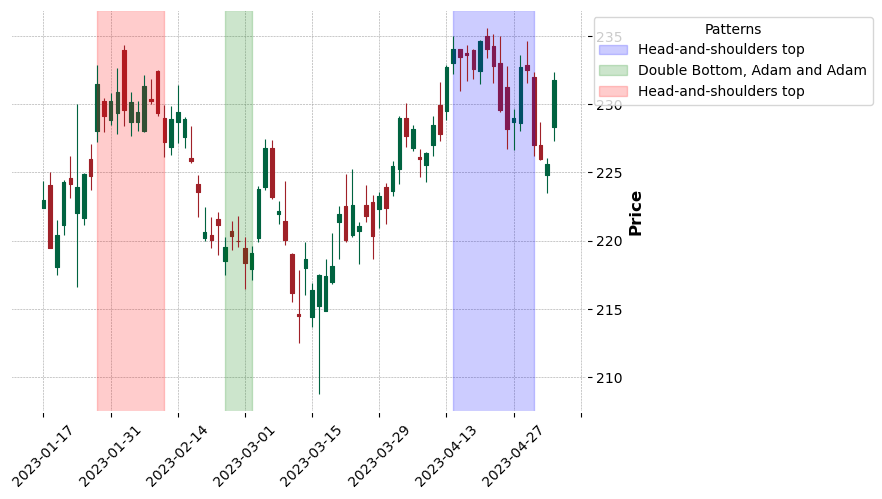

In [69]:
test_seg_id = 377                
plot_patterns_for_segment(test_seg_id    , test_pattern_segment_wise)

In [27]:
# load the pipelined model
import os
import joblib

# window_size = 20
win_size_proportion = 5
padding_proportion = 0.6
stride = 1
probability_threshold = 0.65


model_save_dir = ''
multi_rocket_model = joblib.load(os.path.join(model_save_dir, "multi_rocket_model.pkl"))
rocket_model = joblib.load("rocket_model.pkl")

In [29]:
seg_ids= [380,363]

located_patterns_and_other_info_list = []
window_results_list = []

for seg_id, group in tqdm(grouped, desc="Processing segments"):
    
    test_seg_id = seg_id  
# for test_seg_id in tqdm(seg_ids, desc="Processing test segments"):
    try :
        # plot_patterns_for_segment(test_seg_id    , test_pattern_segment_wise)
        grouped = test_pattern_segment_wise.groupby('Seg_ID')
        # Select a group
        group = grouped.get_group(test_seg_id)

        Seg_Start = group.iloc[0]['Seg_Start']
        Seg_End = group.iloc[0]['Seg_End']
        seg_len = (Seg_End - Seg_Start).days

        window_size = seg_len // win_size_proportion
        if window_size < 10:
            window_size = 10
        elif window_size > 30:
            window_size = 30
            
        ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, test_seg_id, path,group) 
        if ohlc_data_segment is None:
            print("OHLC Data segment is empty")
            continue   
        win_results_df = parallel_process_sliding_window(ohlc_data_segment, rocket_model, probability_threshold,stride, pattern_encoding_reversed,group,test_seg_id,window_size, padding_proportion)
        if win_results_df is None:
            print("Window results dataframe is empty")
            continue
        window_results_list.append(win_results_df)
        # plot_sliding_steps(win_results_df ,ohlc_data_segment,probability_threshold ,test_seg_id)
        predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_results_df)
        if predicted_patterns is None:
            print("Predicted patterns dataframe is empty")
        cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
        if cluster_labled_windows_df is None or interseced_clusters_df is None:
            print("Clustered windows dataframe is empty")
            continue
        located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
        if located_patterns_and_other_info is None:
            print("Located patterns and other info dataframe is empty")
            continue
        # plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, test_seg_id)
        
        located_patterns_and_other_info_list.append(located_patterns_and_other_info)
    except:
        print("Error in segment ID: ",test_seg_id)
        continue

located_patterns_and_other_info_final_df = pd.concat(located_patterns_and_other_info_list)
window_results_all_df = pd.concat(window_results_list)

Processing segments:   0%|          | 0/405 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  85 out of 105 | elapsed:   54.1s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  96 out of 105 | elapsed:   59.3s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.0min finished
Processing segments:   0%|          | 1/405 [01:02<6:58:04, 62.09s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   32.7s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   37.8s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   40.0s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   41.7s finished
Processing segments:   0%|          | 2/405 [01:44<5:37:21, 50.23s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   32.7s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   35.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   39.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   40.8s finished
Processing segments:   1%|          | 3/405 [02:25<5:08:26, 46.03s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   36.2s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   41.0s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   43.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   44.7s finished
Processing segments:   1%|          | 4/405 [03:09<5:04:41, 45.59s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   34.8s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   41.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   44.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   45.0s finished
Processing segments:   1%|          | 5/405 [03:55<5:03:06, 45.47s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   31.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   34.0s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   38.9s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   39.7s finished
Processing segments:   1%|▏         | 6/405 [04:35<4:49:41, 43.56s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   33.1s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   36.8s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   40.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   41.8s finished
Processing segments:   2%|▏         | 7/405 [05:17<4:45:42, 43.07s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.9s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
Processing segments:   2%|▏         | 8/405 [05:21<3:22:45, 30.64s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   32.6s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   37.4s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   40.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   42.4s finished
Processing segments:   2%|▏         | 9/405 [06:03<3:46:55, 34.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  69 out of  90 | elapsed:   41.5s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  79 out of  90 | elapsed:   47.4s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   49.9s finished
Processing segments:   2%|▏         | 10/405 [06:53<4:18:20, 39.24s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   37.7s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   42.4s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   45.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   45.9s finished
Processing segments:   3%|▎         | 11/405 [07:39<4:31:26, 41.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   35.5s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   40.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   44.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   45.1s finished
Processing segments:   3%|▎         | 12/405 [08:25<4:38:47, 42.56s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:    7.7s remaining:   57.0s
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:    7.9s remaining:   25.2s
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:    8.2s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:    8.3s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   10.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   13.8s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   13.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.1s finished
Processing segments:   3%|▎         | 13/405 [08:39<3:42:02, 33.99s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   32.9s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   37.1s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   40.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   42.6s finished
Processing segments:   3%|▎         | 14/405 [09:22<3:58:55, 36.66s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   31.8s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   35.2s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:   39.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   40.9s finished
Processing segments:   4%|▎         | 15/405 [10:03<4:07:02, 38.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Double Bottom pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  91 out of 110 | elapsed:   53.6s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done 103 out of 110 | elapsed:  1.0min remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  1.0min finished
Processing segments:   4%|▍         | 16/405 [11:05<4:52:10, 45.06s/it]

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   37.4s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   42.0s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   45.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   46.2s finished
Processing segments:   4%|▍         | 17/405 [11:51<4:54:08, 45.48s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   38.7s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   44.4s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   46.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   48.1s finished
Processing segments:   5%|▍         | 19/405 [13:28<5:01:48, 46.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  72 out of  93 | elapsed:   43.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  82 out of  93 | elapsed:   49.5s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   52.4s finished
Processing segments:   5%|▍         | 20/405 [14:20<5:12:03, 48.63s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 171 out of 183 | elapsed:  1.7min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 183 out of 183 | elapsed:  1.7min finished
Processing segments:   5%|▌         | 21/405 [16:03<6:55:43, 64.96s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:   39.3s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:   43.0s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:   46.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   47.5s finished
Processing segments:   5%|▌         | 22/405 [16:51<6:21:33, 59.77s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  71 out of  92 | elapsed:   43.0s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  81 out of  92 | elapsed:   48.6s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   52.0s finished
Processing segments:   6%|▌         | 23/405 [17:43<6:06:16, 57.53s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  17 out of  43 | elapsed:   15.1s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  22 out of  43 | elapsed:   17.2s remaining:   16.4s
[Parallel(n_jobs=-1)]: Done  27 out of  43 | elapsed:   18.7s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  32 out of  43 | elapsed:   20.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  37 out of  43 | elapsed:   23.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   24.7s finished
Processing segments:   6%|▌         | 24/405 [18:08<5:03:04, 47.73s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.8s
[Par

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   39.5s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   44.4s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   47.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   48.1s finished
Processing segments:   7%|▋         | 27/405 [20:40<5:11:11, 49.39s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   33.7s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   37.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   41.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   43.4s finished
Processing segments:   7%|▋         | 28/405 [21:24<4:59:26, 47.66s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  61 out of  83

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   35.8s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   41.6s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   44.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   44.9s finished
Processing segments:   7%|▋         | 30/405 [22:56<4:52:36, 46.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   35.7s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   40.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   43.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   45.0s finished
Processing segments:   8%|▊         | 31/405 [23:41<4:48:56, 46.35s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   36.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   41.5s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   43.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   45.6s finished
Processing segments:   8%|▊         | 32/405 [24:27<4:47:16, 46.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Not a valid Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   35.3s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   37.4s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   42.9s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   43.7s finished
Processing segments:   8%|▊         | 33/405 [25:11<4:42:17, 45.53s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  64 out of  86 | elapsed:   39.7s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  73 out of  86 | elapsed:   43.2s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  82 out of  86 | elapsed:   47.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   48.3s finished
Processing segments:   8%|▊         | 34/405 [26:00<4:47:03, 46.42s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks     

Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:   29.1s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   35.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   37.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   39.6s finished
Processing segments:   9%|▉         | 36/405 [27:23<4:29:44, 43.86s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   33.7s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   39.6s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   41.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   43.6s finished
Processing segments:   9%|▉         | 37/405 [28:07<4:28:53, 43.84s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   34.6s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   38.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   42.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   43.5s finished
Processing segments:   9%|▉         | 38/405 [28:51<4:27:59, 43.81s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   36.5s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   41.7s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   44.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   45.2s finished
Processing segments:  10%|▉         | 39/405 [29:36<4:30:14, 44.30s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   36.2s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   43.0s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   44.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   47.0s finished
Processing segments:  10%|▉         | 40/405 [30:23<4:34:54, 45.19s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  32 out of  57 | elapsed:   21.6s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done  38 out of  57 | elapsed:   24.8s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  44 out of  57 | elapsed:   28.6s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  50 out of  57 | elapsed:   31.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   32.3s finished
Processing segments:  10%|█         | 41/405 [30:56<4:10:59, 41.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   35.5s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   41.0s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   44.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   45.5s finished
Processing segments:  10%|█         | 42/405 [31:42<4:18:12, 42.68s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   32.5s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   35.2s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   40.0s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   41.2s finished
Processing segments:  11%|█         | 43/405 [32:23<4:15:15, 42.31s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  71 out of  92 | elapsed:   42.7s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  81 out of  92 | elapsed:   49.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   52.1s finished
Processing segments:  11%|█         | 44/405 [33:15<4:32:41, 45.32s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  32 out of  57 | elapsed:   22.3s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  38 out of  57 | elapsed:   24.7s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  44 out of  57 | elapsed:   28.0s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  50 out of  57 | elapsed:   30.9s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   32.4s finished
Processing segments:  11%|█         | 45/405 [33:48<4:09:05, 41.52s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  71 out of  92 | elapsed:   43.5s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  81 out of  92 | elapsed:   48.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   51.8s finished
Processing segments:  11%|█▏        | 46/405 [34:40<4:27:16, 44.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   35.3s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   38.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   43.1s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   44.3s finished
Processing segments:  12%|█▏        | 47/405 [35:25<4:26:22, 44.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:   29.9s remaining:   14.6s
[Parallel(n_jobs=-1)]: 

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   36.9s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   42.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   45.0s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   45.9s finished
Processing segments:  12%|█▏        | 49/405 [36:51<4:22:03, 44.17s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   32.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   37.3s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   40.6s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   42.8s finished
Processing segments:  12%|█▏        | 50/405 [37:34<4:19:14, 43.81s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  49 out of  72

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 103 out of 121 | elapsed:  1.0min remaining:   10.6s
[Parallel(n_jobs=-1)]: Done 116 out of 121 | elapsed:  1.1min remaining:    2.8s
[Parallel(n_jobs=-1)]: Done 121 out of 121 | elapsed:  1.1min finished
Processing segments:  13%|█▎        | 52/405 [39:23<4:57:50, 50.63s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   38.3s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   44.4s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   47.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   48.4s finished
Processing segments:  13%|█▎        | 53/405 [40:12<4:53:42, 50.06s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   32.7s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   37.1s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   40.4s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   42.1s finished
Processing segments:  13%|█▎        | 54/405 [40:55<4:39:24, 47.76s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   32.2s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   37.0s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:   39.9s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   42.2s finished
Processing segments:  14%|█▎        | 55/405 [41:37<4:29:11, 46.15s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   34.2s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   38.5s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   42.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   44.0s finished
Processing segments:  14%|█▍        | 56/405 [42:21<4:25:05, 45.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  72 out of  93 | elapsed:   43.3s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  82 out of  93 | elapsed:   49.7s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   52.8s finished
Processing segments:  14%|█▍        | 57/405 [43:14<4:37:17, 47.81s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   33.1s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   37.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   40.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   42.4s finished
Processing segments:  14%|█▍        | 58/405 [43:57<4:27:31, 46.26s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 152 out of 166 | elapsed:  1.5min remaining:    8.1s
[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:  1.6min finished
Processing segments:  15%|█▍        | 59/405 [45:31<5:49:12, 60.56s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   34.1s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   39.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   41.8s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   44.2s finished
Processing segments:  15%|█▍        | 60/405 [46:15<5:20:24, 55.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   44.6s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   50.3s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   52.7s finished
Processing segments:  15%|█▌        | 61/405 [47:08<5:14:47, 54.90s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  77 out of  98 | elapsed:   47.3s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  87 out of  98 | elapsed:   51.5s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   55.3s finished
Processing segments:  15%|█▌        | 62/405 [48:04<5:14:56, 55.09s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   33.5s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   37.0s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   41.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   42.5s finished
Processing segments:  16%|█▌        | 63/405 [48:46<4:52:51, 51.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   38.0s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   42.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   45.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   46.7s finished
Processing segments:  16%|█▌        | 64/405 [49:33<4:44:26, 50.05s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:   38.1s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:   43.5s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:   46.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   47.7s finished
Processing segments:  16%|█▌        | 65/405 [50:21<4:40:03, 49.42s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   35.1s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   39.7s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   42.9s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   45.0s finished
Processing segments:  16%|█▋        | 66/405 [51:07<4:32:14, 48.19s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   33.7s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   37.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   41.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   42.9s finished
Processing segments:  17%|█▋        | 67/405 [51:50<4:22:56, 46.68s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  43 out of  67 | elapsed:   27.2s remaining:   15.2s
[Parallel(n_jobs=-1)]: 

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  94 out of 113 | elapsed:   56.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done 106 out of 113 | elapsed:  1.1min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:  1.1min finished
Processing segments:  17%|█▋        | 69/405 [53:33<4:41:46, 50.32s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   34.3s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   38.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   42.0s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   43.7s finished
Processing segments:  17%|█▋        | 70/405 [54:17<4:30:11, 48.39s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   32.9s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   38.1s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   40.9s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   43.2s finished
Processing segments:  18%|█▊        | 71/405 [55:00<4:21:02, 46.89s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  53 tasks     

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   37.4s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   40.5s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   45.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   46.6s finished
Processing segments:  18%|█▊        | 73/405 [56:43<4:29:27, 48.70s/it]

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   33.2s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   38.6s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   41.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   44.1s finished
Processing segments:  18%|█▊        | 74/405 [57:27<4:21:25, 47.39s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  87 out of 107 | elapsed:   53.1s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  98 out of 107 | elapsed:   59.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:  1.0min finished
Processing segments:  19%|█▉        | 76/405 [59:49<5:21:35, 58.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  65 out of  87 | elapsed:   41.2s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  74 out of  87 | elapsed:   45.6s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  83 out of  87 | elapsed:   49.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   50.0s finished
Processing segments:  19%|█▉        | 77/405 [1:00:39<5:06:44, 56.11s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  40 tasks   

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   42.6s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   49.2s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   52.0s finished
Processing segments:  20%|█▉        | 79/405 [1:02:26<4:56:44, 54.62s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   33.1s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   37.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   40.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   42.5s finished
Processing segments:  20%|█▉        | 80/405 [1:03:09<4:36:35, 51.06s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  71 out of  92 | elapsed:   43.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  81 out of  92 | elapsed:   49.2s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   51.9s finished
Processing segments:  20%|██        | 81/405 [1:04:01<4:37:27, 51.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   32.0s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   36.6s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:   39.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   41.5s finished
Processing segments:  20%|██        | 82/405 [1:04:43<4:21:03, 48.49s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   43.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   48.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   52.0s finished
Processing segments:  20%|██        | 83/405 [1:05:35<4:26:18, 49.62s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  33 out of  58 | elapsed:   24.3s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  39 out of  58 | elapsed:   25.9s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  45 out of  58 | elapsed:   28.4s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  51 out of  58 | elapsed:   32.1s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   32.9s finished
Processing segments:  21%|██        | 84/405 [1:06:08<3:58:57, 44.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   37.0s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   41.1s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   45.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   45.9s finished
Processing segments:  21%|██        | 86/405 [1:07:56<4:18:41, 48.66s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:   51.7s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:   56.8s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   58.8s finished
Processing segments:  21%|██▏       | 87/405 [1:08:55<4:34:25, 51.78s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   36.6s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   41.7s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   45.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   46.0s finished
Processing segments:  22%|██▏       | 88/405 [1:09:41<4:24:50, 50.13s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  51 out of  

Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  67 out of  89 | elapsed:   41.6s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  76 out of  89 | elapsed:   45.6s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  85 out of  89 | elapsed:   50.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   50.5s finished
Processing segments:  22%|██▏       | 90/405 [1:11:15<4:15:53, 48.74s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  74 out of  95 | elapsed:   45.2s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  84 out of  95 | elapsed:   50.6s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   54.0s finished
Processing segments:  22%|██▏       | 91/405 [1:12:09<4:23:45, 50.40s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:   51.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:   56.6s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   58.6s finished
Processing segments:  23%|██▎       | 92/405 [1:13:08<4:36:07, 52.93s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      |

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  69 out of  90 | elapsed:   43.5s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  79 out of  90 | elapsed:   47.2s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.9s finished
Processing segments:  23%|██▎       | 94/405 [1:14:43<4:22:00, 50.55s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  45 out of  69 | elapsed:   28.1s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  52 out of  

Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   34.0s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   38.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   41.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   43.7s finished
Processing segments:  24%|██▎       | 96/405 [1:16:07<3:59:11, 46.45s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   38.4s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   42.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   46.4s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   47.1s finished
Processing segments:  24%|██▍       | 97/405 [1:16:55<3:59:47, 46.71s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done  83 out of 103 | elapsed:   50.8s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  94 out of 103 | elapsed:   56.6s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:   58.5s finished
Processing segments:  24%|██▍       | 98/405 [1:17:54<4:17:33, 50.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   38.6s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   41.9s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   46.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   46.8s finished
Processing segments:  24%|██▍       | 99/405 [1:18:41<4:11:46, 49.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  88 out of 108 | elapsed:   52.5s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  99 out of 108 | elapsed:   59.2s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.0min finished
Processing segments:  25%|██▍       | 100/405 [1:19:42<4:29:15, 52.97s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26

Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   34.4s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   37.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   42.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   43.7s finished
Processing segments:  25%|██▌       | 102/405 [1:21:08<4:01:43, 47.87s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   41.0s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   45.4s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   49.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   50.1s finished
Processing segments:  25%|██▌       | 103/405 [1:21:58<4:04:40, 48.61s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  72 out of  93 | elapsed:   44.5s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  82 out of  93 | elapsed:   49.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   52.8s finished
Processing segments:  26%|██▌       | 104/405 [1:22:51<4:10:34, 49.95s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  65 out of  87 | elapsed:   41.3s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  74 out of  87 | elapsed:   45.0s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  83 out of  87 | elapsed:   48.8s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   49.3s finished
Processing segments:  26%|██▌       | 105/405 [1:23:40<4:09:06, 49.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   39.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   44.7s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   47.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   49.0s finished
Processing segments:  26%|██▌       | 106/405 [1:24:30<4:07:31, 49.67s/it]

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   38.8s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   43.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   46.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   47.1s finished
Processing segments:  26%|██▋       | 107/405 [1:25:17<4:03:19, 48.99s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   33.4s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   36.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   41.1s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   42.3s finished
Processing segments:  27%|██▋       | 108/405 [1:26:00<3:52:57, 47.06s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  65 out of  87 | elapsed:   42.0s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  74 out of  87 | elapsed:   45.7s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  83 out of  87 | elapsed:   49.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   49.8s finished
Processing segments:  27%|██▋       | 109/405 [1:26:50<3:56:34, 47.95s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   35.1s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   39.4s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   43.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   44.5s finished
Processing segments:  27%|██▋       | 110/405 [1:27:35<3:51:07, 47.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Double Bottom pattern.
Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   37.3s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   43.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   46.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   47.7s finished
Processing segments:  27%|██▋       | 111/405 [1:28:22<3:51:39, 47.28s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   35.0s remaining:   15.1s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   37.2s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   42.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   43.3s finished
Processing segments:  28%|██▊       | 112/405 [1:29:06<3:45:26, 46.16s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   8 out of  35 | elapsed:    8.2s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:    9.7s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:   12.4s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:   16.3s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:   17.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:   18.6s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:   19.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   21.2s finished
Processing segments:  28%|██▊       | 113/405 [1:29:27<3:08:25, 38.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Do

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   42.0s remaining:   14.6s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   48.2s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   50.9s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   52.3s finished
Processing segments:  28%|██▊       | 115/405 [1:31:08<3:36:44, 44.84s/it]

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   40.9s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   44.0s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   48.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   49.5s finished
Processing segments:  29%|██▊       | 116/405 [1:31:58<3:43:04, 46.31s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  81 out of 101 | elapsed:   52.0s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  92 out of 101 | elapsed:   56.4s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  1.0min finished
Processing segments:  29%|██▉       | 117/405 [1:32:58<4:02:26, 50.51s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:   54.5s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  1.0min remaining:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
Processing segments:  29%|██▉       | 118/405 [1:34:03<4:21:53, 54.75s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   42.3s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   50.6s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   57.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   59.8s finished
Processing segments:  29%|██▉       | 119/405 [1:35:03<4:28:52, 56.41s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed:   40.7s remaining:   27.1s
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:   48.8s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:   53.6s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   58.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished
Processing segments:  30%|██▉       | 120/405 [1:36:05<4:35:52, 58.08s/it]

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:  1.1min remaining:   22.8s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:  1.3min remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:  1.4min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  1.4min finished
Processing segments:  30%|██▉       | 121/405 [1:37:29<5:11:01, 65.71s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: D

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   55.2s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:  1.1min remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:  1.1min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:  1.3min finished
Processing segments:  30%|███       | 123/405 [1:40:08<5:40:54, 72.54s/it]

Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   55.3s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:  1.1min remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:  1.2min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  1.2min finished
Processing segments:  31%|███       | 124/405 [1:41:22<5:41:15, 72.87s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: D

Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Double Top pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:  1.1min remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:  1.3min remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:  1.4min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  1.4min finished
Processing segments:  32%|███▏      | 128/405 [1:46:39<5:59:51, 77.95s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   56.7s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:  1.1min remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:  1.2min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  1.2min finished
Processing segments:  32%|███▏      | 129/405 [1:47:53<5:53:30, 76.85s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   52.8s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:  1.0min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:  1.1min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  1.2min finished
Processing segments:  32%|███▏      | 130/405 [1:49:06<5:46:20, 75.57s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   59.4s remaining:   24.8s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:  1.1min remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:  1.2min remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  1.3min finished
Processing segments:  32%|███▏      | 131/405 [1:50:22<5:46:11, 75.81s/it]

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   55.9s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:  1.0min remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:  1.1min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  1.2min finished
Processing segments:  33%|███▎      | 132/405 [1:51:34<5:39:20, 74.58s/it]

Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:  1.0min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:  1.2min remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:  1.3min remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  1.3min finished
Processing segments:  33%|███▎      | 133/405 [1:52:54<5:45:25, 76.20s/it]

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   17.0s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:   26.1s remaining:   28.8s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:   28.2s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:   31.8s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   37.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   39.1s finished
Processing segments:  33%|███▎      | 134/405 [1:53:33<4:54:13, 65.14s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | ela

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   52.8s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:  1.1min remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:  1.1min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  1.2min finished
Processing segments:  34%|███▎      | 136/405 [1:56:06<5:15:50, 70.45s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  91 out of 110 | elapsed:  1.5min remaining:   18.3s
[Parallel(n_jobs=-1)]: Done 103 out of 110 | elapsed:  1.6min remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:  1.7min finished
Processing segments:  34%|███▍      | 137/405 [1:57:49<5:58:29, 80.26s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   52.9s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   57.1s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:  1.1min remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:  1.2min finished
Processing segments:  34%|███▍      | 138/405 [1:58:59<5:43:23, 77.17s/it]

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   56.1s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:  1.1min remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:  1.2min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  1.2min finished
Processing segments:  34%|███▍      | 139/405 [2:00:13<5:38:26, 76.34s/it]

Not enough valleys and peaks to form a Double Bottom pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in segment ID:  139


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 out of 102 | elapsed:  1.4min remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  93 out of 102 | elapsed:  1.5min remaining:    8.9s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:  1.6min finished
Processing segments:  35%|███▍      | 141/405 [2:01:52<4:41:44, 64.03s/it]

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:  1.1min remaining:   24.0s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:  1.2min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:  1.4min remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  1.4min finished
Processing segments:  35%|███▌      | 142/405 [2:03:18<5:03:44, 69.30s/it]

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:  1.1min remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:  1.2min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:  1.3min remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  1.3min finished
Processing segments:  35%|███▌      | 143/405 [2:04:39<5:15:56, 72.35s/it]

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:  1.1min remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:  1.2min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:  1.3min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.3min finished
Processing segments:  36%|███▌      | 144/405 [2:05:57<5:22:16, 74.09s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  78 out of  99 | elapsed:  1.3min remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  88 out of  99 | elapsed:  1.5min remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished
Processing segments:  36%|███▌      | 145/405 [2:07:34<5:48:12, 80.35s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   54.4s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:  1.0min remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:  1.1min remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  1.2min finished
Processing segments:  36%|███▋      | 147/405 [2:10:10<5:38:09, 78.64s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: D

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 out of 102 | elapsed:  1.3min remaining:   19.4s
[Parallel(n_jobs=-1)]: Done  93 out of 102 | elapsed:  1.4min remaining:    8.1s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:  1.5min finished
Processing segments:  37%|███▋      | 150/405 [2:15:09<6:33:59, 92.70s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   56.9s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:  1.1min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:  1.2min remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
Processing segments:  37%|███▋      | 151/405 [2:16:22<6:07:40, 86.85s/it]

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:  1.4min remaining:   19.4s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:  1.5min remaining:    8.2s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  1.6min finished
Processing segments:  38%|███▊      | 152/405 [2:17:57<6:15:27, 89.04s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in segment ID:  152


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  85 out of 105 | elapsed:  1.3min remaining:   19.0s
[Parallel(n_jobs=-1)]: Done  96 out of 105 | elapsed:  1.5min remaining:    8.3s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.6min finished
Processing segments:  38%|███▊      | 154/405 [2:19:30<4:51:01, 69.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   32.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   38.5s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   40.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   41.0s finished
Processing segments:  38%|███▊      | 155/405 [2:20:11<4:20:41, 62.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.2s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   32.7s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   35.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   37.1s finished
Processing segments:  39%|███▊      | 156/405 [2:20:49<3:52:17, 55.97s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.1s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   34.4s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   37.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   39.4s finished
Processing segments:  39%|███▉      | 157/405 [2:21:28<3:33:02, 51.54s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  53 tasks  

Not a valid Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   36.3s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   42.8s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   44.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   46.9s finished
Processing segments:  39%|███▉      | 159/405 [2:23:11<3:29:57, 51.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   36.9s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   41.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   44.0s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   44.5s finished
Processing segments:  40%|███▉      | 160/405 [2:23:56<3:21:27, 49.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   31.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   36.9s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   38.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   41.4s finished
Processing segments:  40%|███▉      | 161/405 [2:24:38<3:11:29, 47.09s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   36.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   39.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   43.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   44.1s finished
Processing segments:  40%|████      | 162/405 [2:25:22<3:07:23, 46.27s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   29.7s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   35.7s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   36.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   39.7s finished
Processing segments:  40%|████      | 163/405 [2:26:02<2:59:01, 44.39s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  48 out of  71 | elapsed:   29.1s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  56 out of  71 | elapsed:   32.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  64 out of  71 | elapsed:   36.5s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   38.0s finished
Processing segments:  40%|████      | 164/405 [2:26:40<2:50:54, 42.55s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  39 out of  63 | elapsed:   22.9s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  46 out of  63 | elapsed:   29.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  53 out of  63 | elapsed:   30.3s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  60 out of  63 | elapsed:   33.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   34.2s finished
Processing segments:  41%|████      | 165/405 [2:27:15<2:40:31, 40.13s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  69 out of  90 | elapsed:   40.3s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  79 out of  90 | elapsed:   45.2s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   49.1s finished
Processing segments:  41%|████      | 166/405 [2:28:04<2:50:54, 42.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  81 out of 101 | elapsed:   48.0s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  92 out of 101 | elapsed:   53.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   56.0s finished
Processing segments:  41%|████      | 167/405 [2:29:00<3:06:05, 46.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   30.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   36.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   38.2s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   41.5s finished
Processing segments:  41%|████▏     | 168/405 [2:29:42<2:59:12, 45.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  88 out of 108 | elapsed:   51.7s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  99 out of 108 | elapsed:   55.8s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   58.8s finished
Processing segments:  42%|████▏     | 169/405 [2:30:41<3:14:35, 49.47s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  42 out of  66 | elapsed:   25.8s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  49 out of  66 | elapsed:   29.3s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  56 out of  66 | elapsed:   33.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  63 out of  66 | elapsed:   35.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   36.8s finished
Processing segments:  42%|████▏     | 171/405 [2:32:07<2:57:43, 45.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  32 out of  57 | elapsed:   22.2s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  38 out of  57 | elapsed:   24.0s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  44 out of  57 | elapsed:   29.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  50 out of  57 | elapsed:   30.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   33.5s finished
Processing segments:  42%|████▏     | 172/405 [2:32:41<2:43:11, 42.02s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   36.1s remaining:   15.0s
[

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    5.5s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    5.5s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    5.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    5.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    5.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    5.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.8s finished
Processing segments:  43%|████▎     | 174/405 [2:33:30<2:01:20, 31.52s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  61 out of  83 |

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   36.6s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   39.7s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   43.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   43.6s finished
Processing segments:  43%|████▎     | 176/405 [2:34:58<2:24:10, 37.77s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  74 out of  95 | elapsed:   44.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  84 out of  95 | elapsed:   49.0s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   51.5s finished
Processing segments:  44%|████▎     | 177/405 [2:35:49<2:39:26, 41.96s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   44.5s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   49.5s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   52.2s finished
Processing segments:  44%|████▍     | 178/405 [2:36:42<2:50:40, 45.11s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern
Not a valid Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   33.4s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   38.1s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   41.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   43.2s finished
Processing segments:  44%|████▍     | 179/405 [2:37:25<2:48:00, 44.60s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  74 out of  95 | elapsed:   44.1s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  84 out of  95 | elapsed:   46.7s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   51.2s finished
Processing segments:  44%|████▍     | 180/405 [2:38:17<2:54:59, 46.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   36.8s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   39.5s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   43.6s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   44.0s finished
Processing segments:  45%|████▍     | 182/405 [2:39:51<2:52:57, 46.53s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   42.8s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   46.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   50.0s finished
Processing segments:  45%|████▌     | 183/405 [2:40:41<2:56:18, 47.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   36.6s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   39.5s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   43.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   44.2s finished
Processing segments:  45%|████▌     | 184/405 [2:41:25<2:51:54, 46.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  40 out of  64 | elapsed:   24.3s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  47 out of  64 | elapsed:   29.4s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  54 out of  64 | elapsed:   30.9s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  61 out of  64 | elapsed:   34.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   35.0s finished
Processing segments:  46%|████▌     | 185/405 [2:42:00<2:38:34, 43.25s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  67 out of  89 | elapsed:   39.0s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  76 out of  89 | elapsed:   43.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  85 out of  89 | elapsed:   46.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   47.5s finished
Processing segments:  46%|████▌     | 186/405 [2:42:48<2:42:47, 44.60s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  40 tasks  

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   33.9s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   38.3s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   42.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   42.8s finished
Processing segments:  47%|████▋     | 189/405 [2:45:07<2:41:57, 44.99s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  53 out of 

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   37.7s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   43.7s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   45.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   47.1s finished
Processing segments:  47%|████▋     | 191/405 [2:46:35<2:39:40, 44.77s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  72 out of  93 | elapsed:   41.2s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  82 out of  93 | elapsed:   45.7s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   49.1s finished
Processing segments:  47%|████▋     | 192/405 [2:47:24<2:43:51, 46.16s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   42.4s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   45.5s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   49.8s finished
Processing segments:  48%|████▊     | 193/405 [2:48:14<2:47:11, 47.32s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   29

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   36.2s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   39.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   43.0s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   43.5s finished
Processing segments:  48%|████▊     | 195/405 [2:49:37<2:35:39, 44.47s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   38.2s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   44.3s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   45.7s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   46.8s finished
Processing segments:  48%|████▊     | 196/405 [2:50:24<2:37:35, 45.24s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Double Bottom pattern.
Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   36.3s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   38.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   43.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   43.3s finished
Processing segments:  49%|████▊     | 197/405 [2:51:07<2:35:04, 44.73s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   33.0s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   37.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   40.0s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   42.3s finished
Processing segments:  49%|████▉     | 198/405 [2:51:50<2:32:04, 44.08s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   32.9s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   37.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   39.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   41.9s finished
Processing segments:  49%|████▉     | 199/405 [2:52:32<2:29:21, 43.50s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   32.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   37.4s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   39.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   41.9s finished
Processing segments:  49%|████▉     | 200/405 [2:53:14<2:27:15, 43.10s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   32.4s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   37.2s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   39.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   41.8s finished
Processing segments:  50%|████▉     | 201/405 [2:53:56<2:25:24, 42.77s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done  97 out of 116 | elapsed:   53.9s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done 109 out of 116 | elapsed:   59.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:  1.0min finished
Processing segments:  50%|████▉     | 202/405 [2:54:57<2:43:26, 48.31s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   36.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   38.3s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   43.6s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   44.0s finished
Processing segments:  51%|█████     | 205/405 [2:56:56<2:22:05, 42.63s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  53 tasks  

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   37.8s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   44.5s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   47.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   48.6s finished
Processing segments:  51%|█████▏    | 208/405 [2:59:13<2:26:27, 44.60s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Double Bottom pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   29.9s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   33.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   37.3s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   38.8s finished
Processing segments:  52%|█████▏    | 209/405 [2:59:52<2:20:14, 42.93s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  74 out of  95 | elapsed:   41.0s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  84 out of  95 | elapsed:   47.0s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   50.1s finished
Processing segments:  52%|█████▏    | 210/405 [3:00:42<2:26:45, 45.16s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   30.0s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   36.5s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   37.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   40.7s finished
Processing segments:  52%|█████▏    | 211/405 [3:01:23<2:21:53, 43.89s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   2 out of  17 | elapsed:    7.2s remaining:   54.8s
[Parallel(n_jobs=-1)]: Done   4 out of  17 | elapsed:    7.3s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:    7.5s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   8 out of  17 | elapsed:    7.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:    7.8s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  12 out of  17 | elapsed:    7.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:    9.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   11.1s finished
Processing segments:  52%|█████▏    | 212/405 [3:01:34<1:49:37, 34.08s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in segment ID:  211


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  75 out of  96 | elapsed:   43.3s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  85 out of  96 | elapsed:   47.4s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   50.1s finished
Processing segments:  53%|█████▎    | 213/405 [3:02:24<2:04:38, 38.95s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   30

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   16.1s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   22.2s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   23.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   25.5s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.7s finished
Processing segments:  53%|█████▎    | 215/405 [3:03:32<1:53:38, 35.89s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   36.8s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   40.4s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   43.8s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   45.1s finished
Processing segments:  53%|█████▎    | 216/405 [3:04:18<2:01:57, 38.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   31.2s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   37.9s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   41.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   43.6s finished
Processing segments:  54%|█████▎    | 217/405 [3:05:02<2:06:09, 40.26s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    7.0s remaining:   46.4s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    7.2s remaining:   19.9s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    7.5s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    7.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    7.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    8.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.7s finished
Processing segments:  54%|█████▍    | 218/405 [3:05:11<1:36:09, 30.85s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  54 out of  77 |

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   36.9s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   39.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   44.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   45.1s finished
Processing segments:  54%|█████▍    | 220/405 [3:06:40<1:57:22, 38.07s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  17 out of  43 | elapsed:   14.7s remaining:   22.5s
[Parallel(n_jobs=-1)]: Done  22 out of  43 | elapsed:   15.5s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  27 out of  43 | elapsed:   19.7s r

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   36.7s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   39.8s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   44.3s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   45.2s finished
Processing segments:  55%|█████▍    | 222/405 [3:07:51<1:54:42, 37.61s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  53 tasks  

Error in finding the valleys or peaks in the Double Bottom pattern
Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   34.4s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   38.9s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   42.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   43.8s finished
Processing segments:  56%|█████▌    | 225/405 [3:10:09<2:07:56, 42.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   32.8s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   37.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   40.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   42.4s finished
Processing segments:  56%|█████▌    | 226/405 [3:10:52<2:07:15, 42.66s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  64 out of  86 | elapsed:   37.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  73 out of  86 | elapsed:   41.8s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  82 out of  86 | elapsed:   45.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   46.7s finished
Processing segments:  56%|█████▌    | 227/405 [3:11:39<2:10:24, 43.96s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   33.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   38.3s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   41.5s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   43.9s finished
Processing segments:  56%|█████▋    | 228/405 [3:12:23<2:09:50, 44.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  94 out of 113 | elapsed:   54.9s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done 106 out of 113 | elapsed:   59.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:  1.0min finished
Processing segments:  57%|█████▋    | 229/405 [3:13:25<2:24:42, 49.33s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  69 out of  90 | elapsed:   42.6s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  79 out of  90 | elapsed:   45.8s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.2s finished
Processing segments:  57%|█████▋    | 230/405 [3:14:15<2:24:50, 49.66s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   37.1s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   41.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   44.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   45.6s finished
Processing segments:  57%|█████▋    | 231/405 [3:15:01<2:20:41, 48.51s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Not a valid Head & Shoulders pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  64 out of  86 | elapsed:   38.9s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  73 out of  86 | elapsed:   45.1s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  82 out of  86 | elapsed:   49.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   50.1s finished
Processing segments:  57%|█████▋    | 232/405 [3:15:51<2:21:30, 49.08s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   42.3s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   46.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   50.6s finished
Processing segments:  58%|█████▊    | 233/405 [3:16:42<2:22:12, 49.61s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   34.7s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   38.1s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   43.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   45.6s finished
Processing segments:  58%|█████▊    | 234/405 [3:17:28<2:18:21, 48.55s/it]

Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:   38.9s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:   45.9s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:   51.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   52.5s finished
Processing segments:  58%|█████▊    | 235/405 [3:18:22<2:21:44, 50.03s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: D

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:  1.0min remaining:   23.3s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:  1.2min remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:  1.3min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished
Processing segments:  59%|█████▊    | 237/405 [3:21:14<3:12:34, 68.78s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  42 out of  66 | elapsed:   53.1s remaining:   30.3s
[Parallel(n_jobs=-1)]: Done  49 out of  66 | elapsed:   55.8s remaining:   19.3s
[Parallel(n_jobs=-1)]: Done  56 out of  66 | elapsed:  1.0min remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  63 out of  66 | elapsed:  1.1min remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  1.1min finished
Processing segments:  59%|█████▉    | 238/405 [3:22:18<3:08:07, 67.59s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  69 out of  90 | elapsed:   37.0s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  79 out of  90 | elapsed:   43.1s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   44.6s finished
Processing segments:  59%|█████▉    | 239/405 [3:23:03<2:48:03, 60.74s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  87 out of 107 | elapsed:   45.7s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  98 out of 107 | elapsed:   50.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 107 out of 107 | elapsed:   53.8s finished
Processing segments:  59%|█████▉    | 240/405 [3:23:57<2:41:33, 58.75s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   34.2s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   37.3s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   40.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.3s finished
Processing segments:  60%|█████▉    | 241/405 [3:24:39<2:26:25, 53.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  72 out of  93 | elapsed:   43.2s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  82 out of  93 | elapsed:   48.4s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   52.5s finished
Processing segments:  60%|█████▉    | 242/405 [3:25:32<2:24:54, 53.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   32.3s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   36.6s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   39.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   40.9s finished
Processing segments:  60%|██████    | 243/405 [3:26:13<2:14:11, 49.70s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  91 out of 110 | elapsed:   48.3s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done 103 out of 110 | elapsed:   52.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   55.4s finished
Processing segments:  60%|██████    | 244/405 [3:27:08<2:18:07, 51.48s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   29.8s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   35.5s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   38.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   39.7s finished
Processing segments:  60%|██████    | 245/405 [3:27:48<2:08:04, 48.03s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   30.4s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   36.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   38.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   41.0s finished
Processing segments:  61%|██████    | 246/405 [3:28:30<2:01:53, 46.00s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  65 out of  87 | elapsed:   36.8s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  74 out of  87 | elapsed:   42.3s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  83 out of  87 | elapsed:   45.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   46.3s finished
Processing segments:  61%|██████    | 247/405 [3:29:16<2:01:35, 46.17s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   3 out of  25 | elapsed:    7.1s remaining:   52.8s
[Parallel(n_jobs=-1)]: Done   6 out of  25 | elapsed:    7.6s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done   9 out of  25 | elapsed:    7.7s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:    8.0s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:   12.4s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:   13.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:   13.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   14.1s finished
Processing segments:  61%|██████    | 248/405 [3:29:30<1:35:45, 36.60s/it]

Not enough valleys and peaks to form a Double Bottom pattern.
Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   29.0s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   34.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   36.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   38.4s finished
Processing segments:  61%|██████▏   | 249/405 [3:30:09<1:36:42, 37.19s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   7 out of  34 | elapsed:    7.4s remaining:   28.8s
[Parallel(n_jobs=-1)]: Done  11 out of  34 | elapsed:    7.9s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  15 out of  34 | elapsed:   13.1s remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  19 out of  34 | elapsed:   14.3s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  23 out of  34 | elapsed:   15.0s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  27 out of  34 | elapsed:   17.2s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  31 out of  34 | elapsed:   19.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   19.2s finished
Processing segments:  62%|██████▏   | 250/405 [3:30:28<1:22:15, 31.84s/it]

Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 117 out of 134 | elapsed:  1.1min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done 131 out of 134 | elapsed:  1.2min remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:  1.2min finished
Processing segments:  62%|██████▏   | 251/405 [3:31:42<1:54:06, 44.46s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   34.0s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   37.9s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   42.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   43.6s finished
Processing segments:  62%|██████▏   | 252/405 [3:32:26<1:52:52, 44.27s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: D

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  28 out of  53 | elapsed:   17.3s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  34 out of  53 | elapsed:   21.5s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  40 out of  53 | elapsed:   22.8s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  46 out of  53 | elapsed:   26.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   27.8s finished
Processing segments:  63%|██████▎   | 254/405 [3:33:42<1:40:59, 40.13s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   31.9s remaining:   13.3s
[

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   35.1s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   39.7s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   43.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   43.8s finished
Processing segments:  63%|██████▎   | 257/405 [3:35:49<1:43:16, 41.87s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  53 tasks  

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   30.1s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   35.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   37.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   39.4s finished
Processing segments:  64%|██████▍   | 259/405 [3:37:26<1:47:52, 44.33s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   29.5s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   34.6s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   37.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   38.7s finished
Processing segments:  64%|██████▍   | 260/405 [3:38:05<1:43:15, 42.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done  85 out of 105 | elapsed:   53.0s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  96 out of 105 | elapsed:   59.9s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  1.0min finished
Processing segments:  64%|██████▍   | 261/405 [3:39:07<1:57:05, 48.79s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  44 out of  68 | elapsed:   30.9s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  51 out of  68 | elapsed:   34.5s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  58 out of  68 | elapsed:   38.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  65 out of  68 | elapsed:   42.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   43.3s finished
Processing segments:  65%|██████▍   | 263/405 [3:40:38<1:50:49, 46.83s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.3s
[Para

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   45.0s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   51.8s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   54.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   57.7s finished
Processing segments:  65%|██████▌   | 265/405 [3:42:32<2:01:49, 52.21s/it]

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  20 out of  46 | elapsed:   15.6s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done  25 out of  46 | elapsed:   21.9s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  30 out of  46 | elapsed:   22.5s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  35 out of  46 | elapsed:   23.9s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  40 out of  46 | elapsed:   29.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   31.1s finished
Processing segments:  66%|██████▌   | 266/405 [3:43:04<1:46:29, 45.97s/it]

Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   41.5s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   45.5s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   51.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   53.5s finished
Processing segments:  66%|██████▌   | 267/405 [3:43:58<1:51:14, 48.36s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  64 out of  86 | elapsed:   44.5s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done  73 out of  86 | elapsed:   46.8s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  82 out of  86 | elapsed:   53.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   54.1s finished
Processing segments:  66%|██████▌   | 268/405 [3:44:52<1:54:42, 50.23s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:   52.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:   58.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
Processing segments:  66%|██████▋   | 269/405 [3:45:57<2:03:20, 54.42s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      

Error in finding the valleys or peaks in the Double Bottom pattern
Not enough peaks and valleys to form a Double Top pattern.
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   37.3s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   41.1s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   46.2s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   49.2s finished
Processing segments:  67%|██████▋   | 271/405 [3:47:38<1:57:21, 52.55s/it]

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   44.8s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   50.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   53.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   56.8s finished
Processing segments:  67%|██████▋   | 272/405 [3:48:36<1:59:36, 53.96s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   36.3s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   38.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   44.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   49.4s finished
Processing segments:  67%|██████▋   | 273/405 [3:49:26<1:55:58, 52.71s/it]

Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:   43.9s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:   46.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:   52.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   53.6s finished
Processing segments:  68%|██████▊   | 274/405 [3:50:20<1:55:55, 53.09s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   38.0s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   43.8s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   49.1s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   50.4s finished
Processing segments:  68%|██████▊   | 275/405 [3:51:10<1:53:33, 52.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: D

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   32.9s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   36.4s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   39.5s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   41.4s finished
Processing segments:  68%|██████▊   | 277/405 [3:52:40<1:42:47, 48.18s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  34 out of  59 | elapsed:   22.0s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  40 out of  59 | elapsed:   23.1s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  46 out of  59 | elapsed:   28.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  52 out of  59 | elapsed:   29.2s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   31.1s finished
Processing segments:  69%|██████▊   | 278/405 [3:53:11<1:31:13, 43.10s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   29.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   35.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   37.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   39.6s finished
Processing segments:  69%|██████▉   | 279/405 [3:53:51<1:28:28, 42.13s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   37.0s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   41.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   43.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   45.6s finished
Processing segments:  69%|██████▉   | 280/405 [3:54:37<1:30:07, 43.26s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:   47.1s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:   52.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   55.5s finished
Processing segments:  69%|██████▉   | 281/405 [3:55:32<1:37:06, 46.99s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   31.0s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   36.0s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   39.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   41.5s finished
Processing segments:  70%|██████▉   | 282/405 [3:56:14<1:33:07, 45.43s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  92 out of 111 | elapsed:   49.1s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 104 out of 111 | elapsed:   54.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:   56.9s finished
Processing segments:  70%|██████▉   | 283/405 [3:57:11<1:39:32, 48.95s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   36.6s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   40.7s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   43.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   44.2s finished
Processing segments:  70%|███████   | 284/405 [3:57:56<1:35:59, 47.60s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   29.8s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   35.1s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   37.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   39.3s finished
Processing segments:  70%|███████   | 285/405 [3:58:35<1:30:22, 45.19s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  53 tasks  

Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   14.9s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:   15.4s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:   16.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:   22.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   22.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   23.1s finished
Processing segments:  71%|███████   | 287/405 [3:59:52<1:19:12, 40.27s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | ela

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   31.6s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   36.3s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   39.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   41.6s finished
Processing segments:  71%|███████▏  | 289/405 [4:01:17<1:20:04, 41.42s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  76 out of  97 | elapsed:   41.5s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  86 out of  97 | elapsed:   46.0s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   49.3s finished
Processing segments:  72%|███████▏  | 290/405 [4:02:07<1:24:05, 43.88s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  62 out of  84 | elapsed:   34.8s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  71 out of  84 | elapsed:   38.0s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  80 out of  84 | elapsed:   41.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   41.9s finished
Processing segments:  72%|███████▏  | 291/405 [4:02:49<1:22:22, 43.35s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   37.3s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   43.4s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   45.3s finished
Processing segments:  72%|███████▏  | 292/405 [4:03:34<1:22:52, 44.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   30.9s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   35.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   37.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   40.2s finished
Processing segments:  72%|███████▏  | 293/405 [4:04:15<1:20:06, 42.92s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   29.6s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   35.6s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   37.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   40.2s finished
Processing segments:  73%|███████▎  | 294/405 [4:04:55<1:18:01, 42.18s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  77 out of  98 | elapsed:   42.7s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  87 out of  98 | elapsed:   46.0s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   49.5s finished
Processing segments:  73%|███████▎  | 295/405 [4:05:45<1:21:28, 44.45s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   37.7s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   43.0s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   45.5s finished
Processing segments:  73%|███████▎  | 296/405 [4:06:31<1:21:27, 44.84s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   28.3s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   29.9s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   35.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   35.6s finished
Processing segments:  73%|███████▎  | 297/405 [4:07:06<1:15:52, 42.15s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   28.7s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   32.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   35.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   36.6s finished
Processing segments:  74%|███████▎  | 298/405 [4:07:43<1:12:20, 40.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  28 out of  53 | elapsed:   16.0s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  34 out of  53 | elapsed:   21.3s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  40 out of  53 | elapsed:   22.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  46 out of  53 | elapsed:   25.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   27.0s finished
Processing segments:  74%|███████▍  | 299/405 [4:08:11<1:04:35, 36.56s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  78 out of  99 | elapsed:   42.6s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  88 out of  99 | elapsed:   45.4s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   49.2s finished
Processing segments:  74%|███████▍  | 300/405 [4:09:00<1:10:46, 40.44s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   37.8s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   43.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   47.2s finished
Processing segments:  74%|███████▍  | 301/405 [4:09:47<1:13:43, 42.53s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   29.3s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   32.8s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   36.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   38.1s finished
Processing segments:  75%|███████▍  | 302/405 [4:10:26<1:10:51, 41.27s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  51 out of 

Error in finding the valleys or peaks in the Double Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  38 out of  62 | elapsed:   22.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  45 out of  62 | elapsed:   24.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  52 out of  62 | elapsed:   29.0s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  59 out of  62 | elapsed:   30.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   31.1s finished
Processing segments:  75%|███████▌  | 304/405 [4:11:34<1:02:55, 37.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  71 out of  92 | elapsed:   37.8s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  81 out of  92 | elapsed:   43.3s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   45.8s finished
Processing segments:  75%|███████▌  | 305/405 [4:12:20<1:06:38, 39.98s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in segment ID:  305


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  31 out of  56 | elapsed:   18.0s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  37 out of  56 | elapsed:   21.8s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  43 out of  56 | elapsed:   23.5s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  49 out of  56 | elapsed:   27.3s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   27.9s finished
Processing segments:  76%|███████▌  | 307/405 [4:12:48<45:46, 28.02s/it]  [Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:    9.6s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:   14.3s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:   15.0s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:   16.5s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   20.0s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   20.5s finished
Processing segments:  76%|███████▌  | 308/405 [4:13:09<42:21, 26.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   29.0s rem

Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   37.7s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   43.5s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   47.0s finished
Processing segments:  77%|███████▋  | 310/405 [4:14:33<53:51, 34.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  64 out of  86 | elapsed:   36.0s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  73 out of  86 | elapsed:   37.6s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  82 out of  86 | elapsed:   42.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   42.7s finished
Processing segments:  77%|███████▋  | 311/405 [4:15:16<57:11, 36.50s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   30.9s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   37.2s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   39.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   40.9s finished
Processing segments:  77%|███████▋  | 312/405 [4:15:57<58:39, 37.84s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   32.3s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   36.7s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   39.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   40.5s finished
Processing segments:  77%|███████▋  | 313/405 [4:16:38<59:18, 38.68s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  37 out of  61 | elapsed:   21.9s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  44 out of  61 | elapsed:   24.2s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  51 out of  61 | elapsed:   28.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  58 out of  61 | elapsed:   30.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   31.0s finished
Processing segments:  78%|███████▊  | 314/405 [4:17:09<55:21, 36.50s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  64 out of  86 | elapsed:   35.5s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  73 out of  86 | elapsed:   38.6s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  82 out of  86 | elapsed:   42.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   42.9s finished
Processing segments:  78%|███████▊  | 315/405 [4:17:53<57:41, 38.46s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   32.5s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   36.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   39.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   40.4s finished
Processing segments:  78%|███████▊  | 316/405 [4:18:33<57:59, 39.10s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 105 out of 123 | elapsed:   54.3s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done 118 out of 123 | elapsed:   59.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  1.0min finished
Processing segments:  78%|███████▊  | 317/405 [4:19:34<1:06:40, 45.46s/it]

Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 117 out of 134 | elapsed:   59.1s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done 131 out of 134 | elapsed:  1.1min remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:  1.1min finished
Processing segments:  79%|███████▊  | 318/405 [4:20:40<1:14:44, 51.54s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   32.7s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   37.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   40.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.4s finished
Processing segments:  79%|███████▉  | 319/405 [4:21:21<1:09:37, 48.57s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   30.0s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   35.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   37.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   39.9s finished
Processing segments:  79%|███████▉  | 320/405 [4:22:01<1:05:15, 46.07s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   31.0s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   36.3s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   39.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   40.2s finished
Processing segments:  79%|███████▉  | 321/405 [4:22:42<1:02:07, 44.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  34 out of  59 | elapsed:   21.3s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  40 out of  59 | elapsed:   22.5s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  46 out of  59 | elapsed:   27.1s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  52 out of  59 | elapsed:   28.9s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   30.1s finished
Processing segments:  80%|███████▉  | 322/405 [4:23:12<55:32, 40.15s/it]  [Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   30.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   35.5s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   37.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   40.1s finished
Processing segments:  80%|███████▉  | 323/405 [4:23:52<54:58, 40.22s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   33.3s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   37.3s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   40.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.1s finished
Processing segments:  80%|████████  | 324/405 [4:24:34<54:44, 40.54s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  48 out of  71 | elapsed:   28.4s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  56 out of  71 | elapsed:   30.9s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  64 out of  71 | elapsed:   34.8s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   35.3s finished
Processing segments:  80%|████████  | 325/405 [4:25:09<52:03, 39.04s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   35.3s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   37.8s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   41.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   42.1s finished
Processing segments:  80%|████████  | 326/405 [4:25:52<52:42, 40.03s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   28.7s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   30.9s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   35.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   36.1s finished
Processing segments:  81%|████████  | 327/405 [4:26:28<50:36, 38.93s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  77 out of  98 | elapsed:   41.9s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  87 out of  98 | elapsed:   45.4s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   48.6s finished
Processing segments:  81%|████████  | 328/405 [4:27:17<53:47, 41.92s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  72 out of  93 | elapsed:   37.7s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  82 out of  93 | elapsed:   43.3s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   46.3s finished
Processing segments:  81%|████████  | 329/405 [4:28:03<54:50, 43.29s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  74 out of  95 | elapsed:   38.9s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  84 out of  95 | elapsed:   43.7s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   47.7s finished
Processing segments:  81%|████████▏ | 330/405 [4:28:51<55:52, 44.70s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:   26.2s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   29.4s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   33.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   34.9s finished
Processing segments:  82%|████████▏ | 331/405 [4:29:26<51:35, 41.83s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   29.1s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   31.6s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   36.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   36.9s finished
Processing segments:  82%|████████▏ | 332/405 [4:30:04<49:09, 40.40s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.6s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   34.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   36.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   38.2s finished
Processing segments:  82%|████████▏ | 333/405 [4:30:42<47:46, 39.81s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  53 tasks    

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   28.5s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   29.7s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   34.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   35.9s finished
Processing segments:  83%|████████▎ | 335/405 [4:32:04<46:44, 40.07s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.1s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   34.1s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   36.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   38.4s finished
Processing segments:  83%|████████▎ | 336/405 [4:32:43<45:34, 39.63s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  65 out of  87 | elapsed:   35.9s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  74 out of  87 | elapsed:   39.3s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  83 out of  87 | elapsed:   42.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   43.5s finished
Processing segments:  83%|████████▎ | 337/405 [4:33:27<46:19, 40.87s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  23 out of  49 | elapsed:   15.2s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  28 out of  49 | elapsed:   16.1s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  33 out of  49 | elapsed:   21.0s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  38 out of  49 | elapsed:   22.5s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done  43 out of  49 | elapsed:   23.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:   25.6s finished
Processing segments:  83%|████████▎ | 338/405 [4:33:53<40:36, 36.36s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  60 out of  82 | elapsed:   32.2s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  69 out of  82 | elapsed:   36.4s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  78 out of  82 | elapsed:   40.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   40.7s finished
Processing segments:  84%|████████▎ | 339/405 [4:34:33<41:29, 37.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  47 out of  70 | elapsed:   26.1s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   30.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:   33.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   35.2s finished
Processing segments:  84%|████████▍ | 340/405 [4:35:09<40:07, 37.05s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   38.4s remaining:   11.0s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   43.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   47.0s finished
Processing segments:  84%|████████▍ | 341/405 [4:35:56<42:46, 40.11s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   29.7

Error in finding the peaks or valleys in the Double Top pattern
Not a valid Head & Shoulders pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  92 out of 111 | elapsed:   49.1s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 104 out of 111 | elapsed:   53.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:   55.6s finished
Processing segments:  85%|████████▍ | 343/405 [4:37:31<46:08, 44.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   28.6s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   31.6s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:   35.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   36.8s finished
Processing segments:  85%|████████▍ | 344/405 [4:38:08<43:04, 42.36s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   32.6s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   37.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   41.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.4s finished
Processing segments:  85%|████████▌ | 345/405 [4:38:50<42:09, 42.15s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  67 out of  89 | elapsed:   36.0s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  76 out of  89 | elapsed:   39.9s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  85 out of  89 | elapsed:   43.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   44.7s finished
Processing segments:  85%|████████▌ | 346/405 [4:39:35<42:17, 43.01s/it]

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   34.0s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   37.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   40.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.7s finished
Processing segments:  86%|████████▌ | 347/405 [4:40:17<41:15, 42.68s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  89 out of 109 | elapsed:   46.4s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 109 | elapsed:   51.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 109 out of 109 | elapsed:   54.2s finished
Processing segments:  86%|████████▌ | 348/405 [4:41:11<43:55, 46.23s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   31.5s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   36.2s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   39.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   40.8s finished
Processing segments:  86%|████████▌ | 349/405 [4:41:52<41:41, 44.67s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.6s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   34.9s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   36.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   38.3s finished
Processing segments:  86%|████████▋ | 350/405 [4:42:31<39:16, 42.84s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   29.2s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   32.5s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   36.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   37.3s finished
Processing segments:  87%|████████▋ | 351/405 [4:43:09<37:09, 41.28s/it]

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   33.7s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   36.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   40.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.0s finished
Processing segments:  87%|████████▋ | 352/405 [4:43:50<36:27, 41.28s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 out of  64 | elapsed:   22.2s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  47 out of  64 | elapsed:   27.5s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  54 out of  64 | elapsed:   29.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  61 out of  64 | elapsed:   31.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   32.7s finished
Processing segments:  87%|████████▋ | 353/405 [4:44:23<33:36, 38.78s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]:

Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 106 out of 124 | elapsed:   56.7s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 119 out of 124 | elapsed:   59.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:  1.0min finished
Processing segments:  88%|████████▊ | 355/405 [4:46:09<39:05, 46.90s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  53 out of  76 | elapsed:   29.8s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   33.9s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  69 out of  76 | elapsed:   36.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   38.3s finished
Processing segments:  88%|████████▊ | 356/405 [4:46:48<36:15, 44.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   35.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   39.3s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   43.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   43.5s finished
Processing segments:  88%|████████▊ | 357/405 [4:47:31<35:22, 44.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   28.3s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   30.5s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   35.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   35.5s finished
Processing segments:  88%|████████▊ | 358/405 [4:48:07<32:39, 41.69s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  49 out of  72 | elapsed:   27.9s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   30.5s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed:   35.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   35.8s finished
Processing segments:  89%|████████▊ | 359/405 [4:48:43<30:39, 39.99s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   29.9s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   35.4s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   37.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   39.7s finished
Processing segments:  89%|████████▉ | 360/405 [4:49:23<29:58, 39.97s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 132 out of 148 | elapsed:  1.1min remaining:    8.3s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:  1.2min finished
Processing segments:  89%|████████▉ | 361/405 [4:50:38<36:54, 50.33s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  55 out of  78 | elapsed:   30.4s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   35.9s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  71 out of  78 | elapsed:   37.7s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   40.2s finished
Processing segments:  89%|████████▉ | 362/405 [4:51:18<33:56, 47.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.6s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   33.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   36.7s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   38.6s finished
Processing segments:  90%|████████▉ | 363/405 [4:51:57<31:21, 44.81s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  84 out of 104 | elapsed:   43.4s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  95 out of 104 | elapsed:   49.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:   51.2s finished
Processing segments:  90%|████████▉ | 364/405 [4:52:48<31:59, 46.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   29.1s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   31.4s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   36.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   37.4s finished
Processing segments:  90%|█████████ | 365/405 [4:53:26<29:22, 44.05s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Double Bottom pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   30.3s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   35.2s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   37.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   38.9s finished
Processing segments:  90%|█████████ | 366/405 [4:54:05<27:40, 42.58s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   28.6s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   31.9s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:   35.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   36.7s finished
Processing segments:  91%|█████████ | 367/405 [4:54:42<25:54, 40.90s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  63 out of  85 | elapsed:   34.8s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  72 out of  85 | elapsed:   37.6s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  81 out of  85 | elapsed:   41.9s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   42.2s finished
Processing segments:  91%|█████████ | 368/405 [4:55:25<25:29, 41.35s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Not enough peaks and valleys to form a Head & Shoulders pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  44 out of  68 | elapsed:   24.2s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  51 out of  68 | elapsed:   28.8s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  58 out of  68 | elapsed:   31.0s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  65 out of  68 | elapsed:   34.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   34.3s finished
Processing segments:  91%|█████████ | 369/405 [4:55:59<23:34, 39.30s/it]

Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 out of  54 | elapsed:   16.6s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done  35 out of  54 | elapsed:   21.1s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  41 out of  54 | elapsed:   22.2s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:   26.5s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   27.4s finished
Processing segments:  91%|█████████▏| 370/405 [4:56:27<20:52, 35.80s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  61 out of  83 | elapsed:   33.8s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  70 out of  83 | elapsed:   37.0s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  79 out of  83 | elapsed:   41.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   41.6s finished
Processing segments:  92%|█████████▏| 371/405 [4:57:09<21:18, 37.59s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  81 out of 101 | elapsed:   43.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  92 out of 101 | elapsed:   47.7s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   50.1s finished
Processing segments:  92%|█████████▏| 372/405 [4:57:59<22:46, 41.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  50 out of  73 | elapsed:   28.3s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   31.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  66 out of  73 | elapsed:   35.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   36.5s finished
Processing segments:  92%|█████████▏| 373/405 [4:58:36<21:20, 40.02s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  73 out of  94 | elapsed:   38.9s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done  83 out of  94 | elapsed:   43.9s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   47.3s finished
Processing segments:  92%|█████████▏| 374/405 [4:59:23<21:50, 42.29s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   30.3s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   35.8s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   37.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   40.2s finished
Processing segments:  93%|█████████▎| 375/405 [5:00:04<20:51, 41.73s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  54 out of  77 | elapsed:   29.1s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   35.3s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  70 out of  77 | elapsed:   36.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   39.0s finished
Processing segments:  93%|█████████▎| 376/405 [5:00:43<19:48, 40.98s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough valleys and peaks to form a Double Bottom pattern.
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   30.6s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   34.0s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   37.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   39.3s finished
Processing segments:  93%|█████████▎| 377/405 [5:01:22<18:55, 40.54s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  54 out of  7

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  94 out of 113 | elapsed:   50.5s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done 106 out of 113 | elapsed:   55.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:   56.9s finished
Processing segments:  94%|█████████▎| 379/405 [5:03:00<19:42, 45.46s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  76 out of  97 | elapsed:   42.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  86 out of  97 | elapsed:   45.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   50.9s finished
Processing segments:  94%|█████████▍| 380/405 [5:03:51<19:39, 47.19s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done  10 out of  37 | elapsed:    8.4s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done  14 out of  37 | elapsed:   10.6s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  18 out of  37 | elapsed:   14.7s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  22 out of  37 | elapsed:   16.0s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  26 out of  37 | elapsed:   17.7s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  30 out of  37 | elapsed:   19.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  34 out of  37 | elapsed:   21.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:   22.6s finished
Processing segments:  94%|█████████▍| 381/405 [5:04:14<15:57, 39.88s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the valleys or peaks in the Double Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   30.9s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   36.4s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   38.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   41.0s finished
Processing segments:  94%|█████████▍| 382/405 [5:04:55<15:26, 40.29s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Not enough peaks and valleys to form a Double Top pattern.
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   30.0s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   33.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   37.3s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   38.4s finished
Processing segments:  95%|█████████▍| 383/405 [5:05:34<14:34, 39.77s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   35.1s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   40.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   44.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   44.7s finished
Processing segments:  95%|█████████▍| 384/405 [5:06:18<14:27, 41.31s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:   34.5s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:   38.4s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:   42.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   42.8s finished
Processing segments:  95%|█████████▌| 385/405 [5:07:01<13:56, 41.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   29.5s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   33.8s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   36.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   38.9s finished
Processing segments:  95%|█████████▌| 386/405 [5:07:41<12:59, 41.02s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 110 out of 128 | elapsed:   58.5s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 123 out of 128 | elapsed:  1.1min remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  1.1min finished
Processing segments:  96%|█████████▌| 387/405 [5:08:46<14:27, 48.20s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   40.7s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   45.8s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   49.9s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   50.9s finished
Processing segments:  96%|█████████▌| 389/405 [5:10:19<12:46, 47.90s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  40 tasks    

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  51 out of  74 | elapsed:   29.5s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   33.3s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  67 out of  74 | elapsed:   36.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   38.3s finished
Processing segments:  97%|█████████▋| 391/405 [5:11:58<11:07, 47.69s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  70 out of  91 | elapsed:   39.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  80 out of  91 | elapsed:   44.4s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   47.0s finished
Processing segments:  97%|█████████▋| 392/405 [5:12:45<10:18, 47.54s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  26 out of  51 | elapsed:   15.5s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  32 out of  51 | elapsed:   19.6s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  38 out of  51 | elapsed:   22.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done  44 out of  51 | elapsed:   24.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   26.6s finished
Processing segments:  97%|█████████▋| 393/405 [5:13:12<08:16, 41.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]:

Not enough peaks and valleys to form a Double Top pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   32.7s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   37.5s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   39.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   41.5s finished
Processing segments:  98%|█████████▊| 395/405 [5:14:45<07:15, 43.58s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  66 out of  88 | elapsed:   37.0s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  75 out of  88 | elapsed:   42.4s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  84 out of  88 | elapsed:   45.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   45.9s finished
Processing segments:  98%|█████████▊| 396/405 [5:15:31<06:39, 44.34s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  82 out of 102 | elapsed:   48.1s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  93 out of 102 | elapsed:   53.8s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   55.8s finished
Processing segments:  98%|█████████▊| 397/405 [5:16:27<06:22, 47.86s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  56 out of  79 | elapsed:   31.5s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   36.5s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  72 out of  79 | elapsed:   39.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   41.5s finished
Processing segments:  98%|█████████▊| 398/405 [5:17:09<05:22, 46.02s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  53 tasks    

Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  52 out of  75 | elapsed:   31.5s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   35.0s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   38.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   40.5s finished
Processing segments:  99%|█████████▉| 400/405 [5:18:35<03:41, 44.25s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  94 out of 113 | elapsed:   51.8s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done 106 out of 113 | elapsed:   58.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:   58.9s finished
Processing segments:  99%|█████████▉| 401/405 [5:19:34<03:14, 48.72s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.8

Error in finding the peaks or valleys in the Double Top pattern
Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.
Error in finding the peaks or valleys in the Head and Shoulders pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  48 out of  71 | elapsed:   29.3s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  56 out of  71 | elapsed:   32.0s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  64 out of  71 | elapsed:   35.8s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   37.0s finished
Processing segments: 100%|█████████▉| 403/405 [5:20:53<01:27, 43.69s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Error in finding the peaks or valleys in the Double Top pattern


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:   36.5s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:   38.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:   43.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   43.9s finished
Processing segments: 100%|█████████▉| 404/405 [5:21:37<00:43, 43.82s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  51 out of  7

Error in finding the peaks or valleys in the Head and Shoulders pattern


In [30]:
# save located_patterns_and_other_info_final_df to a csv file
located_patterns_and_other_info_final_df.to_csv('Datasets/located_patterns_and_other_info_final_df.csv', index=False)

# Using and Tuning The located Patterns  

In [ ]:
# load located_patterns_and_other_info_final_df from a csv file
located_patterns_and_other_info_final_df = pd.read_csv('Datasets/located_patterns_and_other_info_final_df.csv')

In [ ]:
# window_size = 20
win_size_proportion = 5
padding_proportion = 0.6
stride = 1
probability_threshold = 0.45

In [35]:
located_patterns_and_other_info_updated_list  =[]
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
for seg_id, win_res_group in win_res_grouped_results:
    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    # Select a group
    group = grouped.get_group(seg_id)
        
    ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, seg_id, path,group)
    
    # plot_sliding_steps(win_res_group ,ohlc_data_segment,probability_threshold ,seg_id) 
    if ohlc_data_segment is None:
        print("OHLC Data segment is empty")
        continue
    predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_res_group)
    if predicted_patterns is None:
        print("predicted_patterns is empty")
        continue
    cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
    if cluster_labled_windows_df is None  or interseced_clusters_df is None:
        print("cluster_labled_windows_df is empty")
        continue
    located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
    if located_patterns_and_other_info is None:
        print("located_patterns_and_other_info is empty")
        continue
    # plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, seg_id)
    located_patterns_and_other_info_updated_list.append(located_patterns_and_other_info)

located_patterns_and_other_info_updated_df = pd.concat(located_patterns_and_other_info_updated_list)

Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Not enough peaks and valleys to form a Head & Shoulders pattern.
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the peaks or valleys in the Double Top pattern
Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern
Error in finding the peaks or valleys in the Head and Shoulders pattern
Not enough peaks and valleys to form a Do

Predicted Pattern: Double Top, Adam and Adam with probability: 0.8516215682029724 in num 0 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-26 00:00:00


Predicted Pattern: Double Top, Adam and Adam with probability: 0.7005075812339783 in num 1 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-27 00:00:00


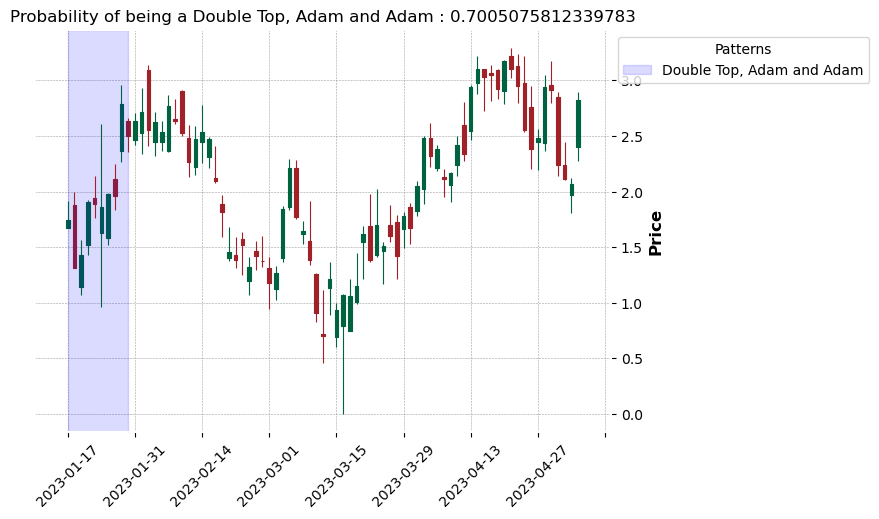

Predicted Pattern: Double Top, Adam and Adam with probability: 0.6522392630577087 in num 2 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-30 00:00:00


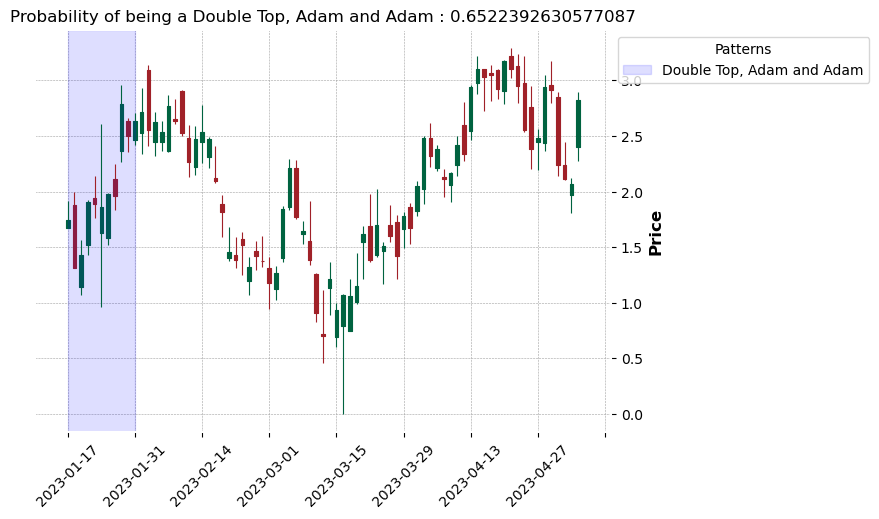

Predicted Pattern: Double Top, Adam and Adam with probability: 0.622769832611084 in num 3 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-31 00:00:00


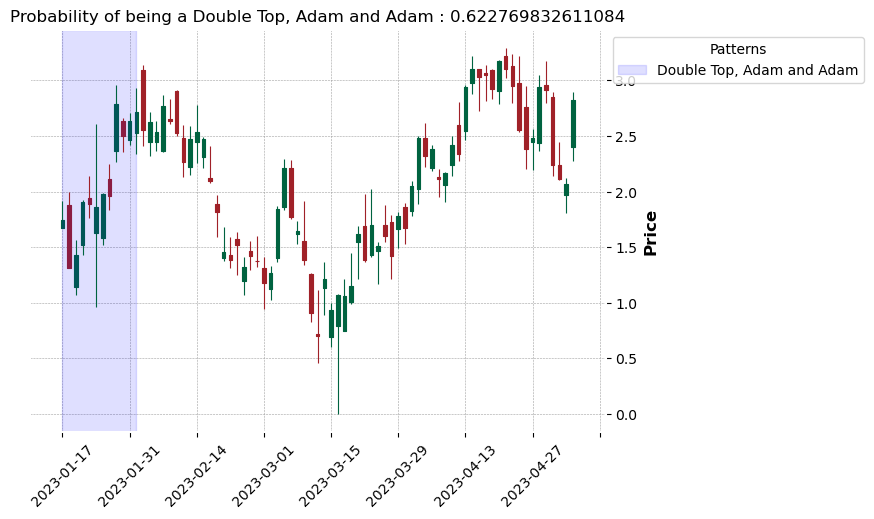

Predicted Pattern: Double Top, Adam and Adam with probability: 0.42730504274368286 in num 4 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-01 00:00:00


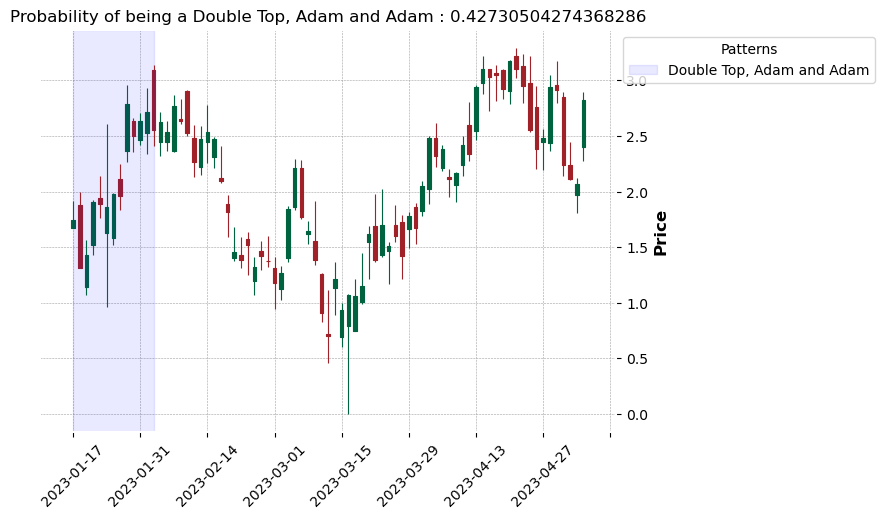

Predicted Pattern: Flag, high and tight with probability: 0.43254366517066956 in num 5 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-02 00:00:00


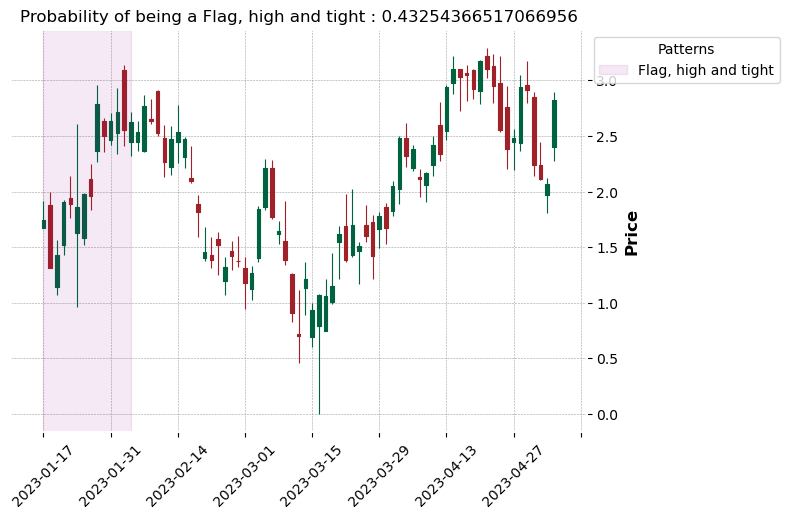

Predicted Pattern: Flag, high and tight with probability: 0.3938559293746948 in num 6 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-03 00:00:00


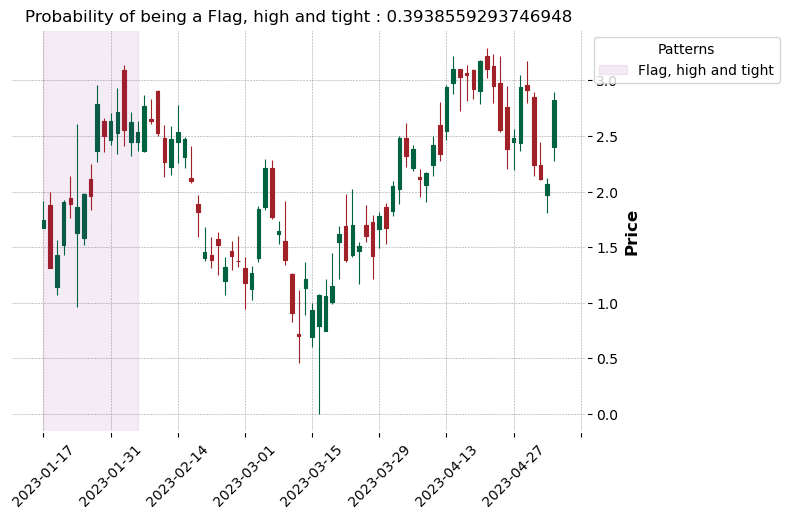

Predicted Pattern: Double Top, Adam and Adam with probability: 0.8725117444992065 in num 7 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-06 00:00:00


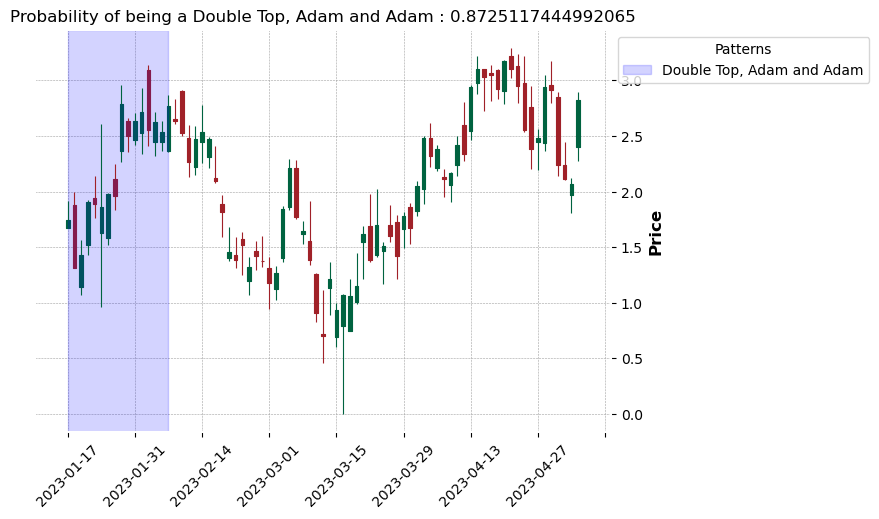

Predicted Pattern: Double Top, Adam and Adam with probability: 0.35992875695228577 in num 8 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-07 00:00:00


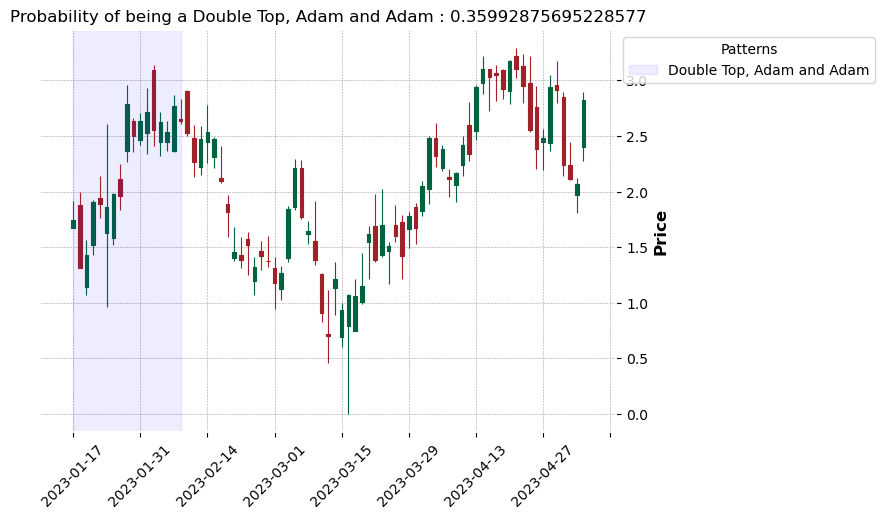

Predicted Pattern: Double Top, Adam and Adam with probability: 0.38976529240608215 in num 9 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-08 00:00:00


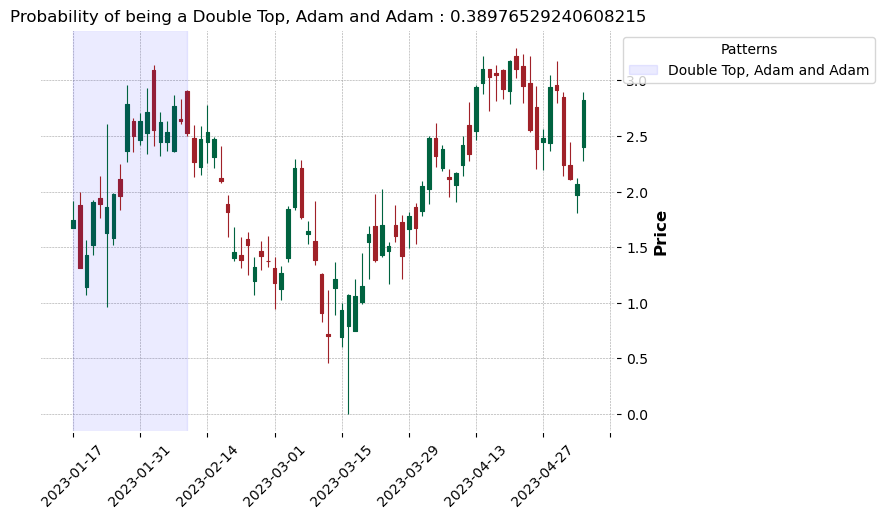

Predicted Pattern: Flag, high and tight with probability: 0.34600532054901123 in num 10 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-09 00:00:00


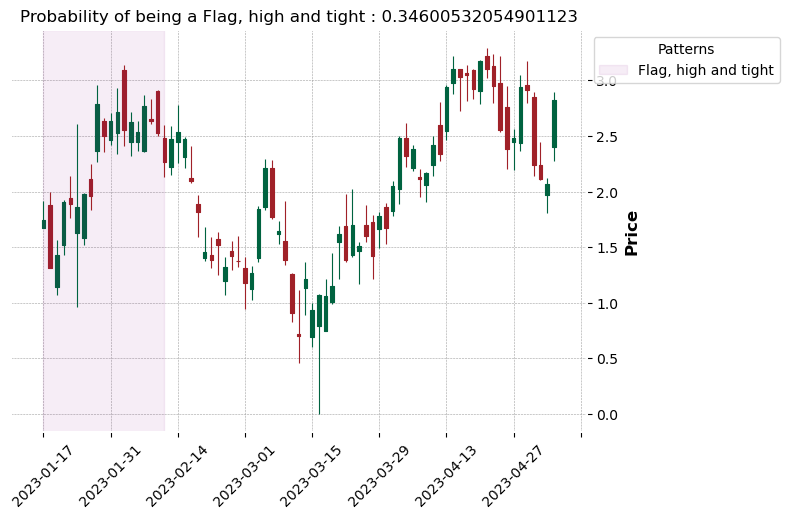

Predicted Pattern: Flag, high and tight with probability: 0.5515711307525635 in num 11 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-10 00:00:00


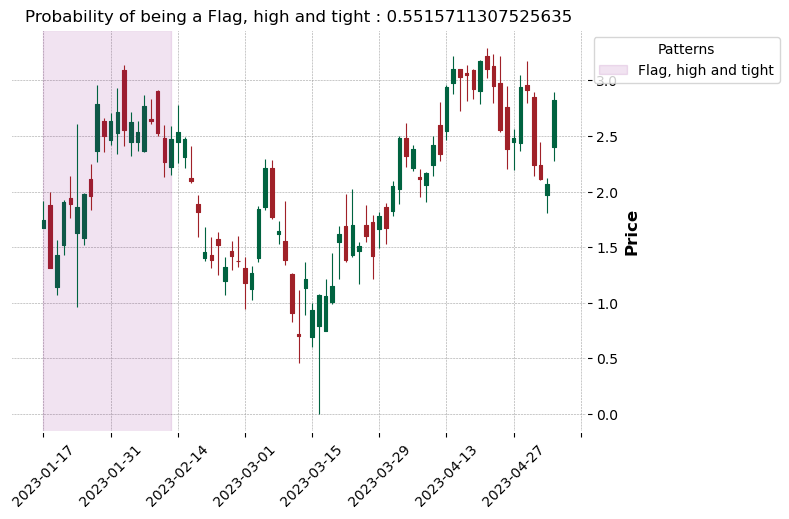

Predicted Pattern: Flag, high and tight with probability: 0.6555747985839844 in num 12 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-13 00:00:00


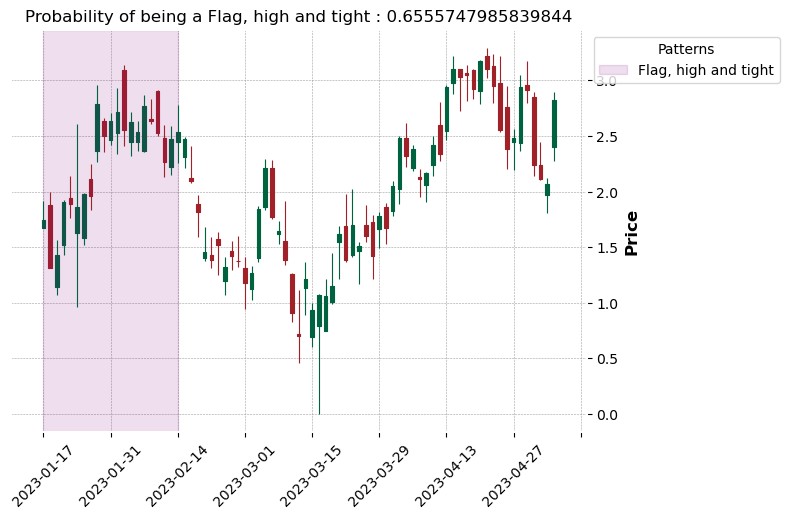

Predicted Pattern: Head-and-shoulders top with probability: 0.5489091277122498 in num 13 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-14 00:00:00


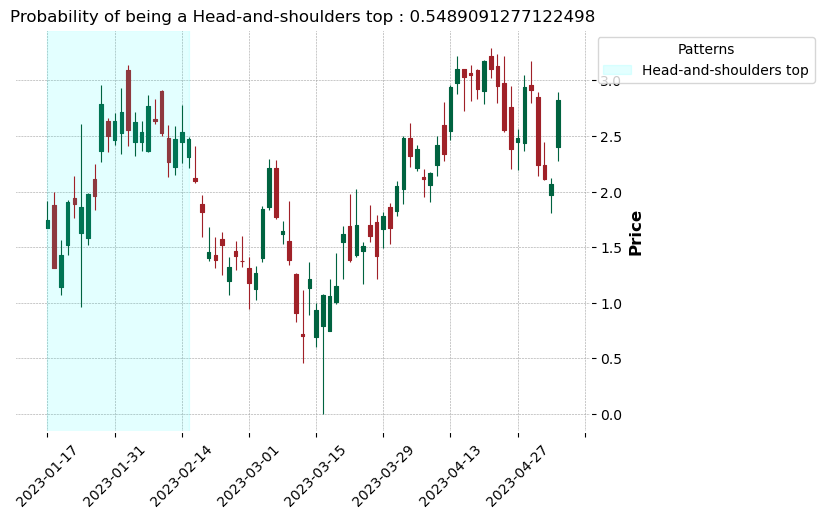

Predicted Pattern: Head-and-shoulders top with probability: 0.533184826374054 in num 14 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-15 00:00:00


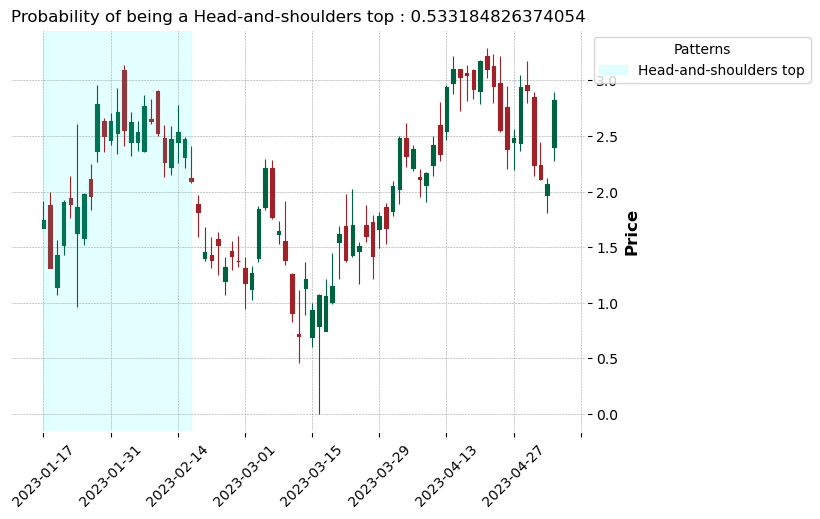

Predicted Pattern: Flag, high and tight with probability: 0.5484350919723511 in num 15 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-18 00:00:00 Pattern End :  2023-02-16 00:00:00


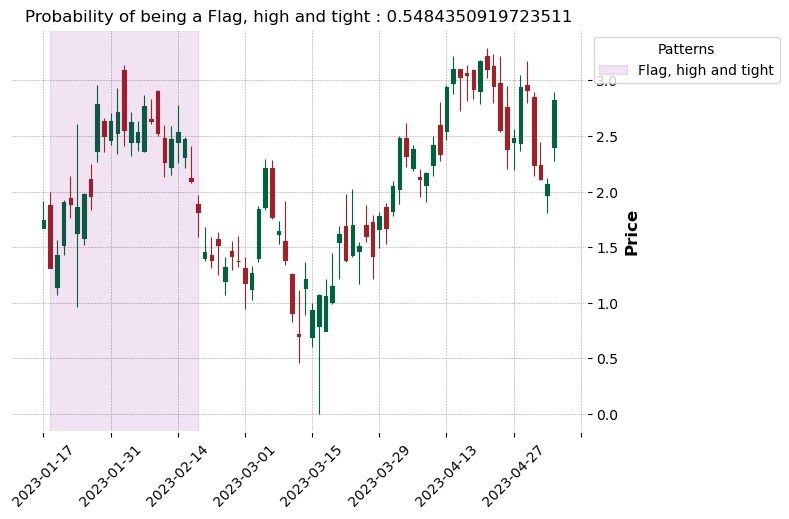

Predicted Pattern: Head-and-shoulders top with probability: 0.6291451454162598 in num 16 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-19 00:00:00 Pattern End :  2023-02-17 00:00:00


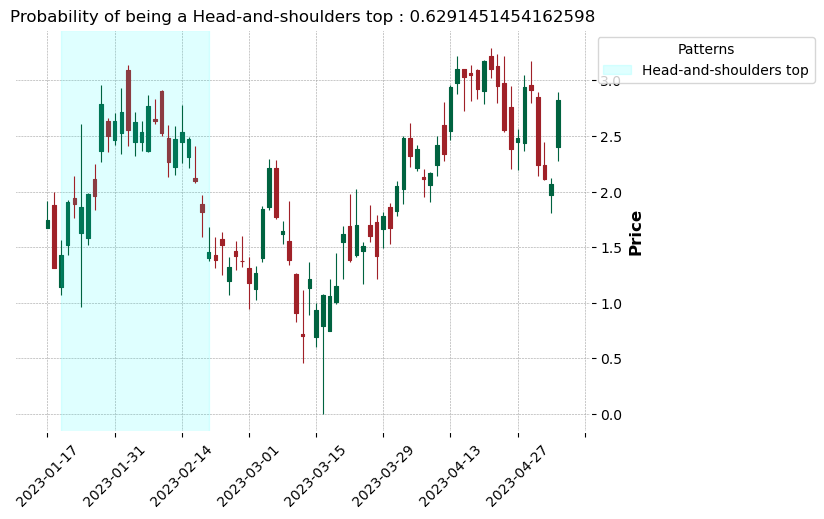

Predicted Pattern: Head-and-shoulders top with probability: 0.9880911111831665 in num 17 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-20 00:00:00 Pattern End :  2023-02-21 00:00:00


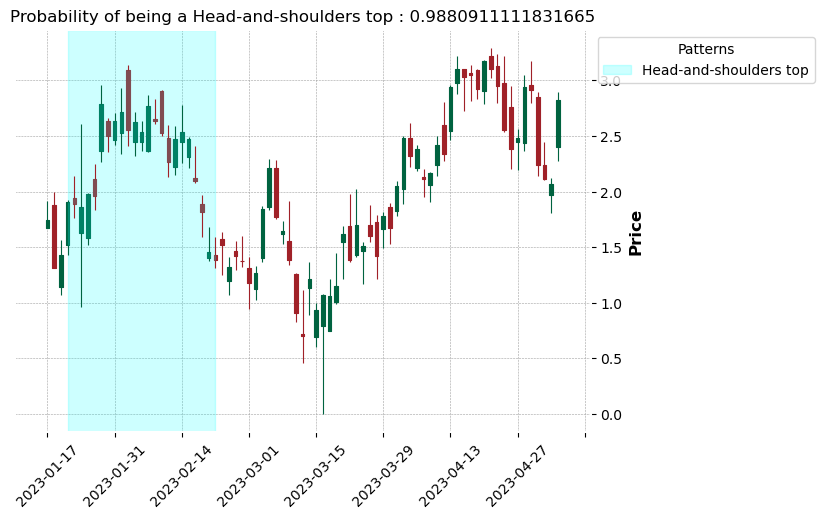

Predicted Pattern: Head-and-shoulders top with probability: 0.7207167744636536 in num 18 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-23 00:00:00 Pattern End :  2023-02-22 00:00:00


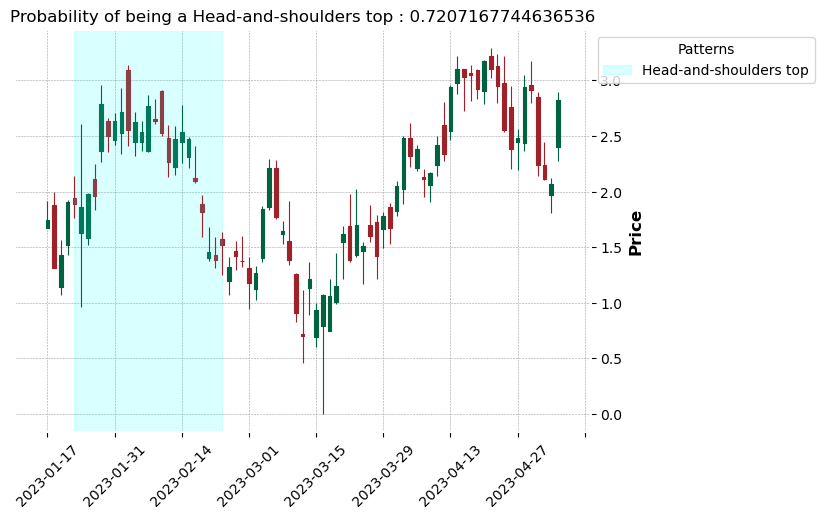

Predicted Pattern: Head-and-shoulders top with probability: 0.9854738712310791 in num 19 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-24 00:00:00 Pattern End :  2023-02-23 00:00:00


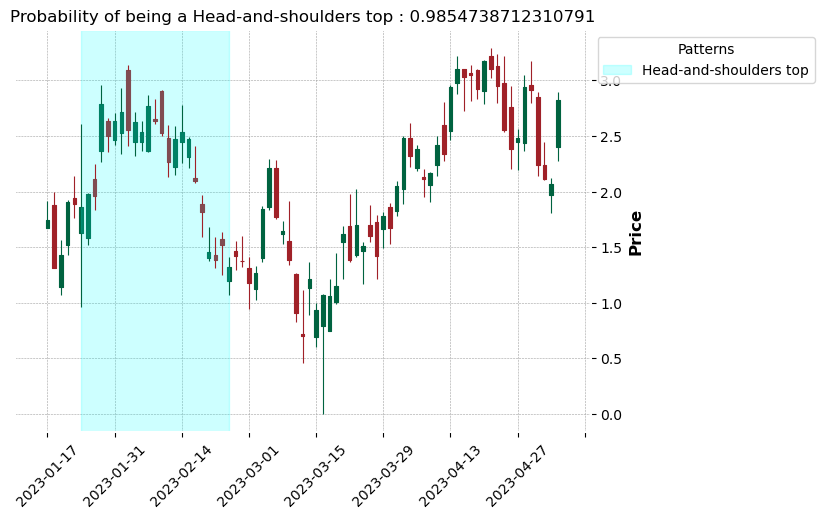

Predicted Pattern: Head-and-shoulders top with probability: 0.54451584815979 in num 20 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-25 00:00:00 Pattern End :  2023-02-24 00:00:00


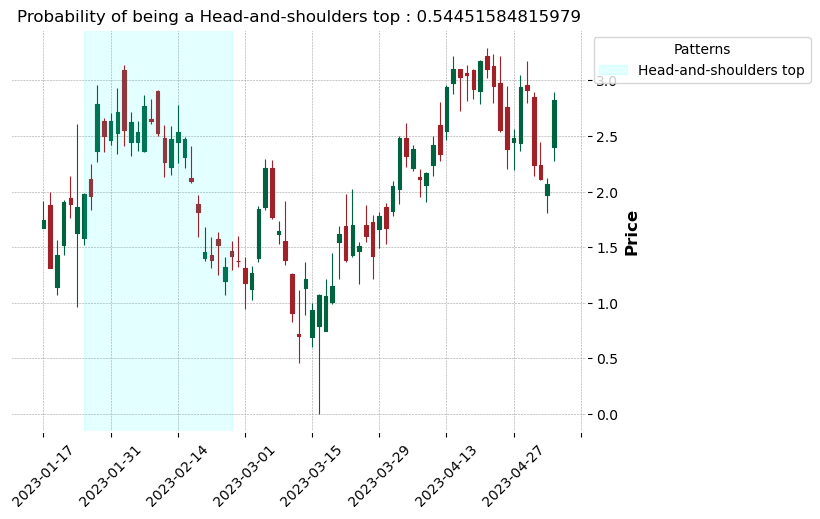

Predicted Pattern: Head-and-shoulders top with probability: 0.4051336646080017 in num 21 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-26 00:00:00 Pattern End :  2023-02-27 00:00:00


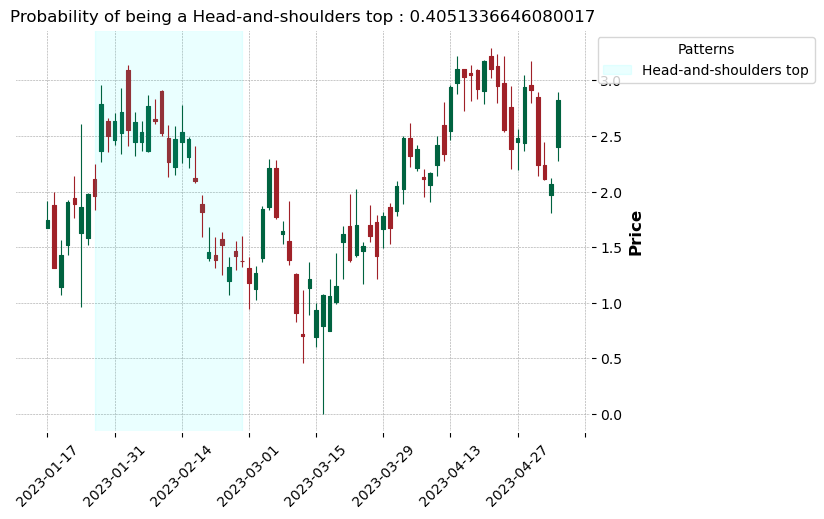

Predicted Pattern: Double Top, Adam and Adam with probability: 0.3051619231700897 in num 22 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-27 00:00:00 Pattern End :  2023-02-28 00:00:00


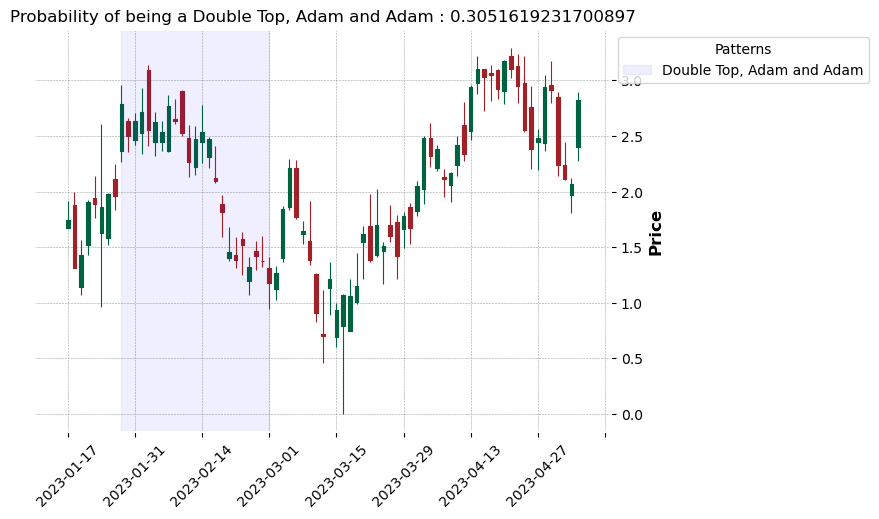

Predicted Pattern: Head-and-shoulders top with probability: 0.3338361382484436 in num 23 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-30 00:00:00 Pattern End :  2023-03-01 00:00:00


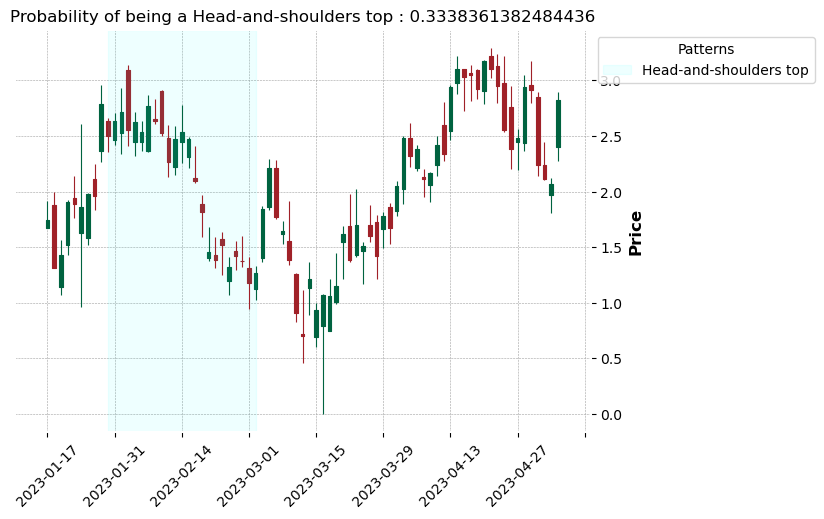

Predicted Pattern: Head-and-shoulders top with probability: 0.4384334981441498 in num 24 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-31 00:00:00 Pattern End :  2023-03-02 00:00:00


Predicted Pattern: Head-and-shoulders top with probability: 0.2475682646036148 in num 25 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-01 00:00:00 Pattern End :  2023-03-03 00:00:00


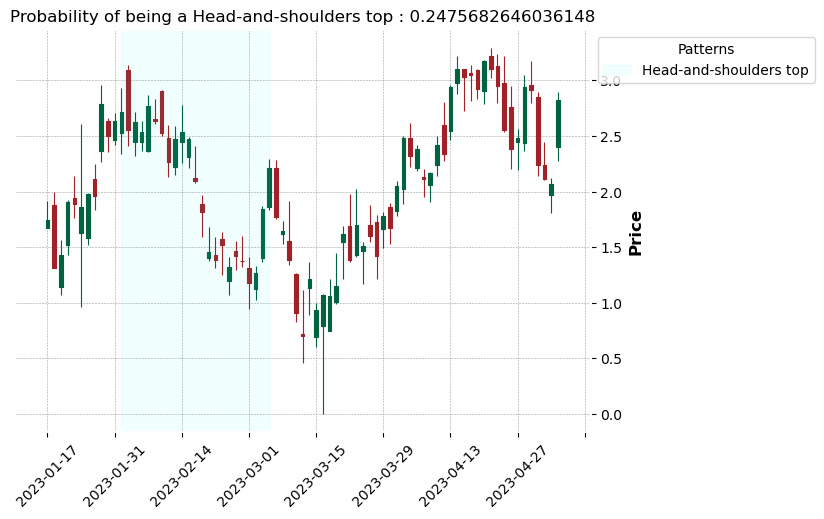

Predicted Pattern: Triangle, symmetrical with probability: 0.3973664343357086 in num 26 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-02 00:00:00 Pattern End :  2023-03-06 00:00:00


Predicted Pattern: Double Top, Adam and Adam with probability: 0.34129586815834045 in num 27 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-03 00:00:00 Pattern End :  2023-03-07 00:00:00


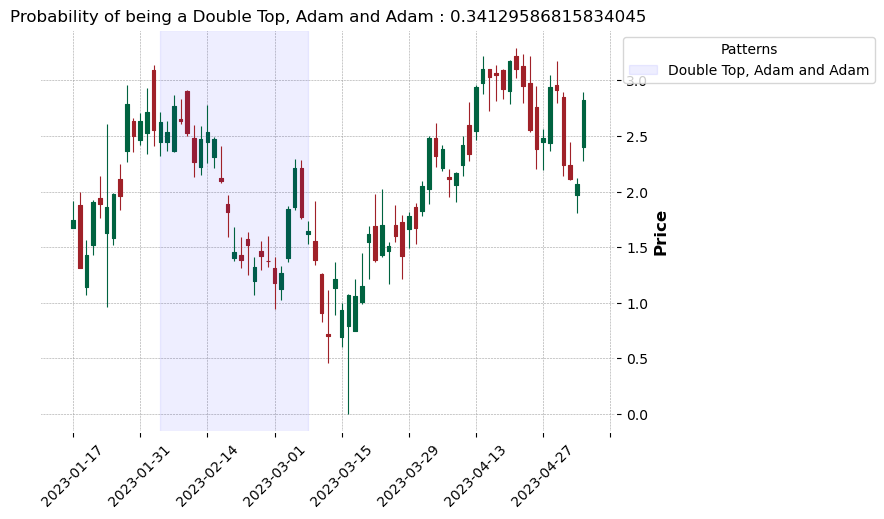

Predicted Pattern: Double Top, Adam and Adam with probability: 0.6468122005462646 in num 28 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-06 00:00:00 Pattern End :  2023-03-08 00:00:00


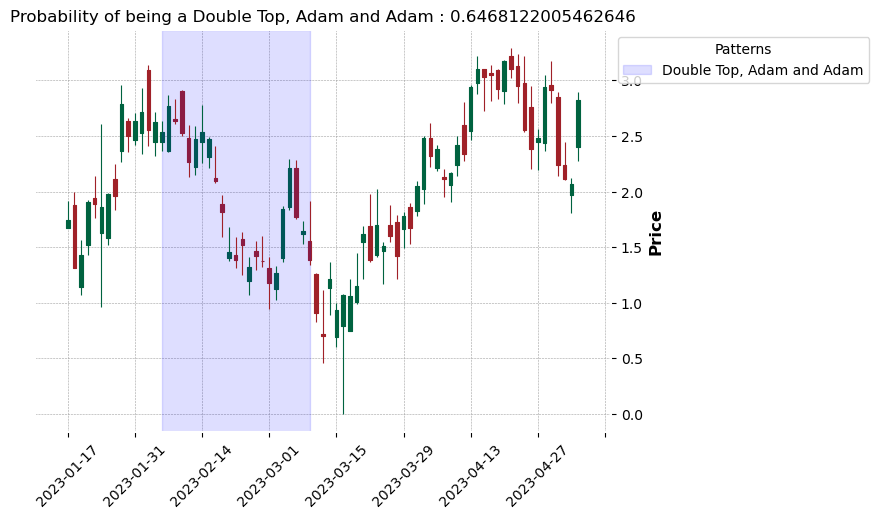

Predicted Pattern: Double Top, Adam and Adam with probability: 0.6898369193077087 in num 29 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-07 00:00:00 Pattern End :  2023-03-09 00:00:00


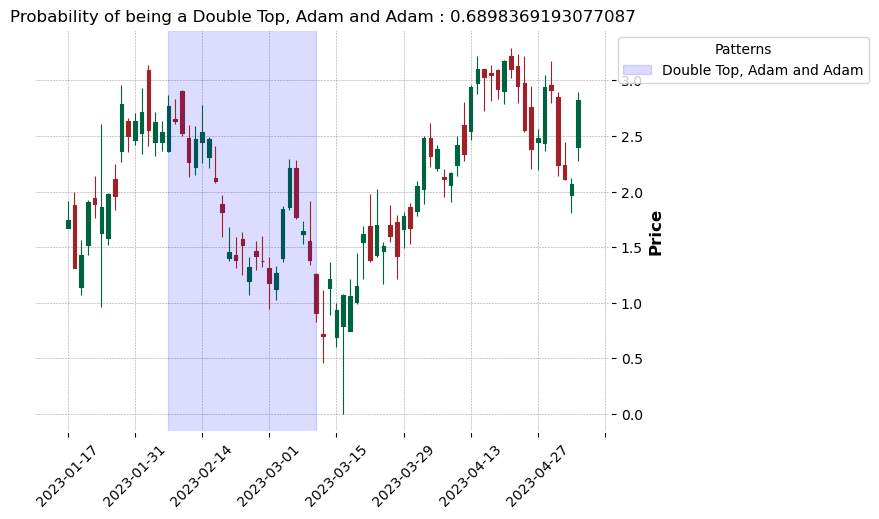

Predicted Pattern: Double Top, Adam and Adam with probability: 0.43560805916786194 in num 30 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-08 00:00:00 Pattern End :  2023-03-10 00:00:00


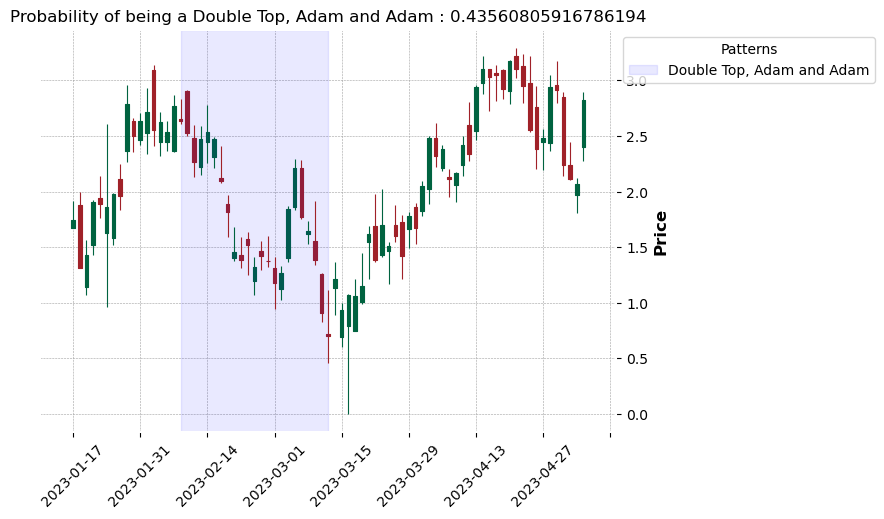

Predicted Pattern: Double Top, Adam and Adam with probability: 0.5713376402854919 in num 31 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-09 00:00:00 Pattern End :  2023-03-13 00:00:00


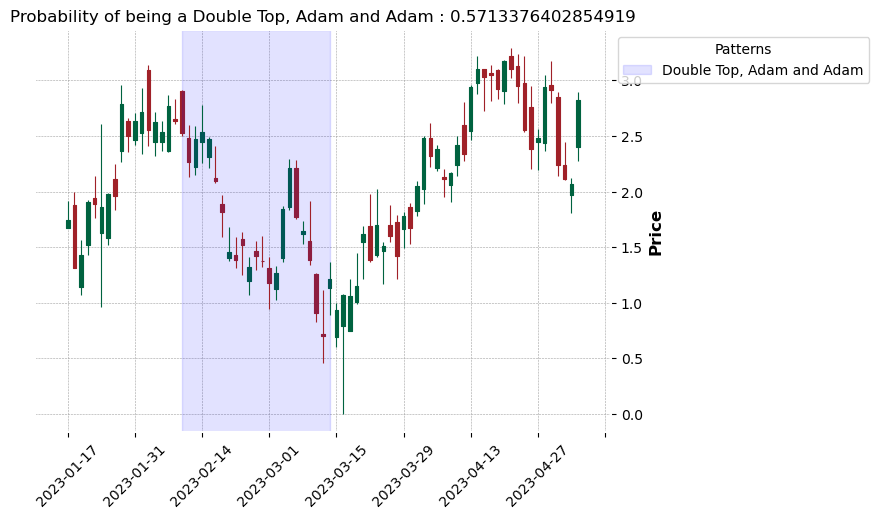

Predicted Pattern: Double Top, Adam and Adam with probability: 0.4233963191509247 in num 32 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-10 00:00:00 Pattern End :  2023-03-14 00:00:00


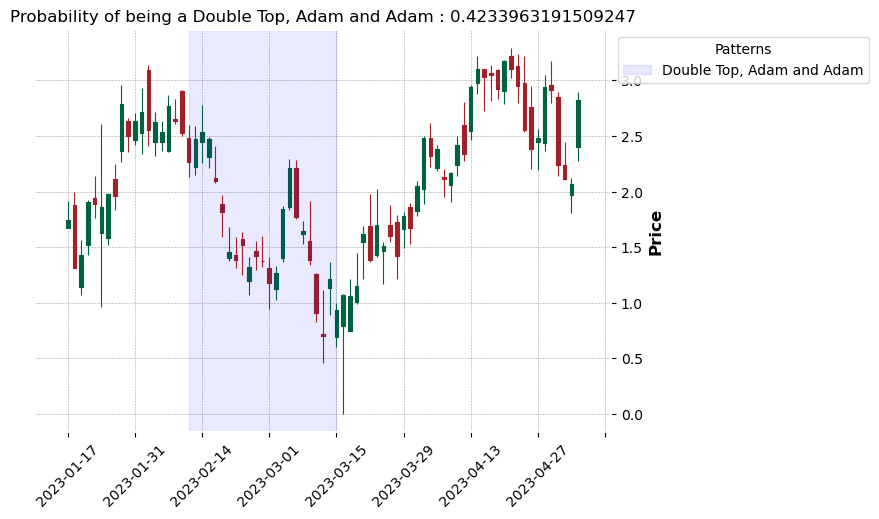

Predicted Pattern: Double Top, Adam and Adam with probability: 0.6686788201332092 in num 33 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-13 00:00:00 Pattern End :  2023-03-15 00:00:00


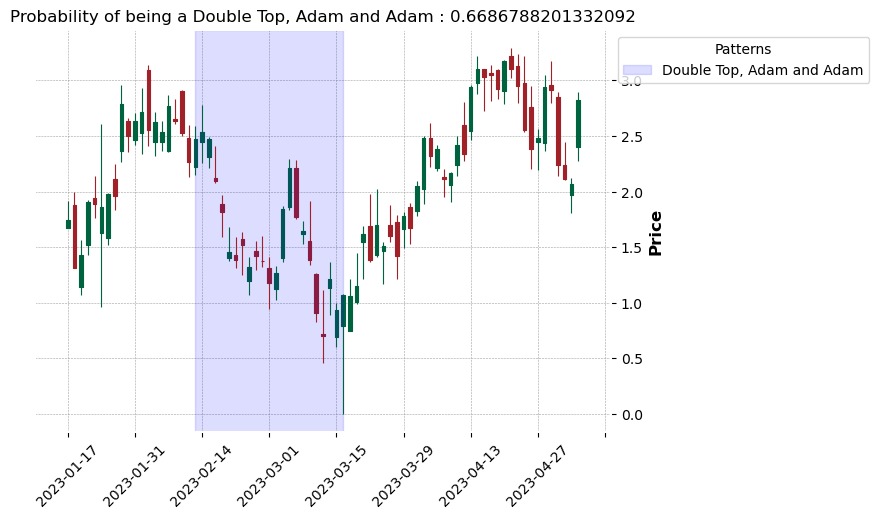

Predicted Pattern: Double Top, Adam and Adam with probability: 0.6171486377716064 in num 34 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-14 00:00:00 Pattern End :  2023-03-16 00:00:00


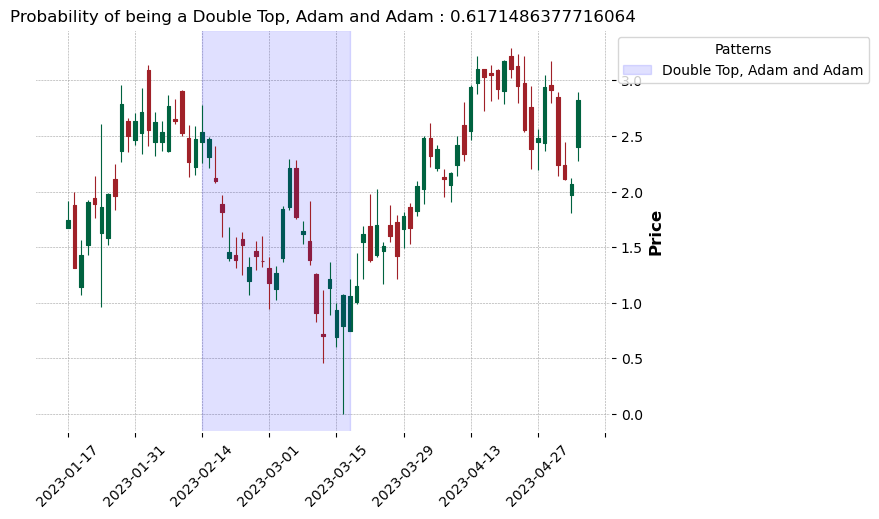

Predicted Pattern: Double Top, Adam and Adam with probability: 0.31436893343925476 in num 35 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-02-15 00:00:00 Pattern End :  2023-03-17 00:00:00


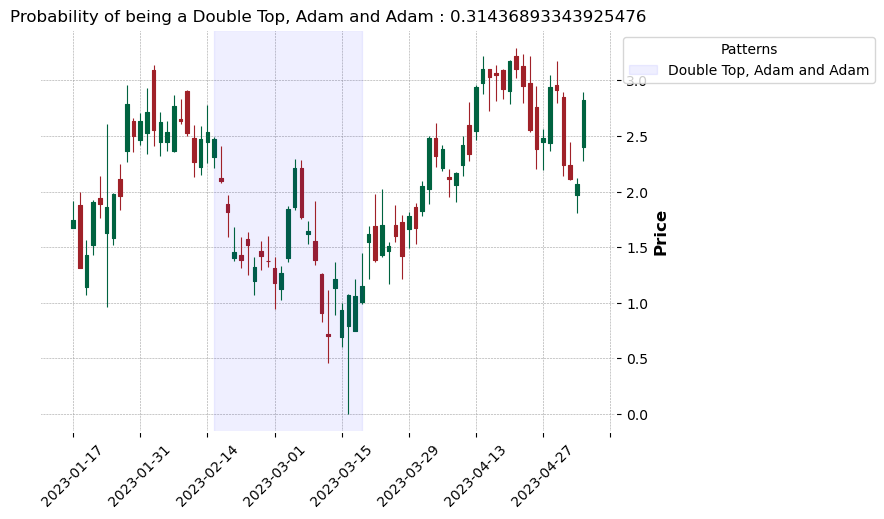

Predicted Pattern: Head-and-shoulders top with probability: 0.2669973373413086 in num 36 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-16 00:00:00 Pattern End :  2023-03-20 00:00:00


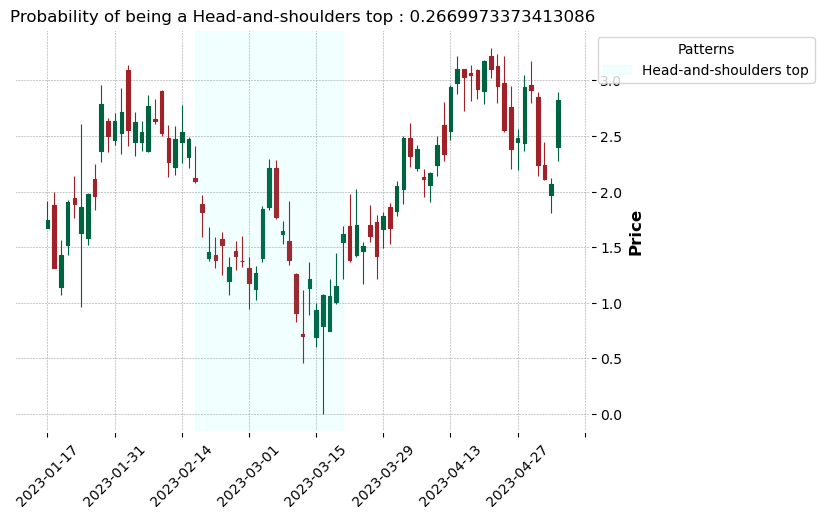

Predicted Pattern: Head-and-shoulders top with probability: 0.6461907029151917 in num 37 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-17 00:00:00 Pattern End :  2023-03-21 00:00:00


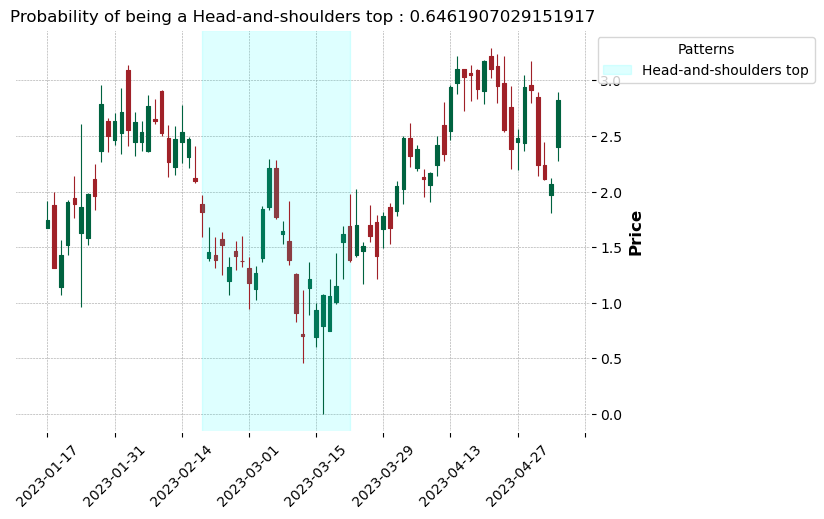

Predicted Pattern: Head-and-shoulders top with probability: 0.4189594089984894 in num 38 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-21 00:00:00 Pattern End :  2023-03-22 00:00:00


Predicted Pattern: Head-and-shoulders top with probability: 0.3889274299144745 in num 39 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-02-22 00:00:00 Pattern End :  2023-03-23 00:00:00


Predicted Pattern: Triangle, symmetrical with probability: 0.2564318776130676 in num 40 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-02-23 00:00:00 Pattern End :  2023-03-24 00:00:00


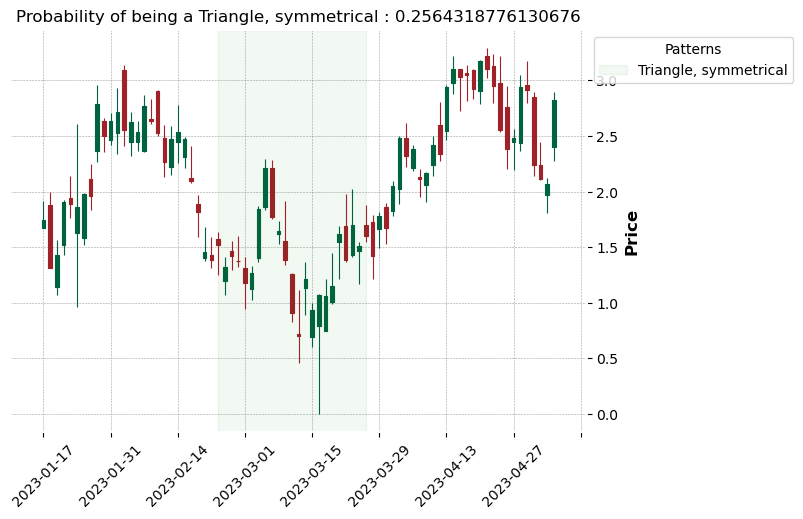

Predicted Pattern: Head-and-shoulders bottom with probability: 0.30460262298583984 in num 41 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-02-24 00:00:00 Pattern End :  2023-03-27 00:00:00


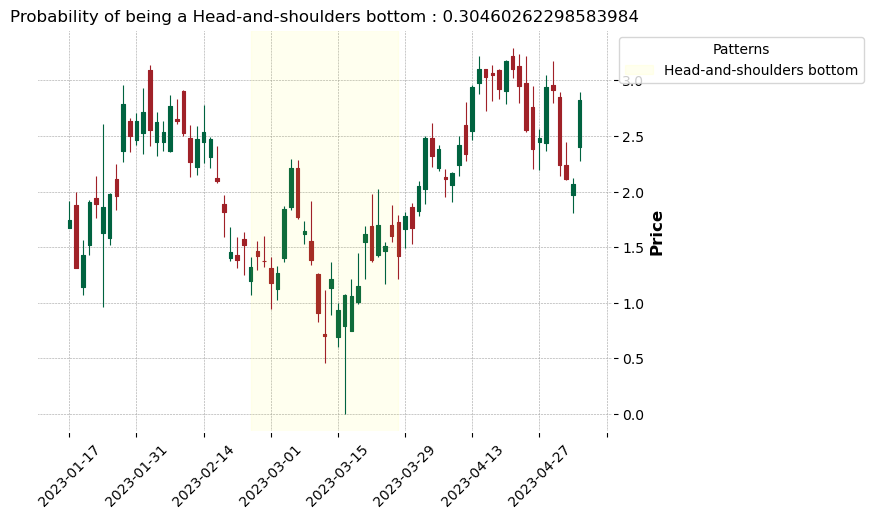

Predicted Pattern: Head-and-shoulders bottom with probability: 0.6483972668647766 in num 42 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-02-27 00:00:00 Pattern End :  2023-03-28 00:00:00


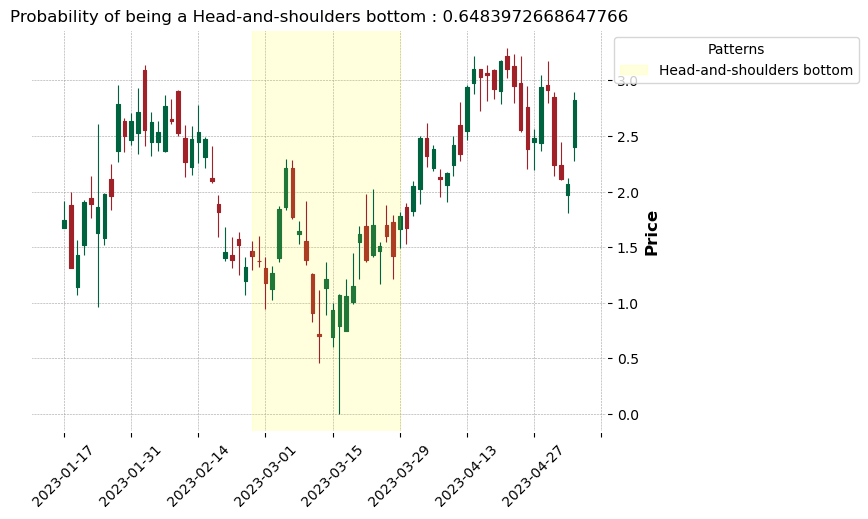

Predicted Pattern: Head-and-shoulders bottom with probability: 0.9128726124763489 in num 43 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-02-28 00:00:00 Pattern End :  2023-03-29 00:00:00


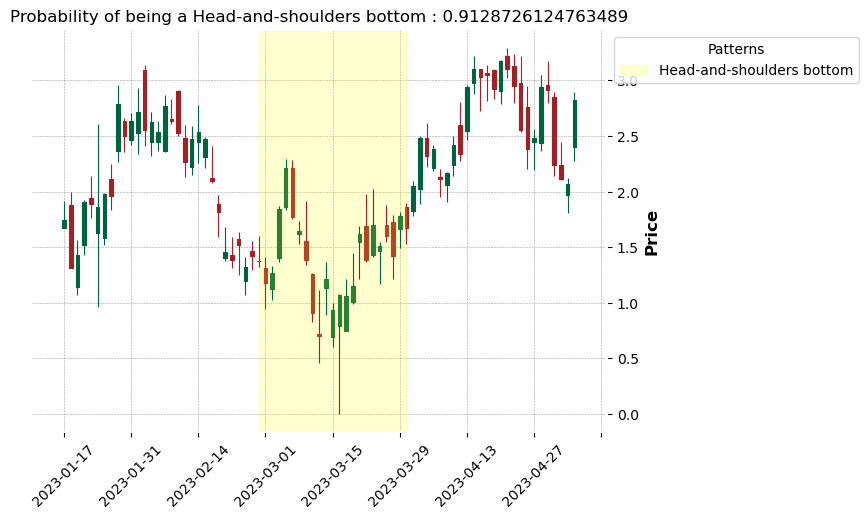

Predicted Pattern: Head-and-shoulders bottom with probability: 0.9673008322715759 in num 44 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-03-01 00:00:00 Pattern End :  2023-03-30 00:00:00


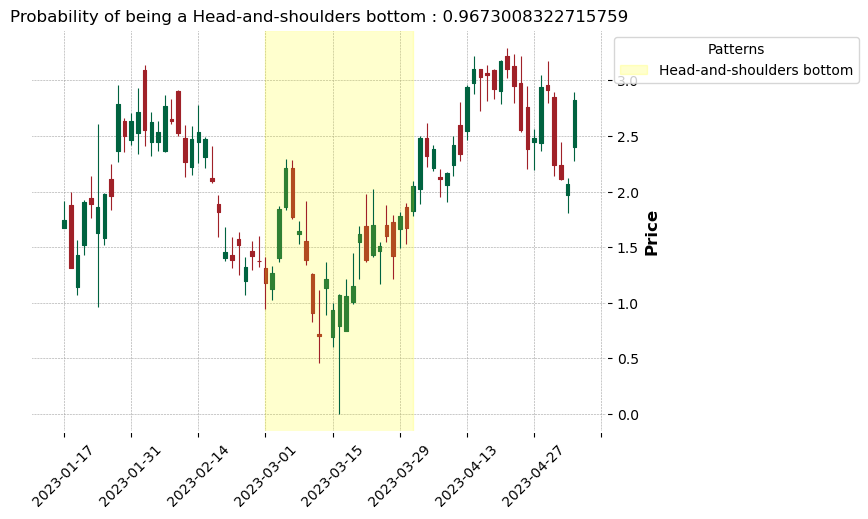

Predicted Pattern: Head-and-shoulders bottom with probability: 0.9897276759147644 in num 45 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-03-02 00:00:00 Pattern End :  2023-03-31 00:00:00


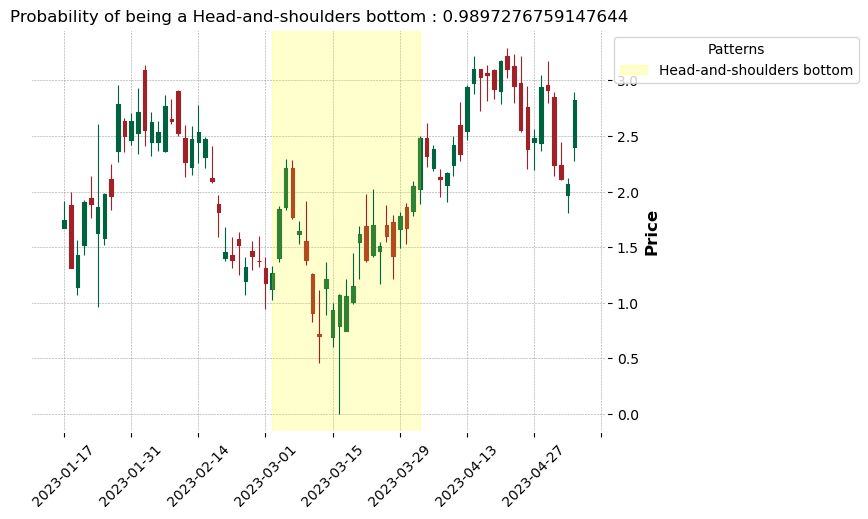

Predicted Pattern: Head-and-shoulders bottom with probability: 0.3178337514400482 in num 46 window
Pattern Name :  Head-and-shoulders bottom Pattern Start :  2023-03-03 00:00:00 Pattern End :  2023-04-03 00:00:00


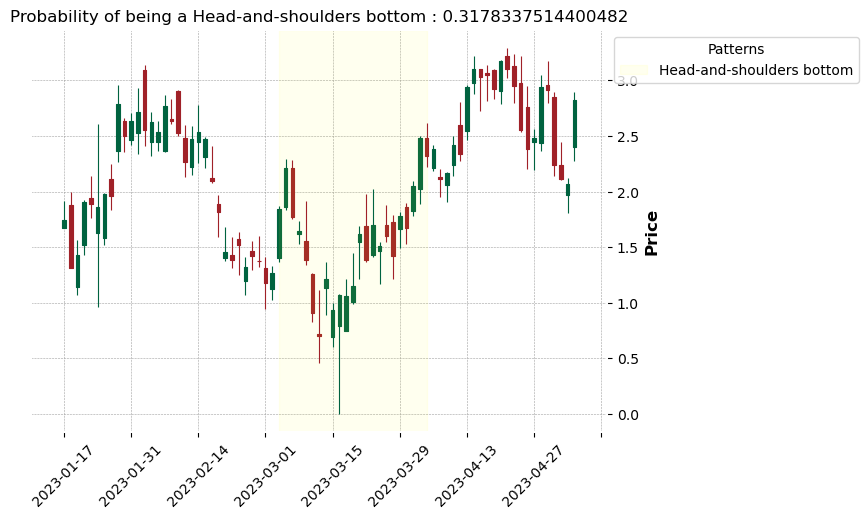

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.4158691167831421 in num 47 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-06 00:00:00 Pattern End :  2023-04-04 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.4428131878376007 in num 48 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-07 00:00:00 Pattern End :  2023-04-05 00:00:00


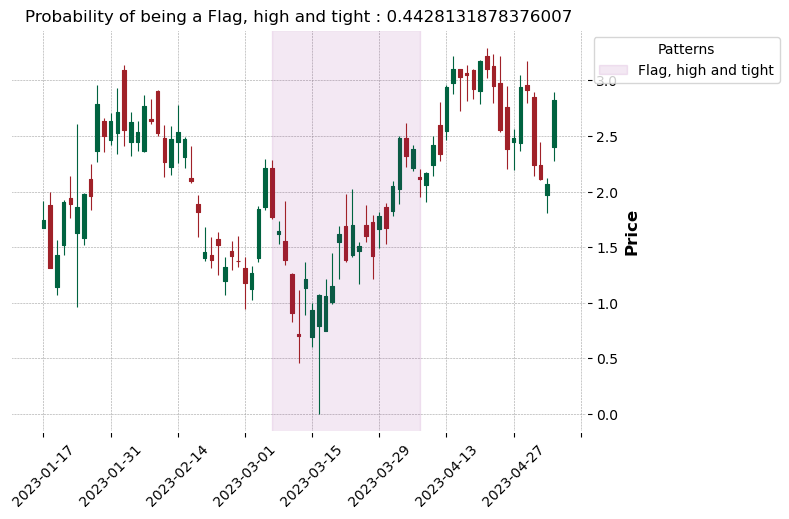

Predicted Pattern: Triangle, symmetrical with probability: 0.3576282858848572 in num 49 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-03-08 00:00:00 Pattern End :  2023-04-06 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.5042751431465149 in num 50 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-09 00:00:00 Pattern End :  2023-04-10 00:00:00


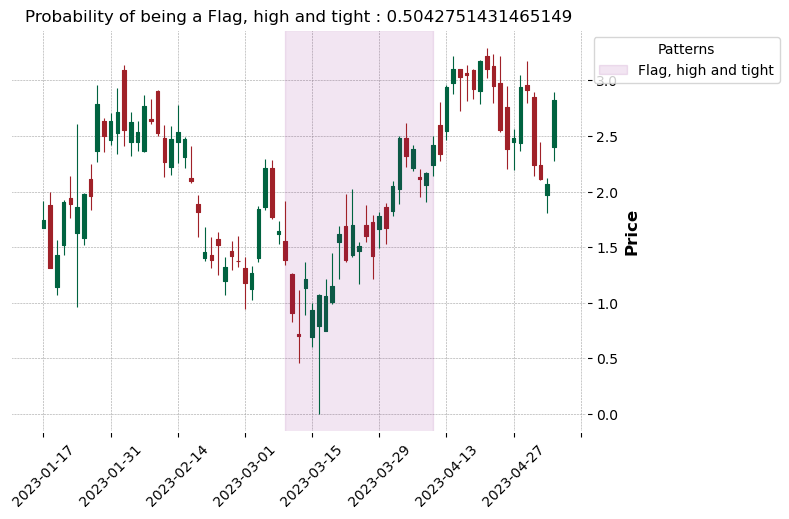

Predicted Pattern: Triangle, symmetrical with probability: 0.4068446159362793 in num 51 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-03-10 00:00:00 Pattern End :  2023-04-11 00:00:00


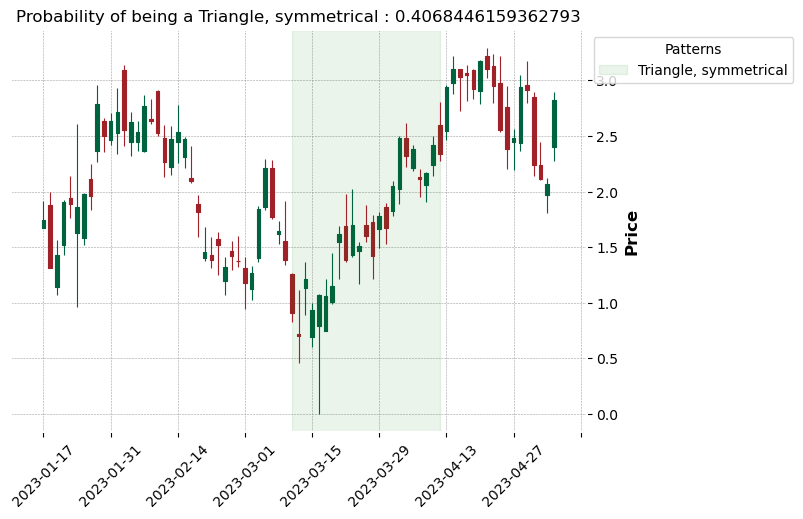

Predicted Pattern: Flag, high and tight with probability: 0.5179625749588013 in num 52 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-13 00:00:00 Pattern End :  2023-04-12 00:00:00


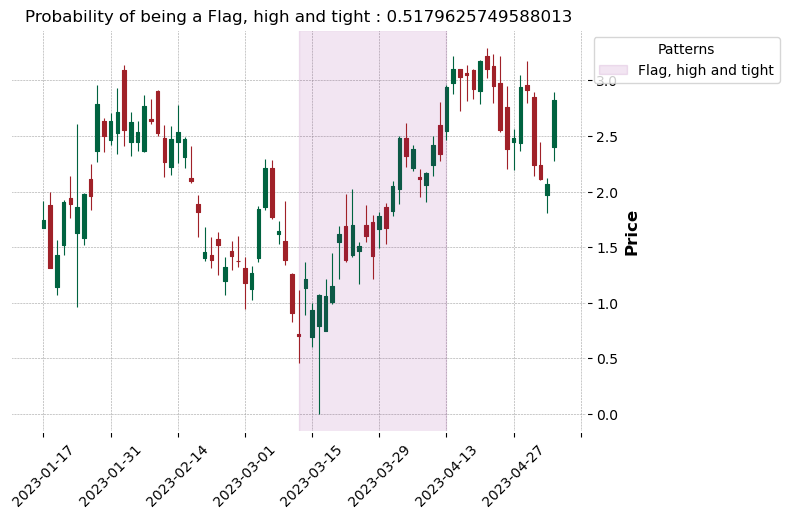

Predicted Pattern: Triangle, symmetrical with probability: 0.3269655108451843 in num 53 window
Pattern Name :  Triangle, symmetrical Pattern Start :  2023-03-14 00:00:00 Pattern End :  2023-04-13 00:00:00


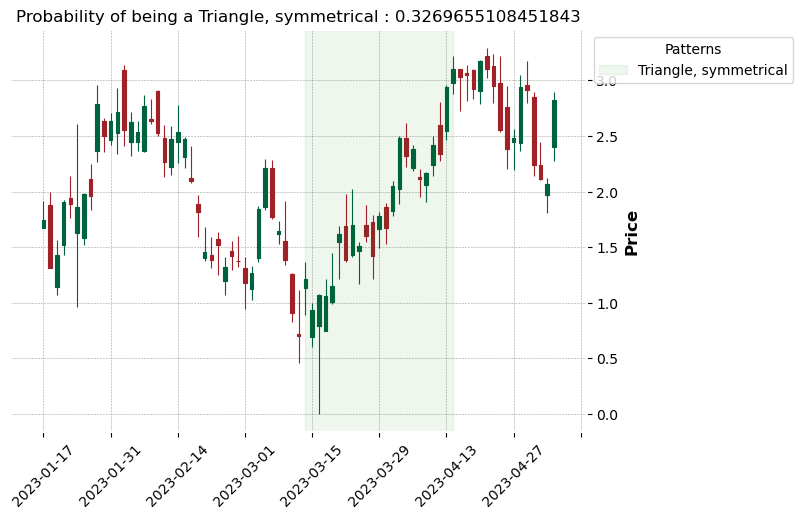

Predicted Pattern: Double Bottom, Eve and Adam with probability: 0.43578147888183594 in num 54 window
Pattern Name :  Double Bottom, Eve and Adam Pattern Start :  2023-03-15 00:00:00 Pattern End :  2023-04-14 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.6432992815971375 in num 55 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-16 00:00:00 Pattern End :  2023-04-17 00:00:00


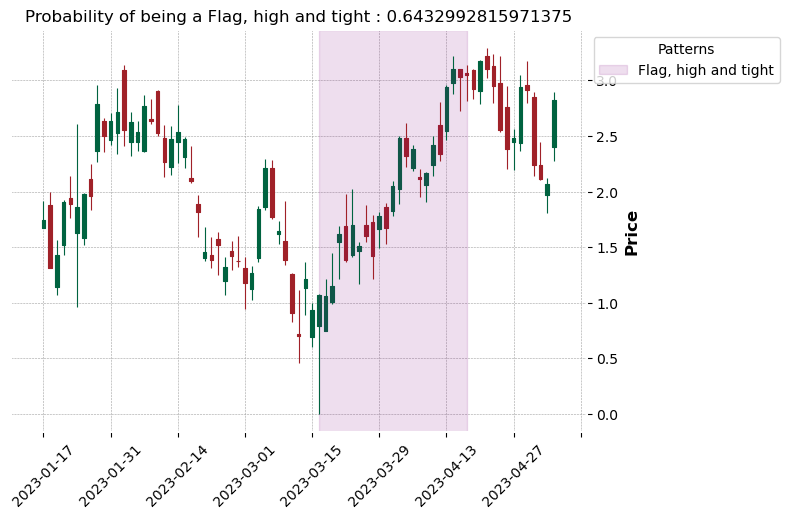

Predicted Pattern: Flag, high and tight with probability: 0.43608447909355164 in num 56 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-17 00:00:00 Pattern End :  2023-04-18 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.7082021832466125 in num 57 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-20 00:00:00 Pattern End :  2023-04-19 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.6337096691131592 in num 58 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-21 00:00:00 Pattern End :  2023-04-20 00:00:00


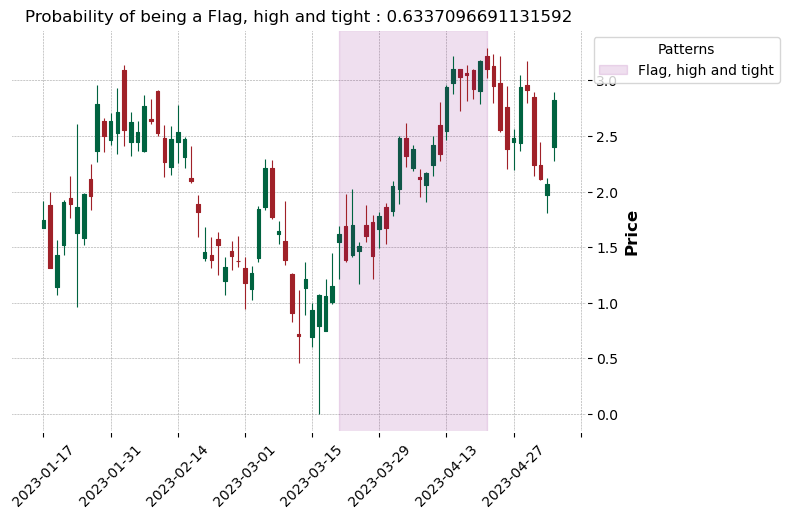

Predicted Pattern: Flag, high and tight with probability: 0.41846486926078796 in num 59 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-22 00:00:00 Pattern End :  2023-04-21 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.7080597877502441 in num 60 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-23 00:00:00 Pattern End :  2023-04-24 00:00:00


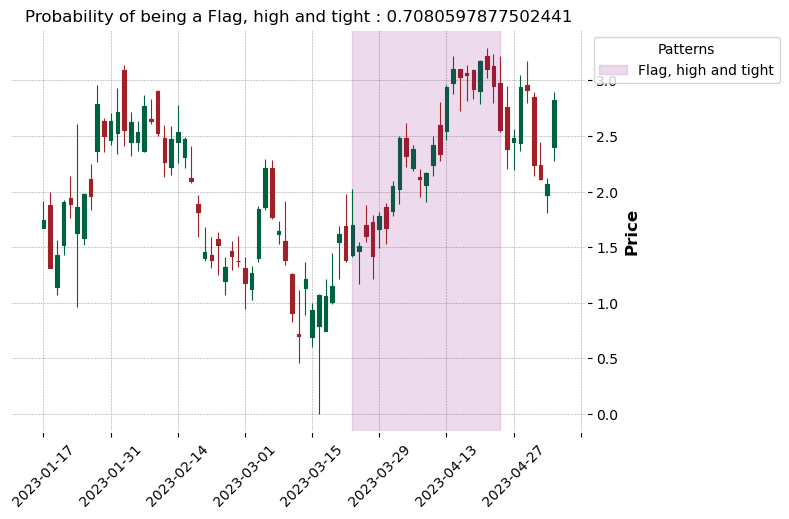

Predicted Pattern: Flag, high and tight with probability: 0.4150446355342865 in num 61 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-24 00:00:00 Pattern End :  2023-04-25 00:00:00


Predicted Pattern: Flag, high and tight with probability: 0.5533269643783569 in num 62 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-03-27 00:00:00 Pattern End :  2023-04-26 00:00:00


Predicted Pattern: Head-and-shoulders top with probability: 0.961231529712677 in num 63 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-03-28 00:00:00 Pattern End :  2023-04-27 00:00:00


Predicted Pattern: Head-and-shoulders top with probability: 0.5497884154319763 in num 64 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-03-29 00:00:00 Pattern End :  2023-04-28 00:00:00


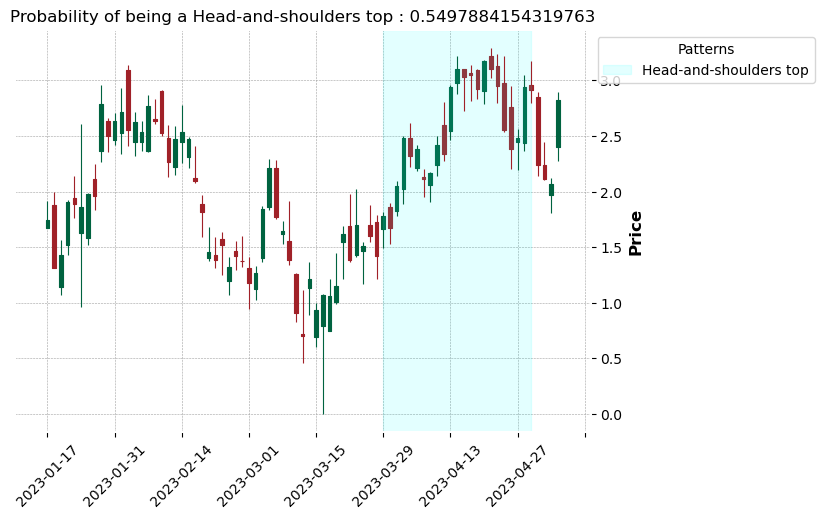

Predicted Pattern: Head-and-shoulders top with probability: 0.543179988861084 in num 65 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-03-30 00:00:00 Pattern End :  2023-05-01 00:00:00


Predicted Pattern: Head-and-shoulders top with probability: 0.518441379070282 in num 66 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-03-31 00:00:00 Pattern End :  2023-05-02 00:00:00


Predicted Pattern: Head-and-shoulders top with probability: 0.43189916014671326 in num 67 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-03 00:00:00 Pattern End :  2023-05-03 00:00:00


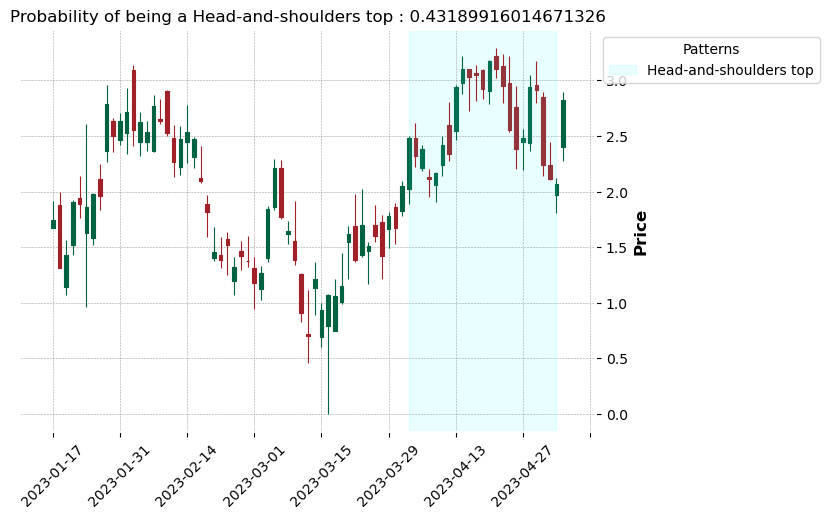

Predicted Pattern: Head-and-shoulders top with probability: 0.6978381276130676 in num 68 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-04 00:00:00 Pattern End :  2023-05-04 00:00:00


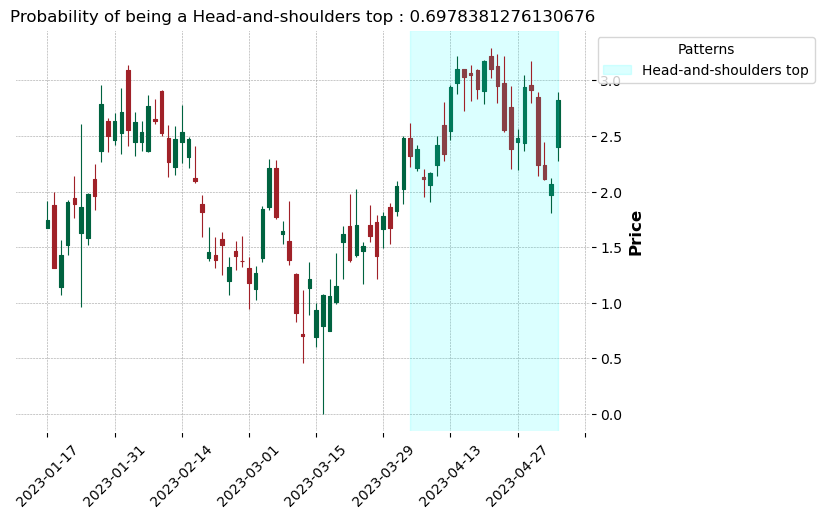

Predicted Pattern: Head-and-shoulders top with probability: 0.4492883086204529 in num 69 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-05 00:00:00 Pattern End :  2023-05-05 00:00:00


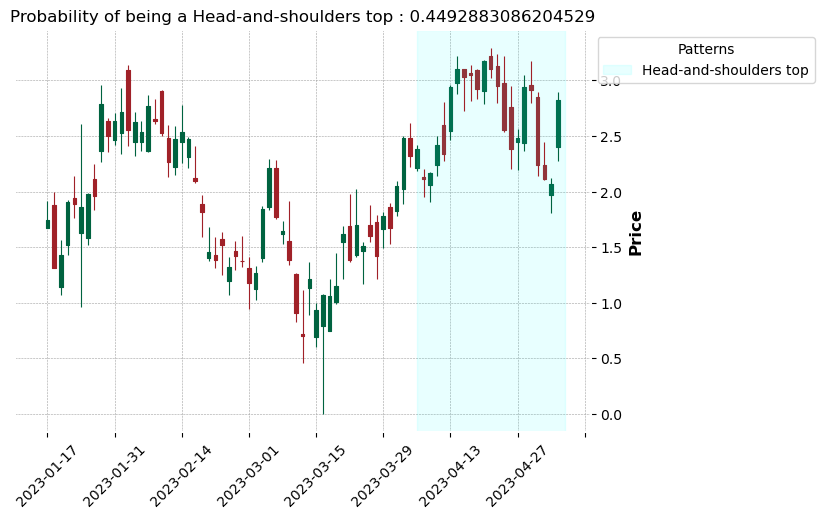

Predicted Pattern: Flag, high and tight with probability: 0.42541125416755676 in num 70 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-04-06 00:00:00 Pattern End :  2023-05-05 00:00:00


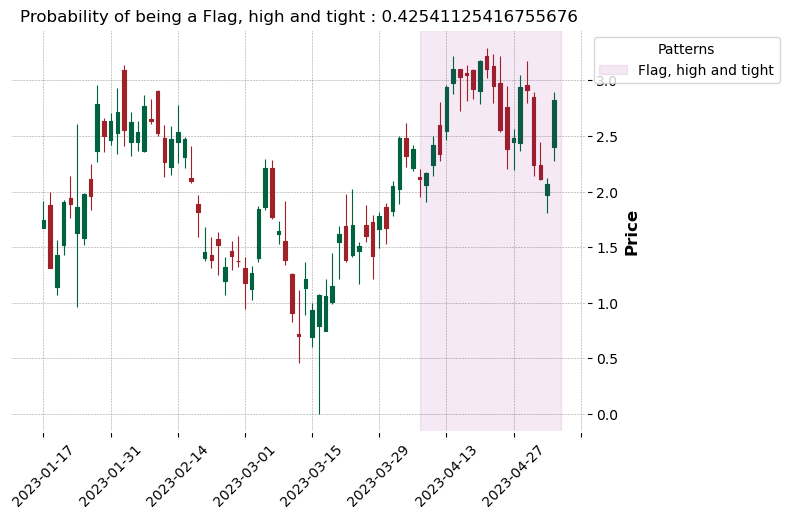

Predicted Pattern: Flag, high and tight with probability: 0.4270979166030884 in num 71 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-04-10 00:00:00 Pattern End :  2023-05-05 00:00:00


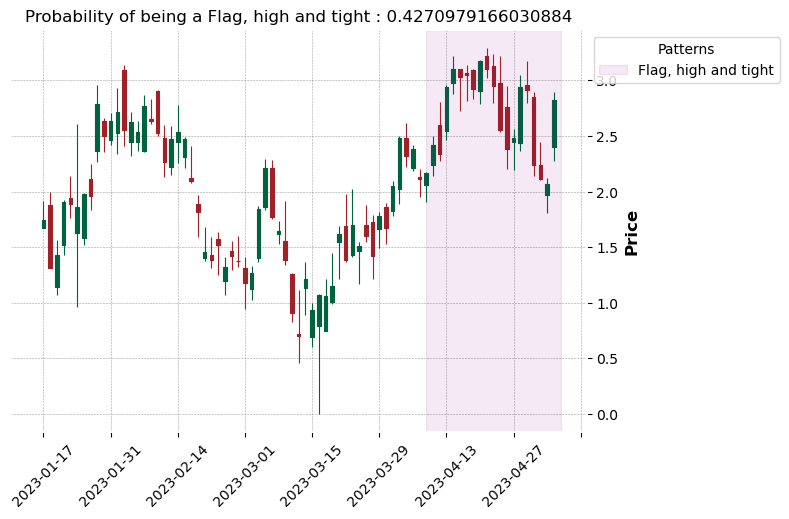

Predicted Pattern: Flag, high and tight with probability: 0.3530915677547455 in num 72 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-04-11 00:00:00 Pattern End :  2023-05-05 00:00:00


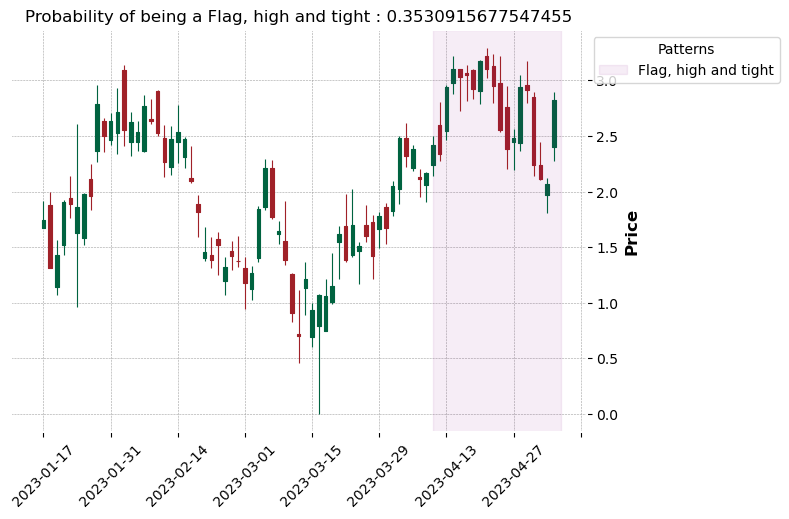

Predicted Pattern: Double Top, Adam and Adam with probability: 0.31168466806411743 in num 73 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-04-12 00:00:00 Pattern End :  2023-05-05 00:00:00


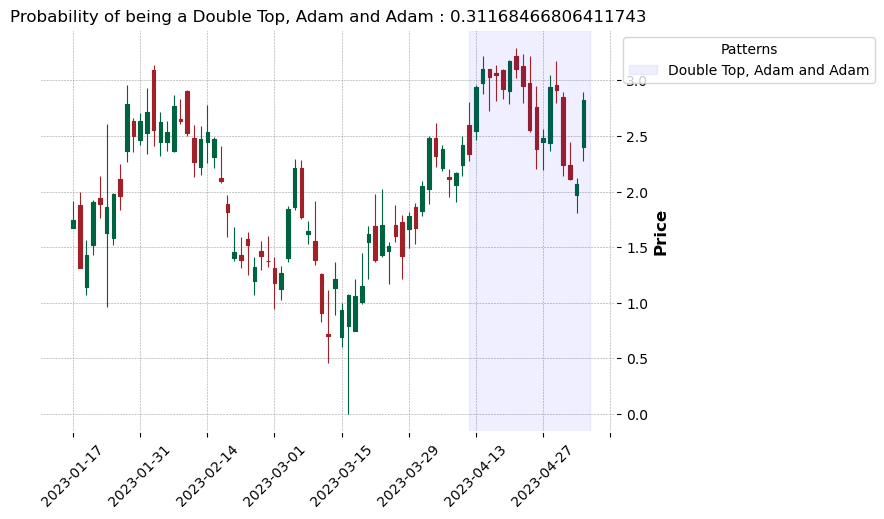

Predicted Pattern: Head-and-shoulders top with probability: 0.6999516487121582 in num 74 window
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-13 00:00:00 Pattern End :  2023-05-05 00:00:00


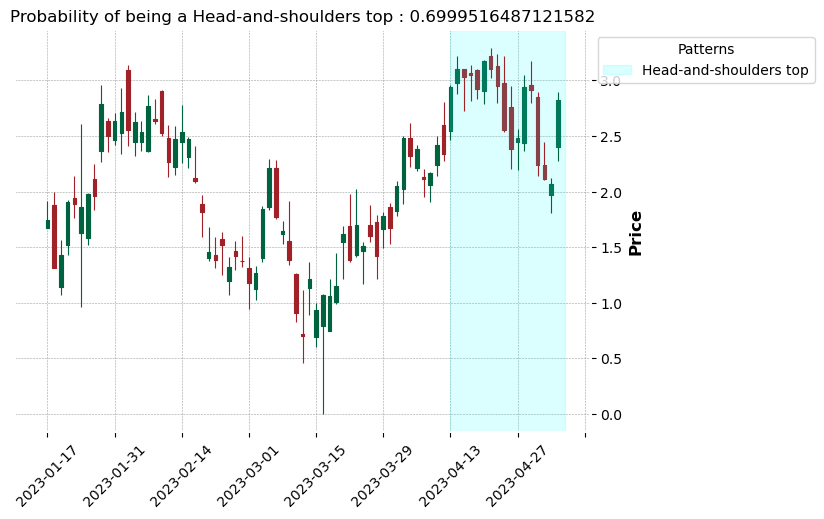

Predicted Pattern: Flag, high and tight with probability: 0.44540590047836304 in num 75 window
Pattern Name :  Flag, high and tight Pattern Start :  2023-04-14 00:00:00 Pattern End :  2023-05-05 00:00:00


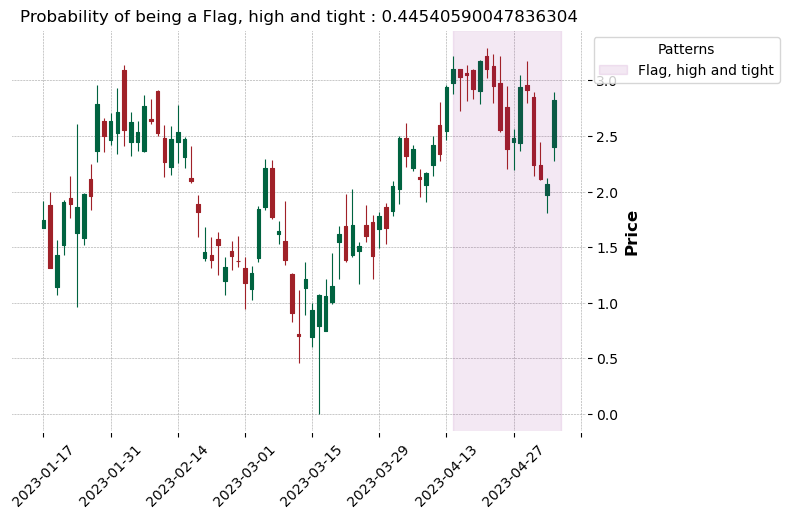

Predicted Pattern: Double Top, Adam and Adam with probability: 0.46453380584716797 in num 76 window
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-04-17 00:00:00 Pattern End :  2023-05-05 00:00:00


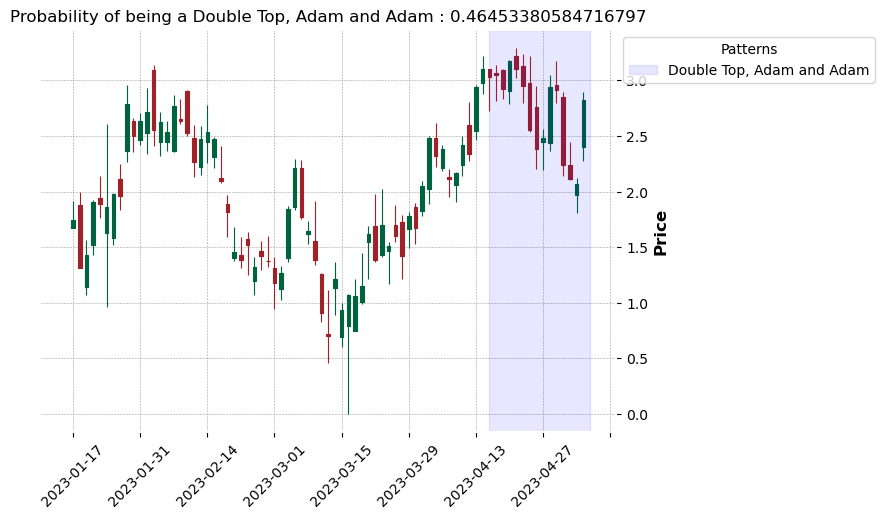

Error in finding the peaks or valleys in the Double Top pattern
Double Top, Adam and Adam  :
    Clustered Windows :


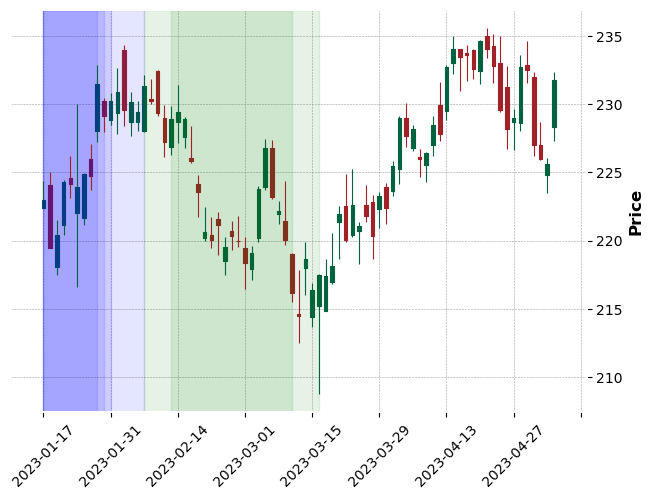

    Finalized Section :


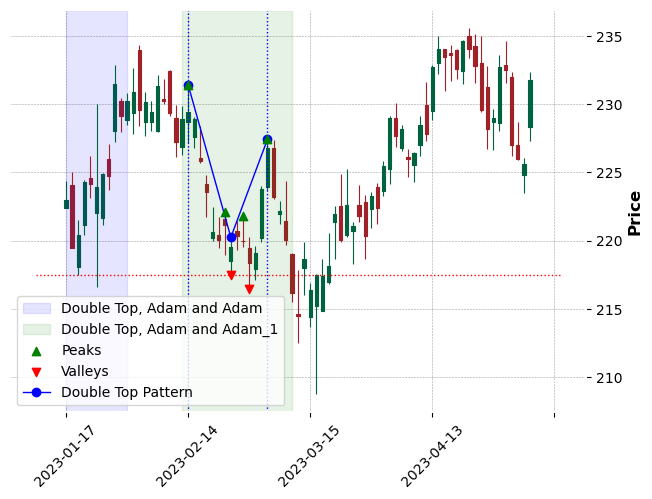

Flag, high and tight  :
    Clustered Windows :


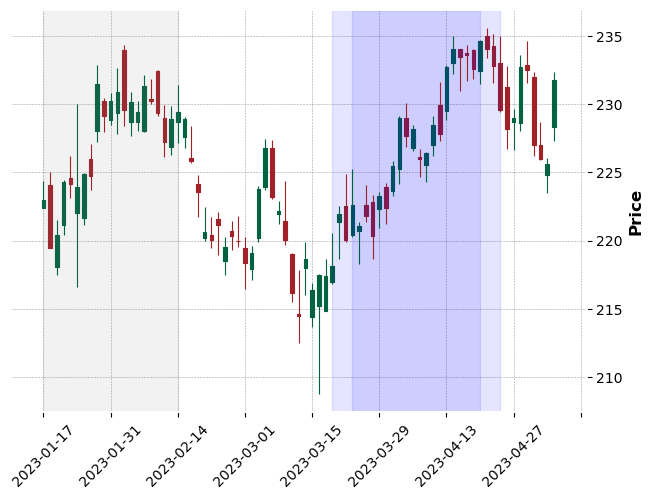

    Finalized Section :


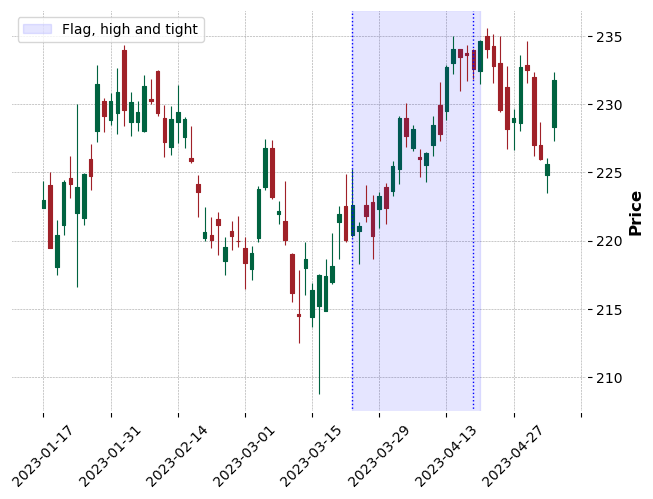

Head-and-shoulders bottom  :
    Clustered Windows :


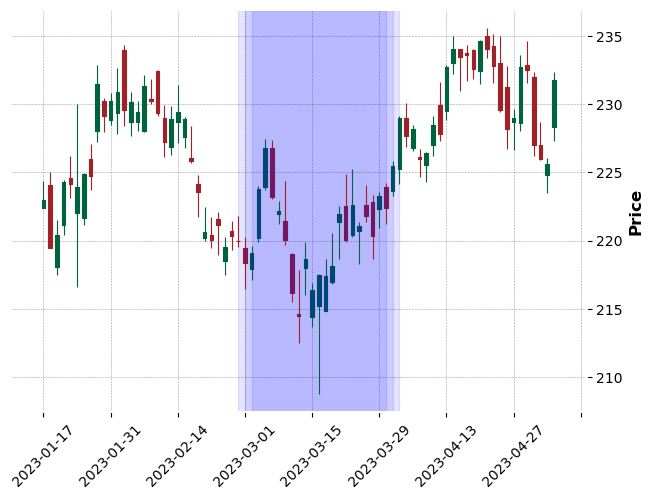

    Finalized Section :


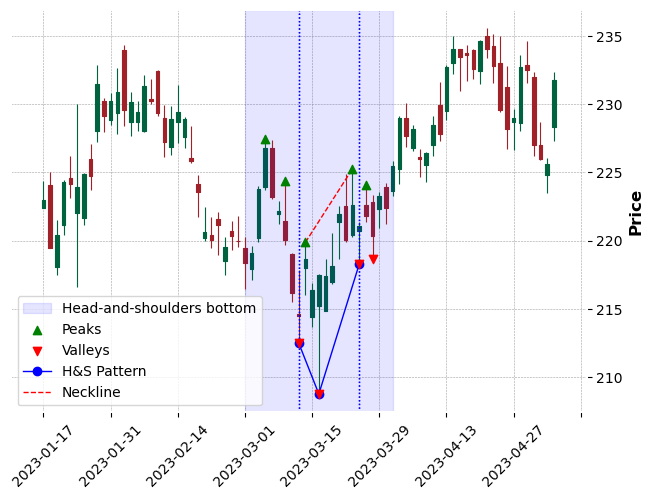

Head-and-shoulders top  :
    Clustered Windows :


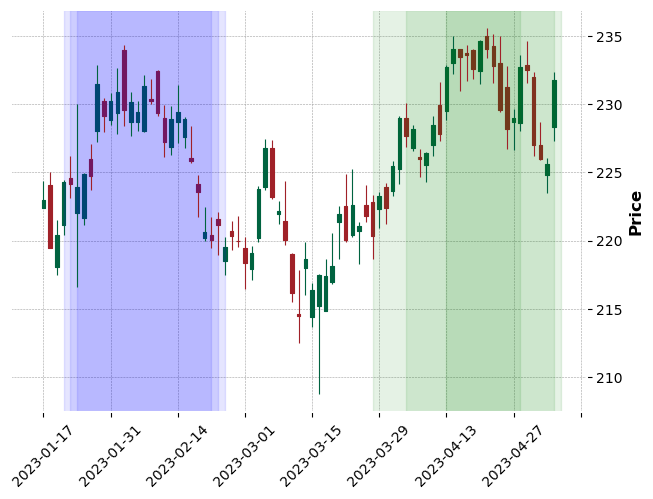

    Finalized Section :


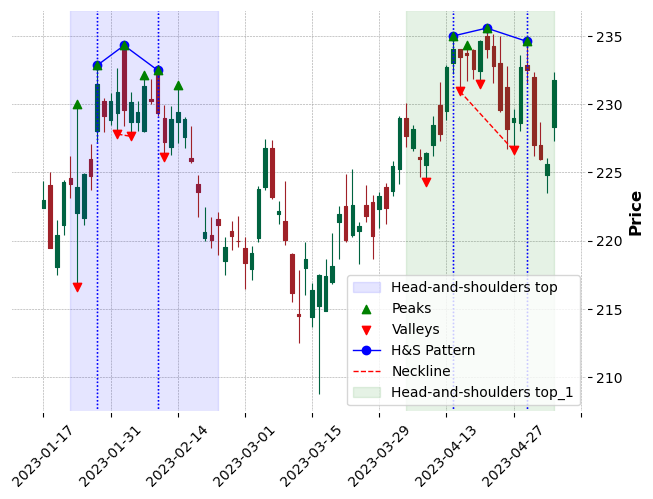

In [103]:
import random
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
# for seg_id, win_res_group in win_res_grouped_results:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# Select a group

# seg_id = random.choice(window_results_all_df['Seg_ID'].unique())
seg_id = 377 
win_res_group = win_res_grouped_results.get_group(seg_id)

group = grouped.get_group(seg_id)
    
ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, seg_id, path,group)

plot_sliding_steps(win_res_group ,ohlc_data_segment,0 ,seg_id,save = True) 
if ohlc_data_segment is None:
    print("OHLC Data segment is empty")
    # continue
predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_res_group)
if predicted_patterns is None:
    print("predicted_patterns is empty")
    # continue
cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
if cluster_labled_windows_df is None  or interseced_clusters_df is None:
    print("cluster_labled_windows_df is empty")
    # continue
located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
if located_patterns_and_other_info is None:
    print("located_patterns_and_other_info is empty")
    # continue
plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, seg_id)
located_patterns_and_other_info_updated_list.append(located_patterns_and_other_info)



Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-26 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-27 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-30 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-01-31 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-01 00:00:00
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-02 00:00:00
Pattern Name :  Flag, high and tight Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-03 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023-02-06 00:00:00
Pattern Name :  Double Top, Adam and Adam Pattern Start :  2023-01-17 00:00:00 Pattern End :  2023

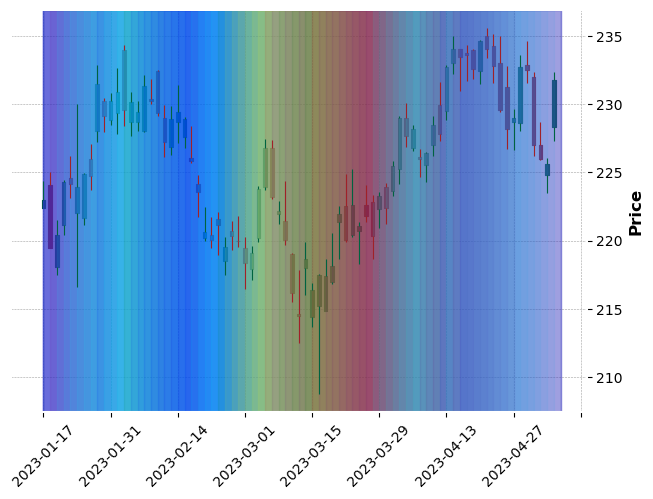

In [81]:
import random
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
# seg_id = random.choice(window_results_all_df['Seg_ID'].unique())
seg_id = 377 
win_res_group = win_res_grouped_results.get_group(seg_id)
plot_patterns_for_segment(seg_id, win_res_group ,color_pattern_wise=True,legend=False , seg_alpha=0.08)

Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-20 00:00:00 Pattern End :  2023-02-21 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-23 00:00:00 Pattern End :  2023-02-22 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-24 00:00:00 Pattern End :  2023-02-23 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-03-28 00:00:00 Pattern End :  2023-04-27 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-04 00:00:00 Pattern End :  2023-05-04 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-13 00:00:00 Pattern End :  2023-05-05 00:00:00


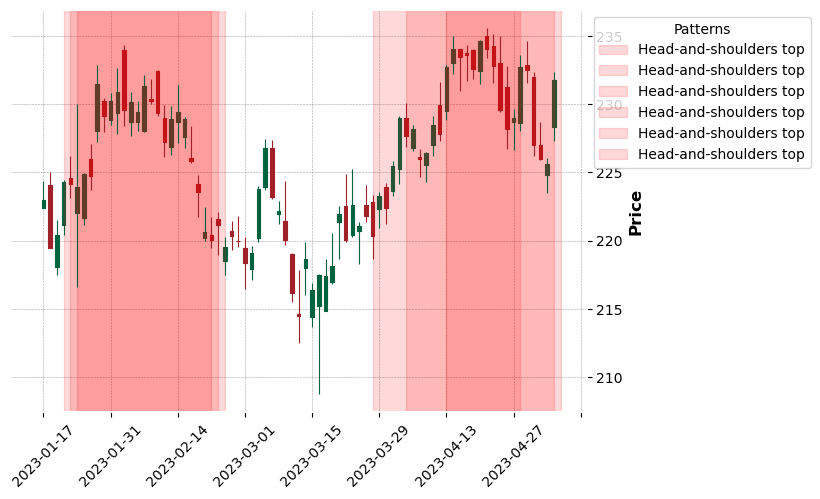

In [90]:
head_and_sholder_clustered_win = cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == 'Head-and-shoulders top']
plot_patterns_for_segment(seg_id, head_and_sholder_clustered_win ,same_color=True , seg_alpha=0.15)

Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-20 00:00:00 Pattern End :  2023-02-21 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-23 00:00:00 Pattern End :  2023-02-22 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-01-24 00:00:00 Pattern End :  2023-02-23 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-03-28 00:00:00 Pattern End :  2023-04-27 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-04 00:00:00 Pattern End :  2023-05-04 00:00:00
Pattern Name :  Head-and-shoulders top Pattern Start :  2023-04-13 00:00:00 Pattern End :  2023-05-05 00:00:00


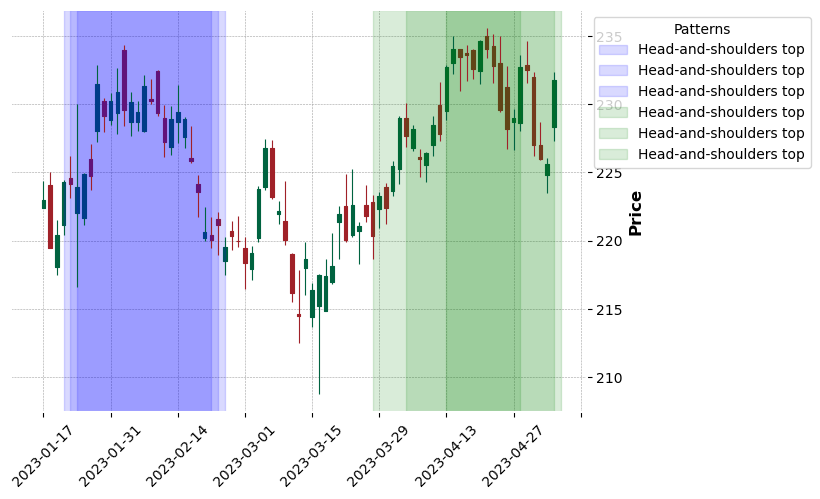

In [91]:
head_and_sholder_clustered_win = cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == 'Head-and-shoulders top']
plot_patterns_for_segment(seg_id, head_and_sholder_clustered_win ,color_cluster_wise=True , seg_alpha=0.15)

In [ ]:
# save located_patterns_and_other_info_final_df to a csv file
located_patterns_and_other_info_updated_df.to_csv('Datasets/located_patterns_and_other_info_updated_df.csv', index=False)

In [ ]:
# print all the columns wihout truncation
pd.set_option('display.max_columns', None)
located_patterns_and_other_info_final_df

Seg_ID Symbol              Chart Pattern  Cluster      Start        End  \
0     380    UPS  Double Top, Adam and Adam        0 2023-10-02 2023-10-19   
1     380    UPS  Double Top, Adam and Adam        1 2023-12-21 2024-01-18   
2     380    UPS       Flag, high and tight        0 2023-11-03 2023-12-06   
3     380    UPS  Head-and-shoulders bottom        0 2023-10-18 2023-11-15   
4     380    UPS     Head-and-shoulders top        0 2023-10-02 2023-11-02   
5     380    UPS     Head-and-shoulders top        1 2023-11-29 2024-01-02   
0     363   TEVA  Double Top, Adam and Adam        0 2023-08-03 2023-09-05   
1     363   TEVA       Flag, high and tight        0 2023-10-19 2023-11-17   
2     363   TEVA  Head-and-shoulders bottom        0 2023-10-06 2023-11-07   
3     363   TEVA     Head-and-shoulders top        0 2023-08-10 2023-10-06   

   Seg_Start    Seg_End Calc_Start   Calc_End Error HS_Left_Shoulder  \
0 2023-09-30 2024-01-22 2023-10-02 2023-10-19  True              NaT   
1 2023-09-30 2024-01-22 2023-12-21 2024-01-18  True              NaT   
2 2023-09-30 2024-01-22 2023-11-03 2023-12-06   NaN              NaT   
3 2023-09-30 2024-01-22 2023-10-18 2023-11-15  True              NaT   
4 2023-09-30 2024-01-22 2023-10-02 2023-11-02  True              NaT   
5 2023-09-30 2024-01-22 2023-12-08 2023-12-22   NaN       2023-12-08   
0 2023-08-03 2023-11-17 2023-08-04 2023-08-22   NaN              NaT   
1 2023-08-03 2023-11-17 2023-10-19 2023-11-17   NaN              NaT   
2 2023-08-03 2023-11-17 2023-10-06 2023-11-07  True              NaT   
3 2023-08-03 2023-11-17 2023-08-22 2023-09-29   NaN       2023-08-22   

     HS_Head HS_Right_Shoulder HS_Neckline_1 HS_Neckline_2  \
0        NaT               NaT           NaT           NaT   
1        NaT               NaT           NaT           NaT   
2        NaT               NaT           NaT           NaT   
3        NaT               NaT           NaT           NaT   
4        NaT               NaT           NaT           NaT   
5 2023-12-18        2023-12-22    2023-12-13    2023-12-21   
0        NaT               NaT           NaT           NaT   
1        NaT               NaT           NaT           NaT   
2        NaT               NaT           NaT           NaT   
3 2023-09-20        2023-09-29    2023-09-07    2023-09-27   

                                          Peak_Dates  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5  3    2023-12-04
7    2023-12-08
13   2023-12-1...   
0  1    2023-08-04
4    2023-08-09
13   2023-08-2...   
1                                                NaN   
2                                                NaN   
3  8    2023-08-22
16   2023-09-01
28   2023-09-2...   

                                        Valley_Dates  DT_Peak_1  DT_Peak_2  \
0                                                NaN        NaT        NaT   
1                                                NaN        NaT        NaT   
2                                                NaN        NaT        NaT   
3                                                NaN        NaT        NaT   
4                                                NaN        NaT        NaT   
5  1    2023-11-30
10   2023-12-13
16   2023-12-2...        NaT        NaT   
0  10   2023-08-17
16   2023-08-25
Name: Date, dt... 2023-08-04 2023-08-22   
1                                                NaN        NaT        NaT   
2                                                NaN        NaT        NaT   
3  5    2023-08-17
11   2023-08-25
19   2023-09-0...        NaT        NaT   

   DT_Valley  
0        NaT  
1        NaT  
2        NaT  
3        NaT  
4        NaT  
5        NaT  
0 2023-08-17  
1        NaT  
2        NaT  
3        NaT

# Evaluating the results


In [37]:
located_patterns_and_other_info_updated_df = located_patterns_and_other_info_final_df

In [38]:
test_patterns

Symbol                 Chart Pattern  BullishBearish       Start  \
0      NUS   Double Bottom, Eve and Adam               0  2023-01-19   
1      CLS  Double Bottom, Adam and Adam               0  2024-03-11   
2     ADTN         Triangle, symmetrical               0  2023-06-16   
3     ADTN     Head-and-shoulders bottom               1  2020-09-09   
4      NSP  Double Bottom, Adam and Adam               0  2023-05-16   
..     ...                           ...             ...         ...   
590   RGLD     Double Top, Adam and Adam               0  2024-10-21   
591    MRK   Double Bottom, Eve and Adam               0  2024-08-07   
592    IRM  Double Bottom, Adam and Adam               0  2025-01-28   
593    CBT     Double Top, Adam and Adam               0  2024-11-25   
594     BG  Double Bottom, Adam and Adam               1  2022-07-06   

            End                  Industry  Pattern_Length  
0    2023-01-31      Toiletries/Cosmetics              12  
1    2024-03-19               Electronics               8  
2    2023-07-10        Telecom. Equipment              24  
3    2020-10-02        Telecom. Equipment              23  
4    2023-05-31           Human Resources              15  
..          ...                       ...             ...  
590  2024-10-29  Metals and Mining (Div.)               8  
591  2024-08-14                      Drug               7  
592  2025-02-03       Industrial Services               6  
593  2024-12-04    Chemical (Diversified)               9  
594  2022-07-14           Food Processing               8  

[595 rows x 7 columns]

In [39]:
def intersection_over_union(start1, end1, start2, end2):
    """
    Compute Intersection over Union (IoU) between two date ranges.
    """
    latest_start = max(start1, start2)
    earliest_end = min(end1, end2)
    overlap = max(0, (earliest_end - latest_start).days + 1)
    union = (end1 - start1).days + (end2 - start2).days + 2 - overlap
    return overlap / union if union > 0 else 0  # Avoid division by zero

def mean_abselute_error(start1, end1, start2, end2):
    """
    Compute Mean Absolute Error (MAE) between two date ranges.
    """
    return (abs(start1 - start2).days + abs(end1 - end2).days) / 2

In [200]:
from tqdm import tqdm
import pandas as pd



# Dictionary to store the count of properly located patterns
number_of_properly_located_patterns = {}
iou_for_each_properly_detected_pattern = {}
mae_for_each_properly_detected_pattern = {}

# Convert date columns to datetime (once, outside the loop for efficiency)
located_patterns_and_other_info_updated_df['Calc_Start'] = pd.to_datetime(located_patterns_and_other_info_updated_df['Calc_Start'])
located_patterns_and_other_info_updated_df['Calc_End'] = pd.to_datetime(located_patterns_and_other_info_updated_df['Calc_End'])

# Iterate over test patterns with progress bar
for index, row in tqdm(test_patterns.iterrows(), total=len(test_patterns), desc="Processing Patterns"):
    symbol = row['Symbol']
    chart_pattern = row['Chart Pattern']
    start_date = pd.to_datetime(row['Start']).tz_localize(None)
    end_date = pd.to_datetime(row['End']).tz_localize(None)
    
    # Filter for matching symbol and chart pattern
    located_patterns_for_this = located_patterns_and_other_info_updated_df[
        (located_patterns_and_other_info_updated_df['Symbol'] == symbol) &
        (located_patterns_and_other_info_updated_df['Chart Pattern'] == chart_pattern)
    ].copy()  # Use `.copy()` to avoid SettingWithCopyWarning
    
    if located_patterns_for_this.empty:
        continue  # Skip if no matching rows
    
    # Compute IoU for each row using .loc to avoid warnings
    located_patterns_for_this.loc[:, 'IoU'] = located_patterns_for_this.apply(
        lambda x: intersection_over_union(start_date, end_date, x['Calc_Start'], x['Calc_End']),
        axis=1
    )
    
    # Compute MAE for each row using .loc to avoid warnings
    located_patterns_for_this.loc[:, 'MAE'] = located_patterns_for_this.apply(
        lambda x: mean_abselute_error(start_date, end_date, x['Calc_Start'], x['Calc_End']),
        axis=1
    )

    
    # Filter based on IoU threshold (≥ 0.8)
    located_patterns_for_this_proper = located_patterns_for_this[located_patterns_for_this['IoU'] >= 0.25]
    
    if not located_patterns_for_this_proper.empty:
        number_of_properly_located_patterns[chart_pattern] = number_of_properly_located_patterns.get(chart_pattern, 0) + 1
        iou_for_each_properly_detected_pattern[chart_pattern] = iou_for_each_properly_detected_pattern.get(chart_pattern, 0) + max(located_patterns_for_this_proper['IoU'])
        mae_for_each_properly_detected_pattern[chart_pattern] = mae_for_each_properly_detected_pattern.get(chart_pattern, 0) + min(located_patterns_for_this_proper['MAE'])

number_of_properly_located_patterns


Processing Patterns:   0%|          | 0/595 [00:00<?, ?it/s]

Processing Patterns: 100%|██████████| 595/595 [00:01<00:00, 305.89it/s]


{'Triangle, symmetrical': 7,
 'Head-and-shoulders top': 46,
 'Flag, high and tight': 22,
 'Double Top, Adam and Adam': 27,
 'Head-and-shoulders bottom': 29,
 'Double Bottom, Adam and Adam': 5,
 'Double Bottom, Eve and Adam': 5}

## Recall


In [201]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
total_number_of_test_patterns = len(test_patterns)

recall = total_number_of_properly_located_patterns / total_number_of_test_patterns

print (f"Total number of properly located patterns {total_number_of_properly_located_patterns} out of {total_number_of_test_patterns} test patterns")
print (f"Recall: {recall}")

Total number of properly located patterns 141 out of 595 test patterns
Recall: 0.23697478991596638


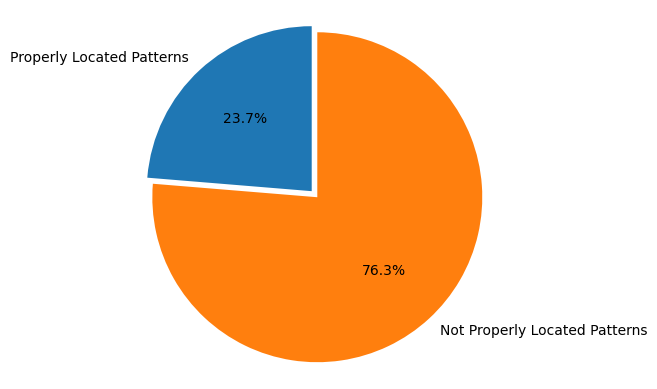

In [202]:
# Draw a pie chart of total_number_of_test_patterns vs total_number_of_properly_located_patterns
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Properly Located Patterns', 'Not Properly Located Patterns'
sizes = [recall, 1-recall]
explode = (0.05, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

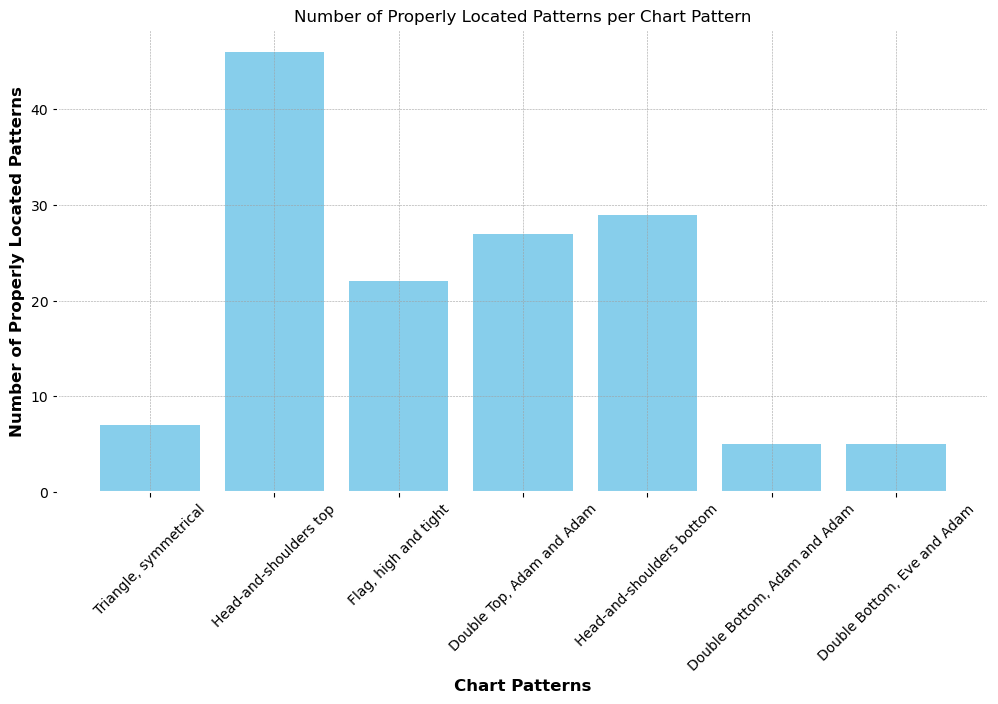

In [203]:
# visualize the recall
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(12, 6))

plt.bar(number_of_properly_located_patterns.keys(), number_of_properly_located_patterns.values(), color='skyblue')
plt.xlabel('Chart Patterns')
plt.ylabel('Number of Properly Located Patterns')
plt.title('Number of Properly Located Patterns per Chart Pattern')
plt.xticks(rotation=45)
plt.show()

### Per Pattern Recall


In [204]:
# calculate the per pattern recall
per_pattern_recall = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_recall[pattern] = count / test_patterns[test_patterns['Chart Pattern'] == pattern].shape[0]
    
for pattern, recall in per_pattern_recall.items():
    print(f"Recall for {pattern}: {recall}")

Recall for Triangle, symmetrical: 0.0660377358490566
Recall for Head-and-shoulders top: 0.6388888888888888
Recall for Flag, high and tight: 0.5116279069767442
Recall for Double Top, Adam and Adam: 0.28421052631578947
Recall for Head-and-shoulders bottom: 0.4264705882352941
Recall for Double Bottom, Adam and Adam: 0.0364963503649635
Recall for Double Bottom, Eve and Adam: 0.08196721311475409


In [205]:
import matplotlib.pyplot as plt

# Define labels and explode
labels = ['Properly Located Patterns', 'Not Properly Located Patterns']
explode = (0.05, 0)  # Explode the first slice

# Create subplots
fig, axs = plt.subplots(1, 7, figsize=(25, 4))
fig.suptitle('Recall per Chart Pattern')

# Plot each pie chart
for i, (pattern, recall) in enumerate(per_pattern_recall.items()):
    ax = axs[i % 7]  # Fix index to avoid out-of-bounds errors
    wedges, texts, autotexts = ax.pie(
        [recall, 1 - recall],
        explode=explode,
        labels=[None, None],  # Remove labels from pie chart
        autopct='%1.1f%%',
        startangle=90
    )
    ax.set_title(pattern)

# Add a single legend for all pie charts
fig.legend(wedges, labels, loc="upper right")

plt.show()


## Precision


In [206]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
total_number_of_all_located_patterns = len(located_patterns_and_other_info_updated_df)

precision = total_number_of_properly_located_patterns / total_number_of_all_located_patterns

print (f"Total number of properly located patterns {total_number_of_properly_located_patterns} out of {total_number_of_all_located_patterns} located patterns")
print (f"Precision: {precision}")

Total number of properly located patterns 141 out of 1721 located patterns
Precision: 0.08192911098198721


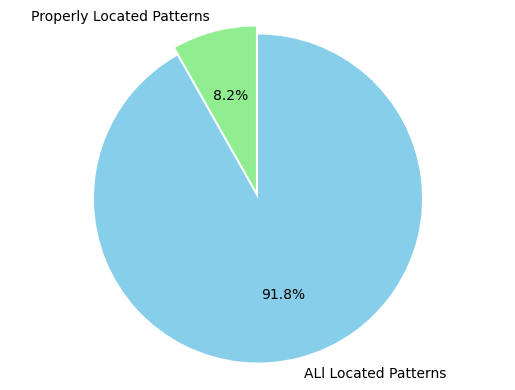

In [207]:
# Draw a pie chart of total_number_of_test_patterns vs total_number_of_properly_located_patterns
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Properly Located Patterns', 'ALl Located Patterns'
sizes = [precision, 1-precision]
explode = (0.05, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90,colors=['lightgreen', 'skyblue'])
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

### Per pattern Precision


In [208]:
# calculate the per pattern precision
per_pattern_precision = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_precision[pattern] = count / located_patterns_and_other_info_updated_df[located_patterns_and_other_info_updated_df['Chart Pattern'] == pattern].shape[0]

for pattern, precision in per_pattern_precision.items():
    print(f"Precision for {pattern}: {precision}")

Precision for Triangle, symmetrical: 0.10294117647058823
Precision for Head-and-shoulders top: 0.08614232209737828
Precision for Flag, high and tight: 0.0707395498392283
Precision for Double Top, Adam and Adam: 0.057203389830508475
Precision for Head-and-shoulders bottom: 0.11284046692607004
Precision for Double Bottom, Adam and Adam: 0.20833333333333334
Precision for Double Bottom, Eve and Adam: 0.09090909090909091


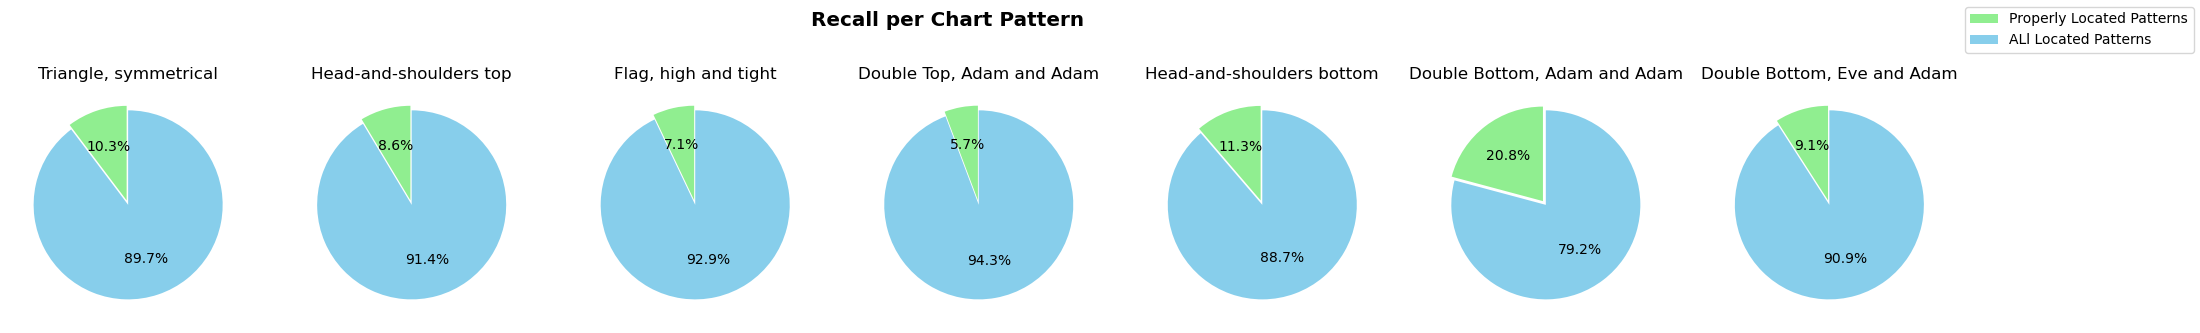

In [209]:
import matplotlib.pyplot as plt

# Define labels and explode
labels = ['Properly Located Patterns', 'ALl Located Patterns']
explode = (0.05, 0)  # Explode the first slice

# Create subplots
fig, axs = plt.subplots(1, 7, figsize=(25, 4))
fig.suptitle('Recall per Chart Pattern')

# Plot each pie chart
for i, (pattern, precision) in enumerate(per_pattern_precision.items()):
    ax = axs[i % 7]  # Fix index to avoid out-of-bounds errors
    wedges, texts, autotexts = ax.pie(
        [precision, 1 - precision],
        explode=explode,
        labels=[None, None],  # Remove labels from pie chart
        autopct='%1.1f%%',
        startangle=90,
        colors=['lightgreen', 'skyblue']
    )
    ax.set_title(pattern)

# Add a single legend for all pie charts
fig.legend(wedges, labels, loc="upper right")

plt.show()


## F1 Score


In [210]:
if precision + recall == 0:
    F1_score = 0
else:
    F1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {F1_score}")

F1 Score: 0.08620689655172413


### Per pattern F1 score


In [211]:
# calculate the per pattern F1 score
per_pattern_F1_score = {}
for pattern, recall in per_pattern_recall.items():
    per_pattern_F1_score[pattern] = 2 * (per_pattern_precision[pattern] * recall) / (per_pattern_precision[pattern] + recall) + 1e-9
    
for pattern, F1_score in per_pattern_F1_score.items():
    print(f"F1 Score for {pattern}: {F1_score}")

F1 Score for Triangle, symmetrical: 0.08045977111494251
F1 Score for Head-and-shoulders top: 0.15181518251815182
F1 Score for Flag, high and tight: 0.12429378631073447
F1 Score for Double Top, Adam and Adam: 0.09523809623809523
F1 Score for Head-and-shoulders bottom: 0.17846153946153845
F1 Score for Double Bottom, Adam and Adam: 0.062111802242236024
F1 Score for Double Bottom, Eve and Adam: 0.08620689755172413


## Mean Absolute Error (MAE) of correct patterns


In [224]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
mae = sum(mae_for_each_properly_detected_pattern.values()) / (total_number_of_properly_located_patterns + 1e-9)

print (f"Mean Absolute Error: {mae}")

Mean Absolute Error: 5.1276595744317195


### Per pattern MAE


In [225]:
# calculate the per pattern MAE
per_pattern_mae = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_mae[pattern] = mae_for_each_properly_detected_pattern[pattern] / count
    
for pattern, pp_mae in per_pattern_mae.items():
    print(f"Mean Absolute Error for {pattern}: {pp_mae}")

Mean Absolute Error for Triangle, symmetrical: 8.0
Mean Absolute Error for Head-and-shoulders top: 3.391304347826087
Mean Absolute Error for Flag, high and tight: 11.568181818181818
Mean Absolute Error for Double Top, Adam and Adam: 4.537037037037037
Mean Absolute Error for Head-and-shoulders bottom: 3.8793103448275863
Mean Absolute Error for Double Bottom, Adam and Adam: 1.7
Mean Absolute Error for Double Bottom, Eve and Adam: 2.6


## Mean Intersection Over Union of correct patterns


In [226]:
miou = sum(iou_for_each_properly_detected_pattern.values()) / (total_number_of_properly_located_patterns + 1e-9)

print (f"Mean Intersection over Union: {miou}")

Mean Intersection over Union: 0.7641669143500674


### Per pattern IOU


In [227]:
# calculate the per pattern IoU
per_pattern_iou = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_iou[pattern] = iou_for_each_properly_detected_pattern[pattern] / count

for pattern, pp_iou in per_pattern_iou.items():
    print(f"Mean Intersection over Union for {pattern}: {pp_iou}")

Mean Intersection over Union for Triangle, symmetrical: 0.6724475287771873
Mean Intersection over Union for Head-and-shoulders top: 0.8073618276919273
Mean Intersection over Union for Flag, high and tight: 0.6750719054704021
Mean Intersection over Union for Double Top, Adam and Adam: 0.7318206466940096
Mean Intersection over Union for Head-and-shoulders bottom: 0.8038327689186491
Mean Intersection over Union for Double Bottom, Adam and Adam: 0.7671221532091097
Mean Intersection over Union for Double Bottom, Eve and Adam: 0.8288515406162464


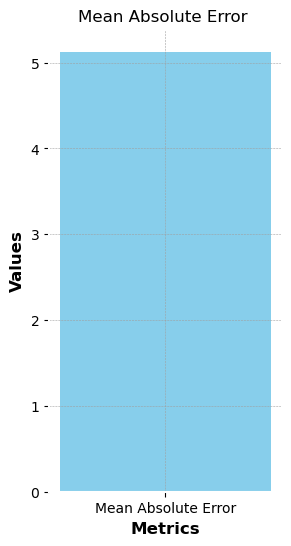

In [229]:
# draw a grapg to show the mae and miou 
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(3, 6))


plt.bar("Mean Absolute Error", mae, color='skyblue')


plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Mean Absolute Error ')
# plt.xticks(rotation=45)
plt.show()



In [ ]:


# draw a grapg to show the mae and miou 
import matplotlib.pyplot as plt

# Create a bar chart
plt.figure(figsize=(3, 6))

plt.bar("Mean Intersection over Union", miou, color='lightgreen')

plt.ylim(0, 1) 
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Mean Intersection over Union')
# plt.xticks(rotation=45)
plt.show()


Mean Intersection over Union: 76.42%


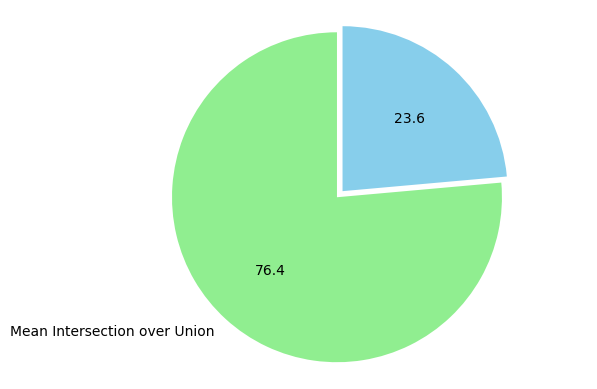

In [ ]:
# show the miou as a percentage
miou_percentage = miou * 100
print(f"Mean Intersection over Union: {miou_percentage:.2f}%")

# Draw a pie chart of total_number_of_test_patterns vs total_number_of_properly_located_patterns
import matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Mean Intersection over Union', ''
sizes = [miou, 1-miou]
explode = (0.05, 0)  # only "explode" the 1st slice


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f', startangle=90,colors=['lightgreen', 'skyblue'])
# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

plt.show()

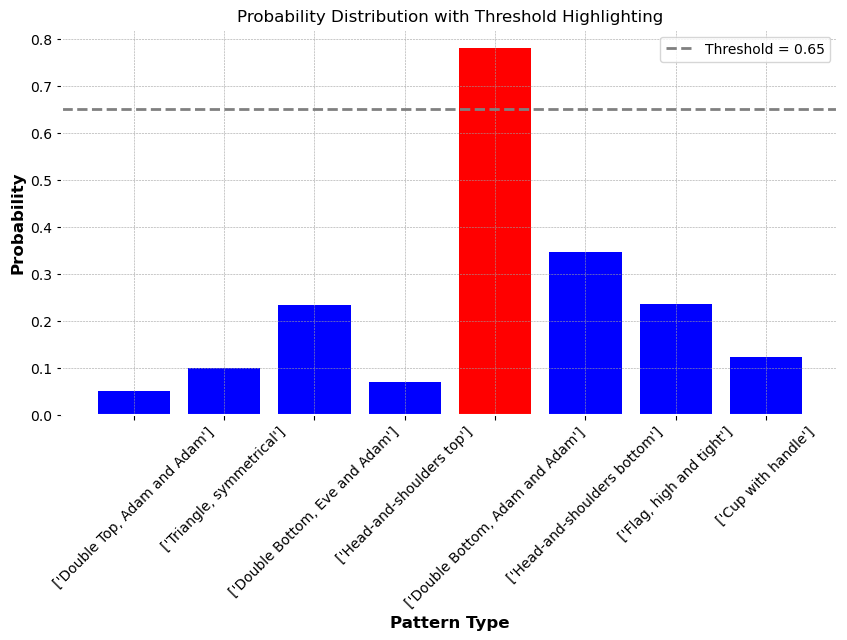

In [236]:
import matplotlib.pyplot as plt
import numpy as np

# Your probability values
probabilities = [0.05, 0.1, 0.234, 0.07, 0.78, 0.345, 0.2345, 0.123]  
threshold = 0.65

# Define x-axis labels (replace with actual pattern names if available)
pattern_labels = [f"{[pattern_encoding_reversed[i]]}" for i in range(len(probabilities))]  

# Create indices for the x-axis
indices = np.arange(len(probabilities))

# Highlight values above threshold
colors = ["red" if p >= threshold else "blue" for p in probabilities]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(indices, probabilities, color=colors)
plt.axhline(y=threshold, color="gray", linestyle="--", label=f"Threshold = {threshold}")

# Labels
plt.xticks(indices, pattern_labels, rotation=45)  # Corrected x labels
plt.xlabel("Pattern Type")
plt.ylabel("Probability")
plt.title("Probability Distribution with Threshold Highlighting")
plt.legend()
plt.show()
